<center>
<img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="300" height="150"/></center>

<center><font size=6>Stock Market News - Sentiment Analysis</font></center>

## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing Necessary Libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
#!pip install -U numpy==2.0.1 scipy==1.14.1 sentence-transformers unidecode transformers tqdm -q
!pip install gensim unidecode scipy==1.13.1 numpy==1.26.4
# 1.14.1

In [2]:
!pip install zeugma==0.41

  Using cached zeugma-0.41.tar.gz (8.3 kB)
  Preparing metadata (setup.py) ... done
  Using cached fasttext-0.9.3.tar.gz (73 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for zeugma: filename=zeugma-0.41-py3-none-any.whl size=9857 sha256=4d2da5bbf848a89ed6e15441bb4f7e21a15d2801557920f8732ef41a8e31951b
  Stored in directory: /root/.cache/pip/wheels/3d/42/7b/2da6f83151576f69aa17d62ec011597c5e700b253a3b9fb7ec
  Created wheel for fastText: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498212 sha256=ddfb369d54c6194cf56634e66f07d484dfa641d143268b1052179aa8b71a2e40
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built zeugma fastText


In [3]:
!pip install -U sentence-transformers -q

In [4]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# To import Word2Vec
from gensim.models import Word2Vec

# Converting the Stanford GloVe model vector format to word2vec
from gensim.scripts.glove2word2vec import glove2word2vec

# to import the model
from sentence_transformers import SentenceTransformer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import torch

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Loading the dataset**

In [5]:
# config section

# path to csv file
path = '/content/drive/MyDrive/NLP/stock_news.csv'

# path to glove input file
#glove_input_file = '/content/drive/MyDrive/NLP/glove.6B.100d.txt.word2vec'
glove_input_file = '/content/drive/MyDrive/NLP/glove.6B.100d.txt'

# set pandas dataframe maxwidth to None
pd.set_option('max_colwidth',None)


In [6]:
# import the dataset
from google.colab import drive
drive.mount('/content/drive')
stock_news = pd.read_csv(path)

Mounted at /content/drive


In [7]:
# Backup the stocks news
df = stock_news.copy()
df.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,"Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets",41.740002,42.244999,41.482498,40.246914,130672400,-1


## **Data Overview**

In [8]:
# print the shape
df.shape

(349, 8)

* There are 349 news texts.
* There are 349 rows and 8 columns

In [9]:
# analyze the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


* The dataset has 2 object, 4 float and 2 int data types.
* The dataset takes about 21.9 KB of storage

In [10]:
# check for null values
df.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


* There are no null values in the dataset.

In [11]:
# check for duplicated rows
df.duplicated().sum()

0

* There are no duplicate rows in the dataset

In [12]:
# describe the numeric features dataset
df.describe(include='number')

,Open,High,Low,Close,Volume,Label
count,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
std,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119
min,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000


* Average closing prices are around 45 - 46 dollars, with most values between roughly 40 and 50 dollars.
* Lowest prices are around 36 to 37 dollars, and the highest are about 66 to 67 dollars
* On average 128.9 million shares traded daily, ranging from 45 million to 244 million.
* The average stock sentiment is slightly negative.

In [13]:
# describe the object datatypes
df.describe(include='object')

,Date,News
count,349,349
unique,71,349
top,2019-01-03,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January."
freq,28,1


* There are 71 unique dates. The most frequent date is 2019-01-03, appearing 28 times.

* There are 349 unique news headlines with no repeats.

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

In [14]:
# Add the feature of the length of text
df['Text_Len'] = df['News'].apply(len)

In [15]:
# This function plots the box plot and histogram for numerical features in univarient analysis
def boxplot_histogram(data, feature, figsize=(15,8), kde=True, bins=None):
  """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default True)
    bins: number of bins for histogram (default None)
  """
  fig, (axes_box, axes_hist) = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios": (0.35, 0.65)}, figsize=figsize)

  # boxplot
  sns.boxplot(data=data, x=feature, ax=axes_box, showmeans=True, color="violet")

  # histogram
  if bins :
    sns.histplot(data=data, x=feature, ax=axes_hist, kde=kde, bins=bins)
  else:
    sns.histplot(data=data, x=feature, ax=axes_hist, kde=kde)

  # set mean and median in histogram
  axes_hist.axvline(data[feature].mean(), color='green', linestyle='--')
  axes_hist.axvline(data[feature].median(), color='black', linestyle='-')
  plt.show()

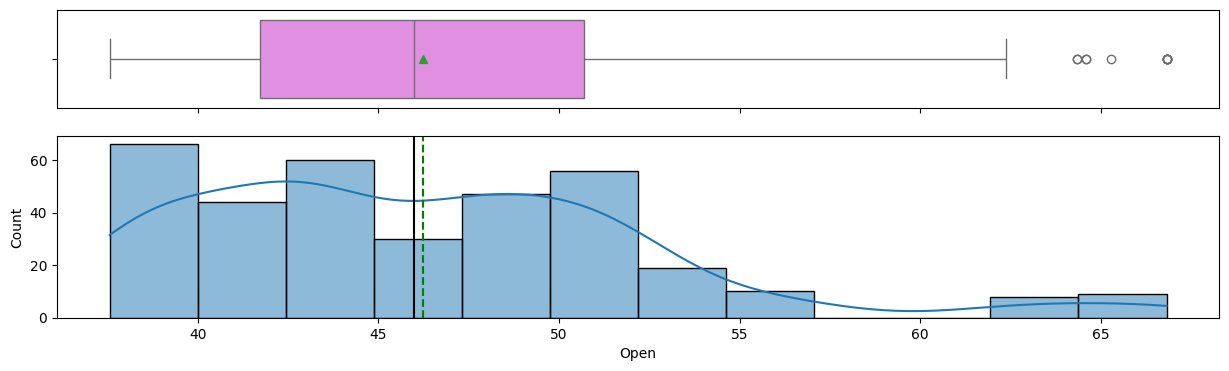

In [16]:
# plot the feature Open
boxplot_histogram(df,'Open',(15,4))

**Observations**:

* The feature contains outliers toward the higher end.

* The distribution shows a slight skewness to the right.

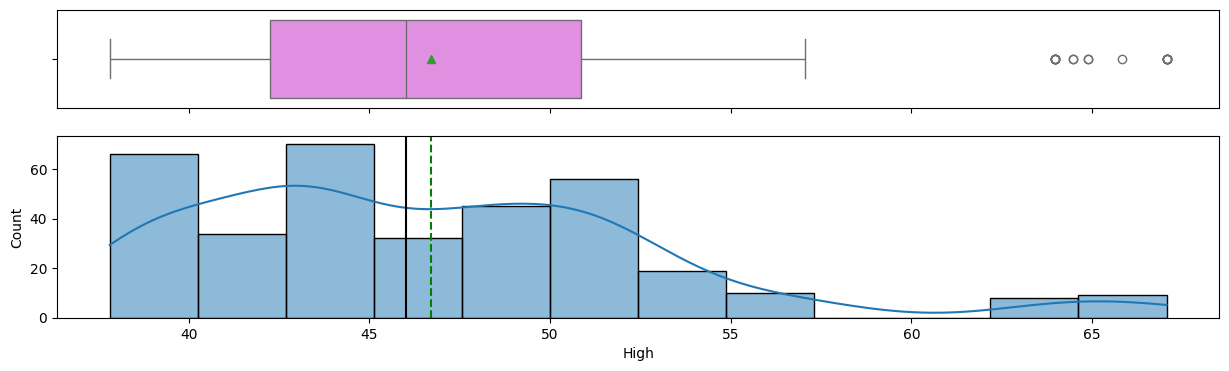

In [17]:
# plot the High price feature
boxplot_histogram(df,'High',(15,4))

**Observations**:

* The feature exhibits high-end outliers.
* The distribution is slightly right skewed

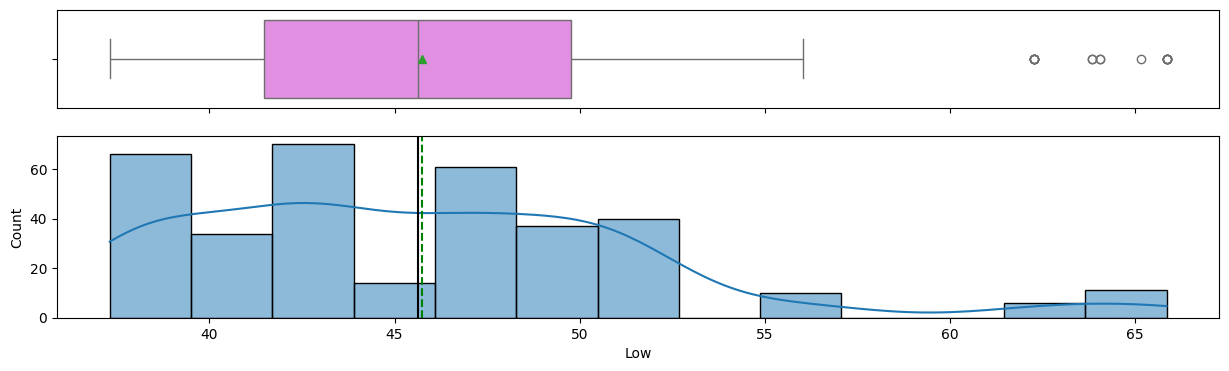

In [18]:
# plot feature Low
boxplot_histogram(df,'Low',(15,4))

**Observations**:
* The feature has outliers on the higher end.
* Very slight right skewness

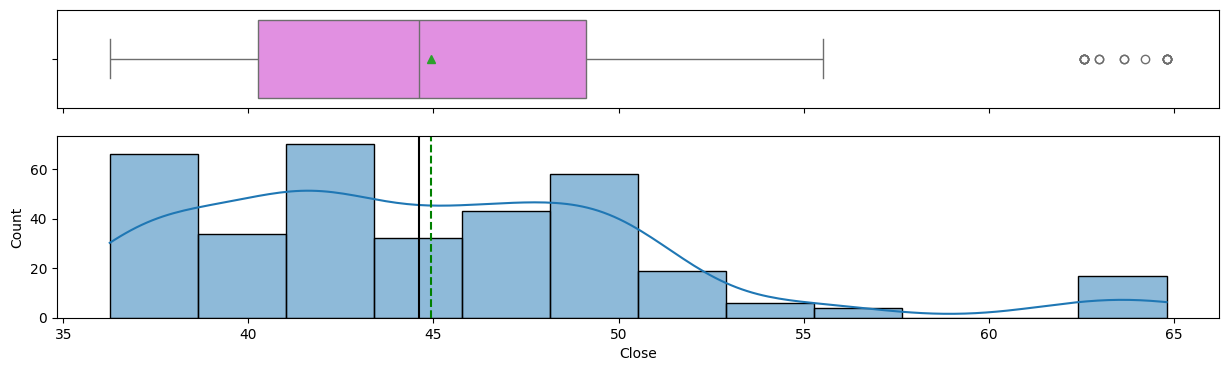

In [19]:
# plot the feature close
boxplot_histogram(df,'Close',(15,4))

**Observations**:

* The feature has outliers on the right side.
* It is slightly right skewed

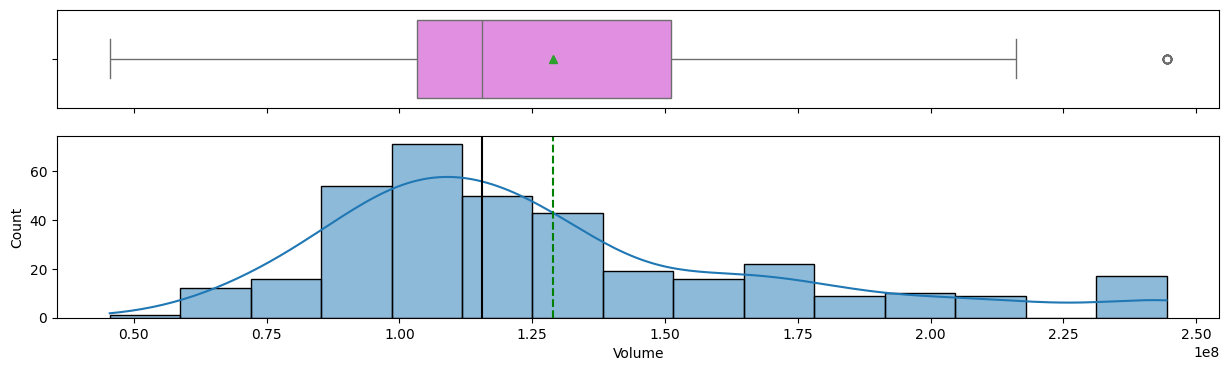

In [20]:
# plot the feature - Volume of the shares
boxplot_histogram(df,'Volume',(15,4))

**Observations**:

* The stock volume follows an approximately normal distribution.

* The distribution is skewed to the right.

* There is only a single outlier on the higher end.

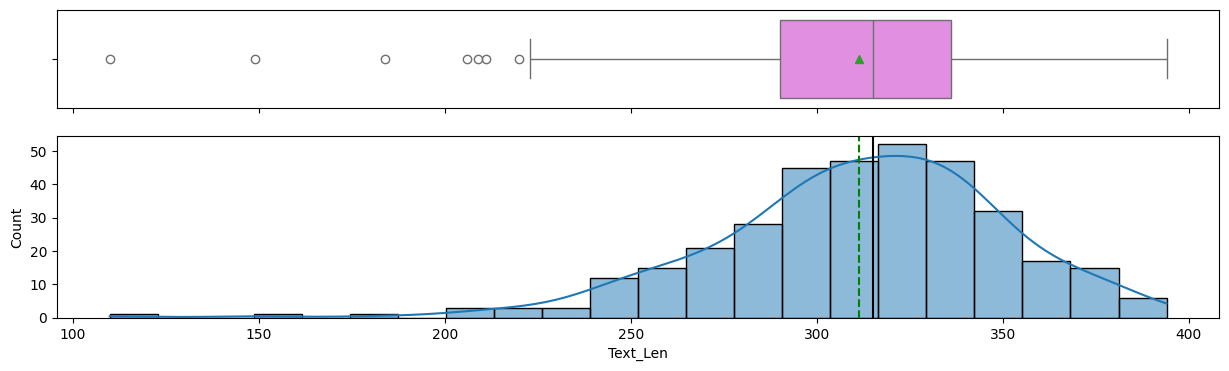

In [21]:
# plot the feature - Length of text in news
boxplot_histogram(df,'Text_Len',(15,4))

**Observations**:
* The length of text in news is nearly uniform distributed.
* It has outliers on the lower end indicating some news are very short.
* The distribution is slightly left skewed.

In [22]:
# plot a barplot with labels for given features
def labelled_barplot(data, features,cols=1,figsize=None, legend=True, bivarient=False):
  rows = (len(features)+cols - 1)//cols
  if figsize is None:
    plt.figure(figsize=(cols*6,rows*4))
  else:
    plt.figure(figsize=figsize)


  for i,feature in enumerate(features):
    plt.subplot(rows,cols,i+1)

    if bivarient == True:
      hue='Label'
    else:
      hue = feature

    ax = sns.countplot(data, x=feature,palette="Paired",hue=hue,order=df[feature].value_counts().index)
    for container in ax.containers:
      ax.bar_label(container, fmt='%d', fontsize=10)
    ax.set_title(f'Count plot - {feature}')

    ax.tick_params(axis='x', rotation=90)
    if legend == False :
      ax.legend_.remove()

  plt.tight_layout()
  plt.show()

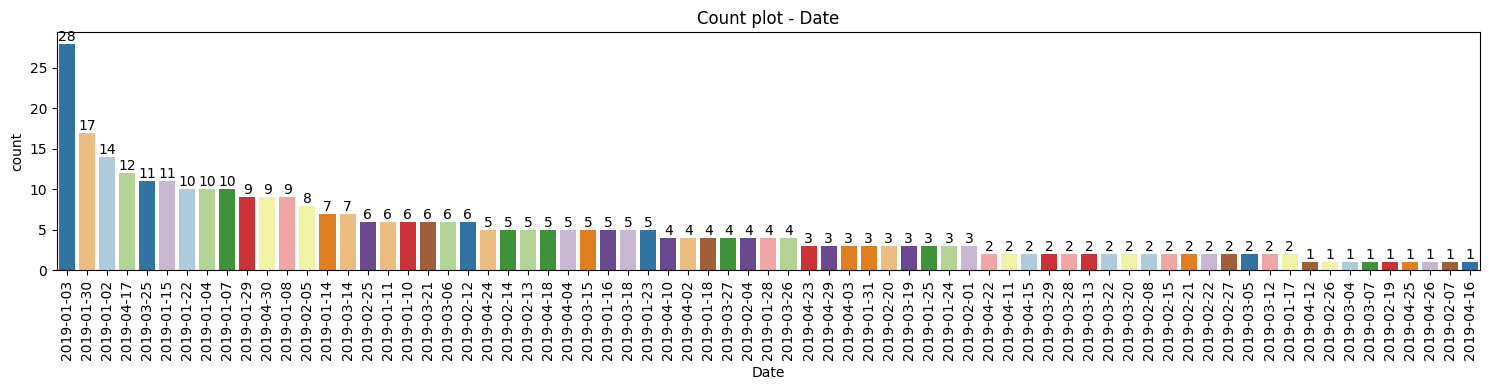

In [23]:
# count plot for News
labelled_barplot(df,['Date'],figsize=(15,4))

**Observations**:

* Certain days, such as 2019-01-03 and 2019-01-30, have a high number of articles.

* On some days, only a single article is present.

* 2019-01-03 recorded the highest number of articles.

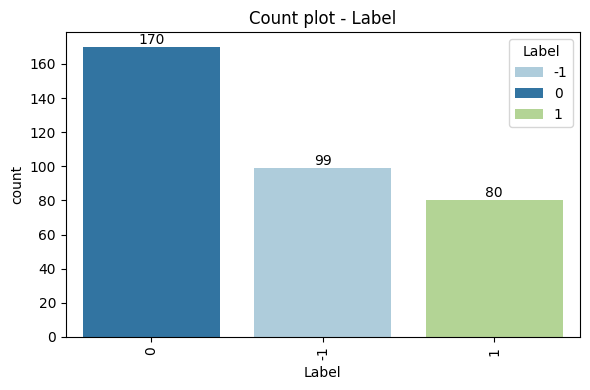

In [24]:
# countplot for Label
labelled_barplot(df,['Label'])

**Observations**:
* There is a large number of negative sentiment labels.

* Positive sentiment labels are relatively few.

* Neutral sentiment labels are fairly high in number.

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

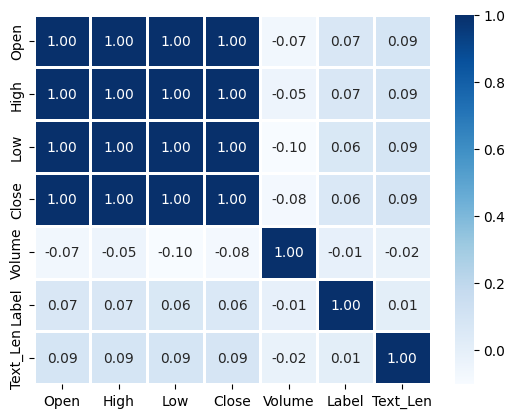

In [25]:
# lets analyze the correlation between the features
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='Blues',linewidths=1, linecolor='white');

**Observations**:
* The stock price features — Open, High, Low, and Close — are strongly correlated with one another, which is expected.

* No significant correlation is observed between the sentiment labels and the price features.

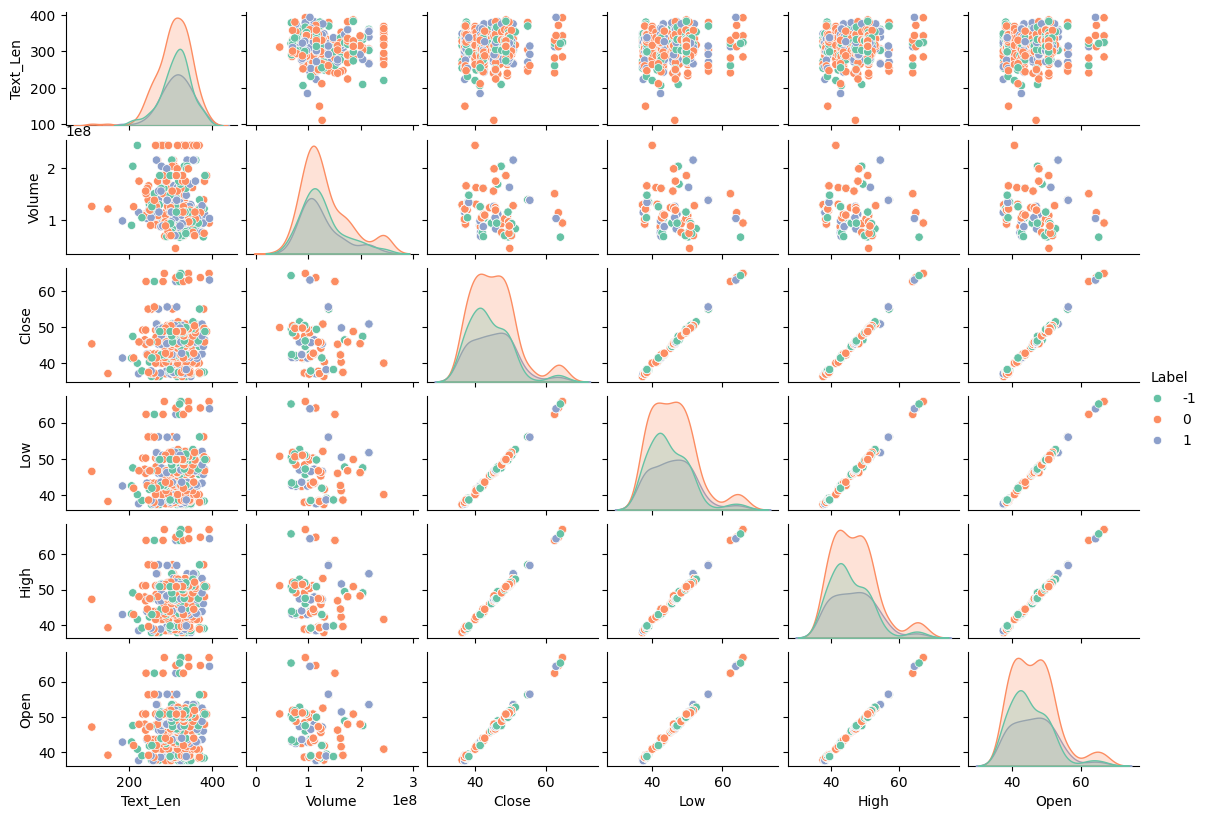

In [26]:
# visualize pairplots
g=sns.pairplot(data=df[['Text_Len','Volume','Close','Low', 'High','Open','Label']], hue='Label', palette="Set2");
g.fig.set_size_inches(12, 8)
plt.show()

**Observations**
* Negative sentiment is prevalent across all price features.

* Positive sentiment is low across all price features.

* There is no strong correlation between trading volume and the price features.

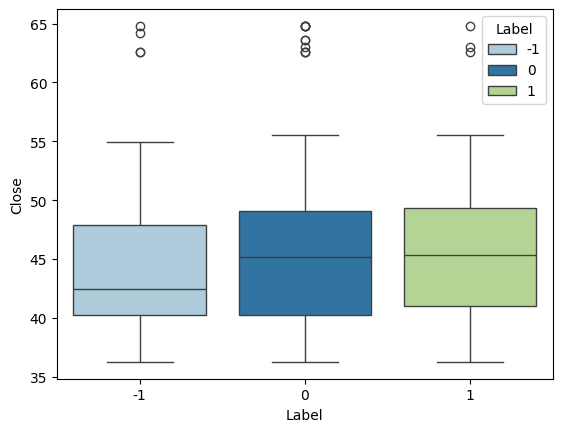

In [27]:
# plot the boxplot for sentiment label with price
sns.boxplot(data=df , x='Label', y='Close', hue='Label', palette='Paired')
plt.show()

**Observations**:

* The closing price tends to be lower for the negative sentiment label.

* The closing prices for positive and neutral sentiments are nearly the same.

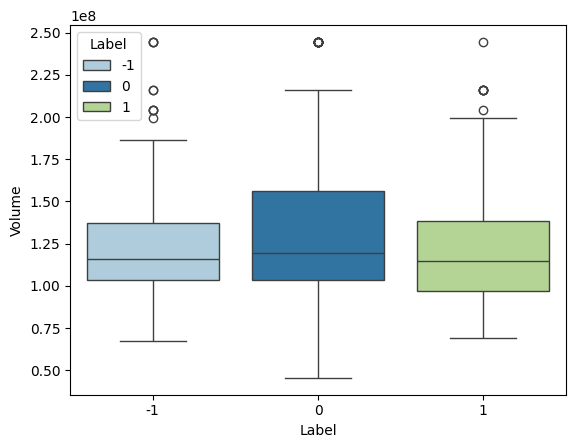

In [28]:
# plot the boxplot for sentiment label with Volume
sns.boxplot(data=df , x='Label', y='Volume', hue='Label', palette='Paired')
plt.show()

**Observations**:

* Outliers are present for all sentiment categories in the stock volume on the higher end.

* Stock volume is higher for neutral sentiment.

* Stock volume is lower for positive sentiment.

In [29]:
# convert object to datetime
df['Date'] = pd.to_datetime(df['Date'])

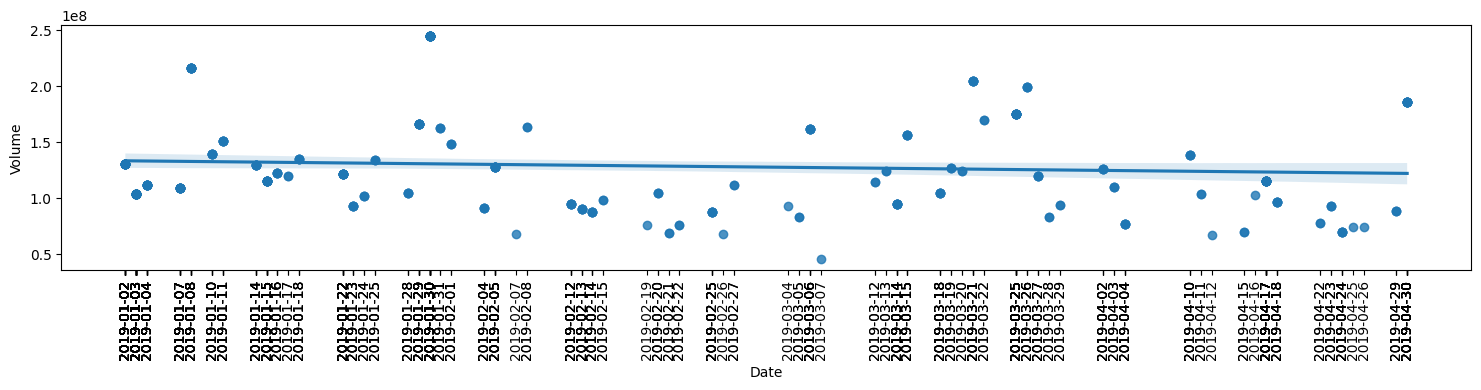

In [30]:
# plot closing price feature with date
plt.figure(figsize=(15,4))
sns.regplot(data=df, x=df['Date'].map(pd.Timestamp.toordinal) , y='Volume')
plt.xticks(df['Date'].map(pd.Timestamp.toordinal), df['Date'].dt.strftime('%Y-%m-%d'), rotation=90)
plt.tight_layout()
plt.show()

**Observations**:

The stock volume shows a decreasing trend over time.

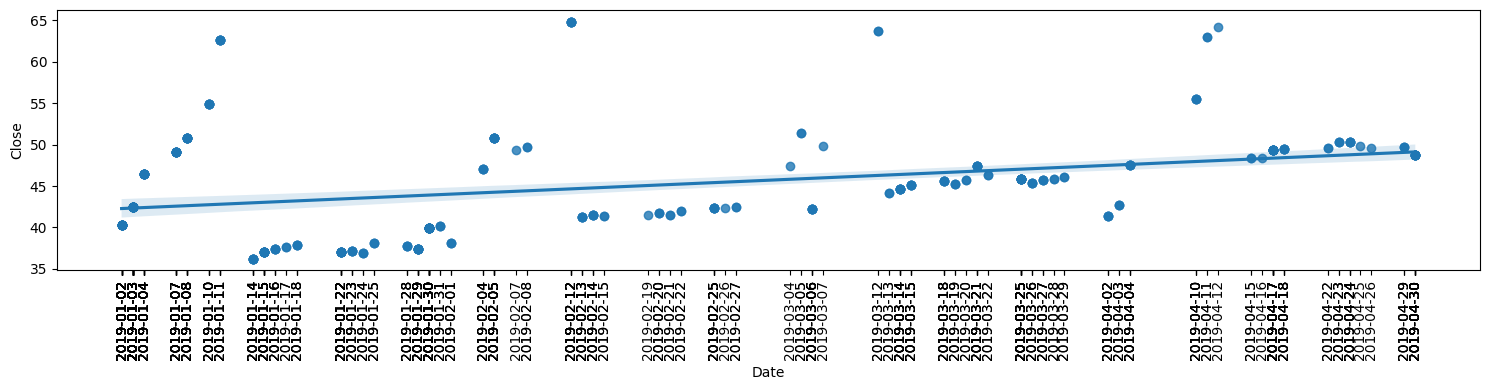

In [31]:
# plot closing price feature with date
plt.figure(figsize=(15,4))
sns.regplot(data=df, x=df['Date'].map(pd.Timestamp.toordinal) , y='Close')
plt.xticks(df['Date'].map(pd.Timestamp.toordinal), df['Date'].dt.strftime('%Y-%m-%d'), rotation=90)
plt.tight_layout()
plt.show()

**Observations**:

The closing price tends to increase with time.

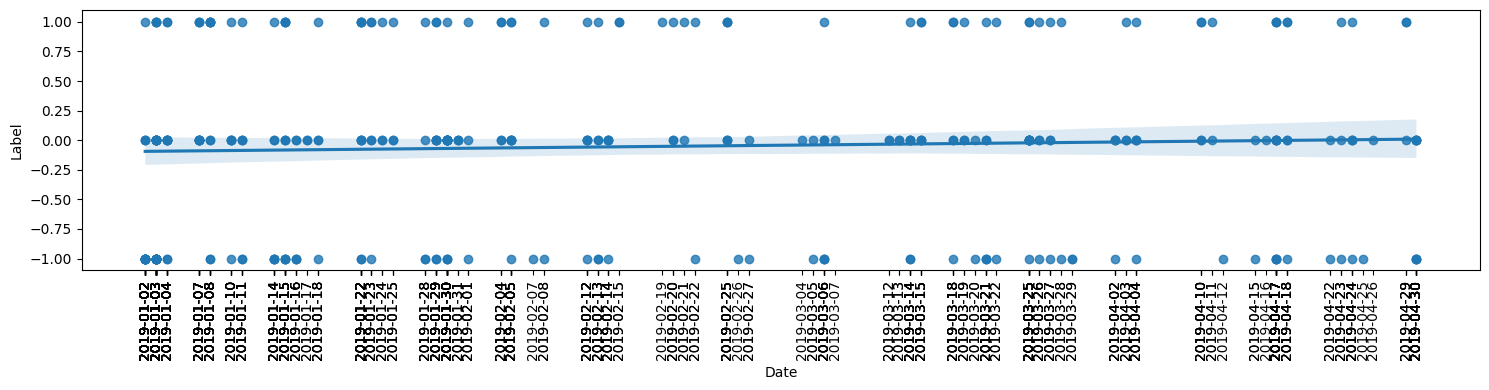

In [32]:
# plot sentiment label feature with date
plt.figure(figsize=(15,4))
sns.regplot(data=df, x=df['Date'].map(pd.Timestamp.toordinal) , y='Label')
plt.xticks(df['Date'].map(pd.Timestamp.toordinal), df['Date'].dt.strftime('%Y-%m-%d'), rotation=90)
plt.tight_layout()
plt.show()

**Observations**:

The sentiment remains largely neutral over time, with a slight upward trend.

In [33]:
# Take the backup and perform weekly analysis
df_week = df.copy()

In [34]:
from collections import Counter
 #Add a 'week' column (start of the week: Monday)
df_week['Week'] = df_week['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Function to return majority label; if tie → 0 (Neutral)
def majority_label(labels):
    counts = Counter(labels)
    most_common = counts.most_common()
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0  # Neutral for tie
    return most_common[0][0]

# Group by week and aggregate
weekly_sentiment = (
    df_week.groupby('Week')['Label']
    .agg(majority_label)
    .reset_index()
)

print(weekly_sentiment)

         Week  Label
0  2018-12-31     -1
1  2019-01-07      0
2  2019-01-14     -1
3  2019-01-21      0
4  2019-01-28      0
5  2019-02-04      0
6  2019-02-11      0
7  2019-02-18      1
8  2019-02-25      0
9  2019-03-04      0
10 2019-03-11      0
11 2019-03-18      0
12 2019-03-25      0
13 2019-04-01      0
14 2019-04-08      0
15 2019-04-15      0
16 2019-04-22      0
17 2019-04-29      0


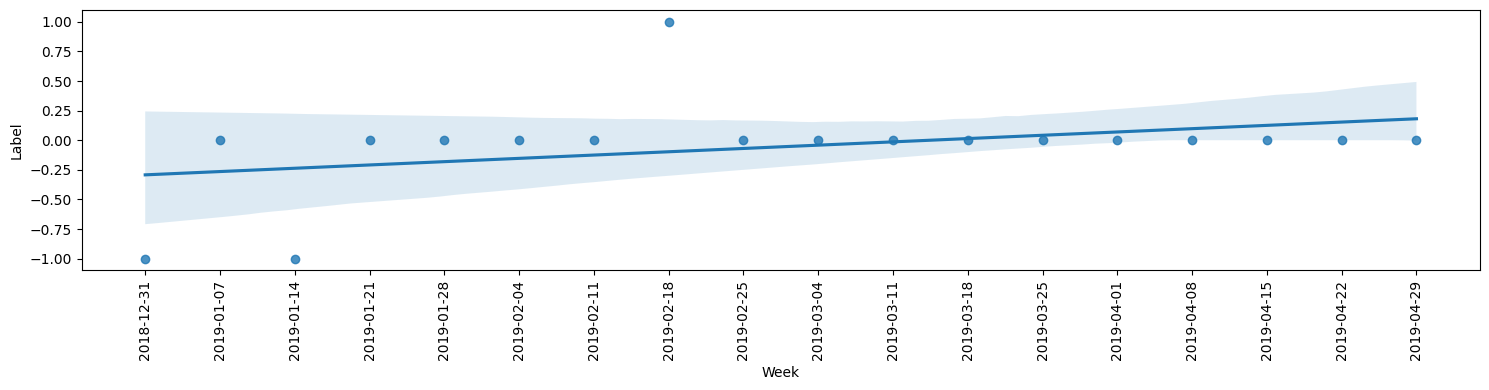

In [35]:
# Analyze the sentiment in a week
plt.figure(figsize=(15,4))
sns.regplot(data=weekly_sentiment, x=weekly_sentiment['Week'].map(pd.Timestamp.toordinal) , y='Label')
plt.xticks(weekly_sentiment['Week'].map(pd.Timestamp.toordinal), weekly_sentiment['Week'].dt.strftime('%Y-%m-%d'), rotation=90)
plt.tight_layout()
plt.show()

**Observations**:

* The weeks of 2018-12-31 and 2019-01-14 exhibit negative sentiment.

* The week of 2019-02-18 shows positive sentiment.

* The remaining weeks display neutral sentiment,
* The overall sentiment is neutral with a slight upward tendency.

#### **EDA Insights**

* Price features (Open, Close, Low, High) exhibit outliers and are slightly right-skewed.

* Stock volume is approximately normally distributed.

* Dates 2019-01-03 and 2019-01-30 have a high number of articles.

* Negative sentiment labels are predominant.

* The stock price features — Open, High, Low, and Close — are strongly correlated, as expected.

* No strong correlation exists between trading volume and price features.

* Closing prices tend to be lower for negative sentiment labels.

* Stock volume is higher for neutral sentiment.

* Stock volume is lower for positive sentiment.

* Stock volume shows a decreasing trend over time.

* Closing prices show an increasing trend over time.

* Overall sentiment remains neutral, with a slight upward tendency.


## **Data Preprocessing**

Stock prices are time-dependent and sequential, meaning future prices depend on past patterns. Hence the dataset is split with sequence instead of random train and test split.

First 300 rows as train data set and remaining are split between validation and test datasets.

In [36]:
# prepare the input and target features
# Input features
X = df[['Date', 'News','Open','High','Low','Close', 'Volume']]
# target feature
y = df[['Label']]

In [37]:
# print input features
X.head(2)

,Date,News,Open,High,Low,Close,Volume
0,2019-01-02,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",41.740002,42.244999,41.482498,40.246914,130672400
1,2019-01-02,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",41.740002,42.244999,41.482498,40.246914,130672400


In [38]:
# print target feature
y.head(2)

,Label
0,-1
1,-1


In [39]:
# split the data as train, test and val using sequence technique
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, stratify=y)
# X_val, X_test,  y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
X_train = X.iloc[0:300]
y_train = y.iloc[0:300]

X_val = X.iloc[300:325]
y_val = y.iloc[300:325]

X_test = X.iloc[325:]
y_test = y.iloc[325:]

In [40]:
# print the shape for splits
print(f"Shape of Train data : {X_train.shape} , {y_train.shape}")
print(f"Shape of Val data : {X_val.shape} , {y_val.shape}")
print(f"Shape of Test data : {X_test.shape} , {y_test.shape}")

Shape of Train data : (300, 7) , (300, 1)
Shape of Val data : (25, 7) , (25, 1)
Shape of Test data : (24, 7) , (24, 1)


In [41]:
# print the percentages of value counts in target variable
print(f"Train value counts : \n {y_train.value_counts(normalize=True)}")

Train value counts : 
 Label
 0       0.49
-1       0.28
 1       0.23
Name: proportion, dtype: float64


* The dataset is imbalanced, with neutral sentiment being the dominant class.

## **Word Embeddings**

### **Text Processing**

#### Remove Special Characters

In [42]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [43]:
# test the function to remove the special characters
remove_special_characters("Time and Tide never waits for anyone...!")

'Time and Tide never waits for anyone '

In [44]:
# Applying the function to remove special characters
X_train['cleaned_news'] = X_train['News'].apply(remove_special_characters)
X_val['cleaned_news'] = X_val['News'].apply(remove_special_characters)
X_test['cleaned_news'] = X_test['News'].apply(remove_special_characters)

In [45]:
X_train[['News','cleaned_news']].head(2)

,News,cleaned_news
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",The tech sector experienced a significant decline in the aftermarket following Apple s Q1 revenue warning Notable suppliers including Skyworks Broadcom Lumentum Qorvo and TSMC saw their stocks drop in response to Apple s downward revision of its revenue expectations for the quarter previously announced in January
1,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",Apple lowered its fiscal Q1 revenue guidance to 84 billion from earlier estimates of 89 93 billion due to weaker than expected iPhone sales The announcement caused a significant drop in Apple s stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as Nasdaq 10


**Observations**:

The punctuation, parenthesis and other special characters are removed in the cleaned text of news.

#### Lowercasing

In [46]:
# changing the case of the text data to lower case
X_train['cleaned_news'] = X_train['cleaned_news'].str.lower()
X_val['cleaned_news'] = X_val['cleaned_news'].str.lower()
X_test['cleaned_news'] = X_test['cleaned_news'].str.lower()

In [47]:
X_train[['News','cleaned_news']].head(2)

,News,cleaned_news
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",the tech sector experienced a significant decline in the aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in response to apple s downward revision of its revenue expectations for the quarter previously announced in january
1,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",apple lowered its fiscal q1 revenue guidance to 84 billion from earlier estimates of 89 93 billion due to weaker than expected iphone sales the announcement caused a significant drop in apple s stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as nasdaq 10


**Observations**:

The uppercase is changed to lowercase in the cleaned text of news.

#### Remove white space

In [48]:
# removing extra whitespaces from the text
X_train['cleaned_news'] = X_train['cleaned_news'].str.strip()
X_val['cleaned_news'] = X_val['cleaned_news'].str.strip()
X_test['cleaned_news'] = X_test['cleaned_news'].str.strip()

In [49]:
X_train[['News','cleaned_news']].head(2)

,News,cleaned_news
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",the tech sector experienced a significant decline in the aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in response to apple s downward revision of its revenue expectations for the quarter previously announced in january
1,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",apple lowered its fiscal q1 revenue guidance to 84 billion from earlier estimates of 89 93 billion due to weaker than expected iphone sales the announcement caused a significant drop in apple s stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as nasdaq 10


**Observation**

Any extra white space is stripped in the news.

#### Remove stop words

* The idea with stop word removal is to **exclude words that appear frequently throughout** all the documents in the corpus.
* Pronouns and articles are typically categorized as stop words.


The NLTK library has an in-built list of stop words and it can utilize that list to remove the stop words from a dataset.

In [50]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [51]:
# Applying the function to remove stop words using the NLTK library
X_train['cleaned_news'] = X_train['cleaned_news'].apply(remove_stopwords)
X_val['cleaned_news'] = X_val['cleaned_news'].apply(remove_stopwords)
X_test['cleaned_news'] = X_test['cleaned_news'].apply(remove_stopwords)

In [52]:
X_train[['News','cleaned_news']].head(2)

,News,cleaned_news
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",tech sector experienced significant decline aftermarket following apple q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo tsmc saw stocks drop response apple downward revision revenue expectations quarter previously announced january
1,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",apple lowered fiscal q1 revenue guidance 84 billion earlier estimates 89 93 billion due weaker expected iphone sales announcement caused significant drop apple stock price negatively impacted related suppliers leading broader market declines tech indices nasdaq 10


**Observation**
* The common stop words like articles, prepositions, pronouns etc are removed.

#### Stemming

Stemming is the process of reducing words to their root/base form by chopping off prefixes or suffixes.

Examples:

running → run

customer → custom

studies - studi

It could result some non-dictionary words.

In [53]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [54]:
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [55]:
# Applying the function to perform stemming
X_train['cleaned_news'] = X_train['cleaned_news'].apply(apply_porter_stemmer)
X_val['cleaned_news'] = X_val['cleaned_news'].apply(apply_porter_stemmer)
X_test['cleaned_news'] = X_test['cleaned_news'].apply(apply_porter_stemmer)

In [56]:
X_train[['News','cleaned_news']].head(2)

,News,cleaned_news
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",tech sector experienc signific declin aftermarket follow appl q1 revenu warn notabl supplier includ skywork broadcom lumentum qorvo tsmc saw stock drop respons appl downward revis revenu expect quarter previous announc januari
1,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",appl lower fiscal q1 revenu guidanc 84 billion earlier estim 89 93 billion due weaker expect iphon sale announc caus signific drop appl stock price neg impact relat supplier lead broader market declin tech indic nasdaq 10


**Observations**:

The words are converted to base words. For instance
denied -> deni
targeting -> target
friendly -> friendli
countries -> countri

### **Word2Vec vectorization**

- `Word2Vec` is imported from Gensim library

- `Word2Vec` takes the following important parameters:
    1. `word_list`: List of all words in all documents
    2. `vector_size`: Determines the size of the word vectors
    2. `min_count`: It will ignore all the words with a total frequency lower than this.
    3. `Workers`: These are the number of threads to train the model.
    4. `window`: Size of context relative to target word.

- By default, it creates word vectors of size 100.

- Since word embedding is unsupervised even the val and test dataset words are also considered in the word_list

In [57]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in X_train['cleaned_news'].values] + [item.split(" ") for item in X_val['cleaned_news'].values] + \
 [item.split(" ") for item in X_test['cleaned_news'].values]

In [58]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [59]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 2580


In [60]:
# Checking the word embedding of a random word
word = "posit"
model_W2V.wv[word]

array([-9.1050018e-04,  4.4934298e-03, -3.7281758e-03,  8.1900193e-04,
       -1.2708465e-03, -7.1297674e-03,  5.1250602e-03,  6.7438255e-03,
        4.8748725e-03, -2.3889330e-03, -3.4389079e-03, -2.7229115e-03,
        2.3636825e-03, -2.0917570e-03, -6.8659401e-03, -4.5852205e-03,
       -1.3676784e-03,  1.0374807e-03,  4.7112716e-04, -2.5307362e-03,
       -2.9018330e-03, -1.5284688e-03,  6.7764218e-03,  3.1639780e-03,
        5.4490147e-03,  1.1594322e-04, -7.9821572e-03, -3.2100633e-03,
       -3.4869250e-03, -5.5427356e-03,  3.4097800e-04,  7.6043179e-05,
       -1.5098340e-03,  2.9382913e-03, -5.2755895e-05,  2.0885251e-04,
        3.2154354e-03, -7.5258808e-03, -1.8025526e-03, -2.4494347e-03,
       -5.2143988e-04, -2.0383019e-04,  9.2335022e-04, -4.5203739e-03,
        3.4778516e-03,  5.1715393e-03, -9.5360080e-04, -1.0135280e-03,
        1.4122133e-03,  1.0766820e-03, -1.8945930e-03, -7.7247253e-04,
       -2.1689713e-03,  1.1770977e-03, -4.2682895e-03,  4.3670321e-03,
      

In [61]:
# Checking top 5 similar words to the word 'stock'
similar = model_W2V.wv.similar_by_word('stock', topn=5)
print(similar)

[('appl', 0.9425642490386963), ('trade', 0.9330304861068726), ('compani', 0.9289482235908508), ('year', 0.9254857897758484), ('servic', 0.9228949546813965)]


**Observations**:

The words do not appear highly similar, which may be due to the limited data size

In [62]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [63]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [64]:
# creating a dataframe of the vectorized documents
X_train_Word2Vec = pd.DataFrame(X_train['cleaned_news'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_Word2Vec = pd.DataFrame(X_val['cleaned_news'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_Word2Vec = pd.DataFrame(X_test['cleaned_news'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

pd.DataFrame(X_train_Word2Vec)

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 290,Feature 291,Feature 292,Feature 293,Feature 294,Feature 295,Feature 296,Feature 297,Feature 298,Feature 299
0,0.000220,0.004681,-0.000966,0.002506,0.000294,-0.006088,0.003429,0.009587,0.002220,-0.001182,...,-0.000626,0.007479,0.005201,0.000760,0.005181,0.006165,0.000376,-0.002634,0.003583,-0.000274
1,0.000821,0.005579,-0.001681,0.003465,-0.000460,-0.007564,0.003915,0.011041,0.002376,-0.000589,...,-0.000411,0.007715,0.005901,0.000726,0.005185,0.006778,0.001062,-0.003227,0.004371,-0.000113
2,0.000442,0.004271,-0.001063,0.002816,-0.000254,-0.006320,0.002605,0.009329,0.002153,-0.000640,...,-0.000397,0.006716,0.005290,0.000409,0.004545,0.005978,0.000984,-0.003508,0.003964,-0.000136
3,-0.000494,0.005358,-0.001264,0.003209,-0.000268,-0.006506,0.003135,0.009834,0.002009,-0.001165,...,0.000322,0.006368,0.004690,0.000444,0.004637,0.005594,0.000980,-0.002635,0.003189,0.000107
4,0.000693,0.003393,-0.000707,0.002737,-0.000239,-0.005360,0.002770,0.007667,0.001987,-0.000170,...,-0.000958,0.005733,0.004660,0.000788,0.004420,0.004931,0.000698,-0.002469,0.003491,-0.000129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-0.000337,0.002416,-0.000652,0.001413,0.000112,-0.003761,0.001898,0.005479,0.001685,-0.000700,...,-0.000169,0.003168,0.003034,0.000273,0.002717,0.003113,-0.000091,-0.001545,0.001334,-0.000345
296,-0.000096,0.001402,-0.000452,0.000880,-0.000202,-0.002166,0.000713,0.002858,0.000408,-0.000326,...,0.000169,0.002221,0.001532,0.000161,0.001235,0.002424,-0.000382,-0.001540,0.001111,-0.000041
297,0.000017,0.003248,-0.000340,0.001975,-0.000467,-0.004333,0.001861,0.006752,0.001389,-0.000729,...,0.000312,0.004358,0.003728,0.000298,0.002987,0.004513,0.000777,-0.003025,0.002950,-0.000063
298,0.000187,0.003862,-0.000513,0.002071,-0.000308,-0.004572,0.002298,0.007900,0.002363,-0.000984,...,-0.000485,0.004958,0.003961,0.000144,0.003201,0.004596,0.000958,-0.002105,0.002272,-0.000072


* Each news article is represented as a 300-dimensional vector by averaging its word embeddings generated using Word2Vec CBOW.

### **GloVe**

In [65]:
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [66]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [67]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [68]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [69]:
result = glove_model.most_similar("stock", topn=5)
print(result)

[('shares', 0.8525474667549133), ('stocks', 0.8309943079948425), ('market', 0.7991610765457153), ('exchange', 0.784952700138092), ('trading', 0.7632874846458435)]


In [70]:
glove_words = glove_model.index_to_key

In [71]:
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [72]:
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [73]:
glove_word_vector_dict['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [74]:
vec_size=100

In [75]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [76]:
# creating a dataframe of the vectorized documents
X_train_Glove = pd.DataFrame(X_train['cleaned_news'].apply(average_vectorizer_GloVe).tolist(),
                             columns=['Feature '+str(i) for i in range(vec_size)])
X_val_Glove = pd.DataFrame(X_val['cleaned_news'].apply(average_vectorizer_GloVe).tolist(),
                           columns=['Feature '+str(i) for i in range(vec_size)])
X_test_Glove = pd.DataFrame(X_test['cleaned_news'].apply(average_vectorizer_GloVe).tolist(),
                           columns=['Feature '+str(i) for i in range(vec_size)])

In [77]:
X_train_Glove

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,0.021671,0.096785,-0.047464,-0.066726,-0.215078,-0.603108,-0.089054,-0.001979,0.114239,-0.132121,...,-0.016118,0.282037,-0.146394,-0.217284,-0.137730,0.162514,0.208869,0.056668,0.186156,-0.025540
1,0.171825,0.341351,0.234650,-0.042054,-0.082840,-0.600302,-0.060674,-0.101788,-0.159387,0.023604,...,0.001762,0.271578,-0.190244,-0.136070,-0.442046,0.225178,0.175980,-0.036701,0.410090,-0.159631
2,0.010512,0.270341,0.301482,-0.087113,0.075485,-0.476547,-0.039534,-0.014161,-0.123561,-0.054536,...,0.113562,0.199301,-0.095302,-0.220799,-0.559601,0.130351,0.039756,-0.088995,0.484577,-0.204774
3,-0.147407,0.226970,0.377158,0.184659,-0.110523,-0.447424,-0.103314,0.033698,-0.021951,-0.041905,...,0.031969,0.314802,-0.276519,0.034750,-0.347012,0.131816,0.201519,-0.220721,0.328415,-0.101222
4,0.040798,0.198312,0.071460,0.037332,-0.098294,-0.407203,-0.078844,-0.102327,-0.132380,-0.031861,...,0.041134,0.188611,-0.051261,-0.364269,-0.216124,0.242409,0.243280,-0.071136,0.173813,-0.131392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-0.003807,0.108091,0.350422,-0.033005,0.107431,-0.316736,-0.200120,-0.044470,-0.004802,-0.155443,...,0.175812,-0.079867,-0.284970,-0.190291,-0.056354,0.118366,-0.114930,-0.087761,0.453932,0.121820
296,-0.227464,0.225998,0.257971,-0.190253,0.428114,0.142161,-0.186126,-0.035387,-0.026296,0.006086,...,0.018670,-0.013989,-0.157188,0.198274,-0.234422,-0.043798,-0.218381,-0.232789,0.198512,0.157136
297,-0.068715,0.129224,0.147463,0.069562,0.084400,-0.343430,-0.011723,0.032834,0.055968,0.123824,...,-0.143814,0.187928,0.030268,-0.291802,-0.269417,0.030087,0.126206,-0.001467,0.444312,-0.094643
298,0.288342,0.309668,0.323229,-0.016550,0.182316,-0.449971,0.394690,0.359688,-0.174170,0.053440,...,0.037627,0.226609,-0.246513,-0.178920,-0.762834,0.208322,0.068083,0.051910,0.488771,-0.419792


* Each news article is represented as a 100-dimensional vector by averaging its word embeddings generated using GloVe.

### **Sentence Embeddings**

We'll be using the all-MiniLM-L6-v2 model here.

💡 The all-MiniLM-L6-v2 model is an all-round (all) model trained on a large and diverse dataset of over 1 billion training samples and generates state-of-the-art sentence embeddings of 384 dimensions.

📊 It is a language model (LM) that has 6 transformer encoder layers (L6) and is a smaller model (Mini) trained to mimic the performance of a larger model (BERT).

In [78]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [79]:
# print random row
X_train.sample(1)

,Date,News,Open,High,Low,Close,Volume,cleaned_news
211,2019-02-25,"AAC Technologies Holdings, an Apple supplier based in Hong Kong, reported a significant decrease in expected net profit for Q1 2019 due to reduced orders from customers. The company forecasted a profit decline of 65-75% compared to the same period last year and narrowing gross profit margins. AAC",43.540001,43.967499,43.487499,42.290981,87493600,aac technolog hold appl supplier base hong kong report signific decreas expect net profit q1 2019 due reduc order custom compani forecast profit declin 65 75 compar period last year narrow gross profit margin aac


In [80]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
# reset index for News df
X_train['News'].reset_index(drop=True, inplace=True)
X_val['News'].reset_index(drop=True, inplace=True)
X_test['News'].reset_index(drop=True, inplace=True)

In [82]:
# encoding the dataset
X_train_SenTrans = model.encode(X_train['News'], show_progress_bar=True, device=device)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [83]:
X_val_SenTrans = model.encode(X_val['News'], show_progress_bar=True, device=device)
X_test_SenTrans = model.encode(X_test['News'], show_progress_bar=True, device=device)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [84]:
X_train_SenTrans.shape

(300, 384)

In [85]:
# print sample trained vector
X_train_SenTrans[0]

array([-2.02315208e-03, -3.67735028e-02,  7.73542598e-02,  4.67134602e-02,
        3.25521044e-02,  2.10235338e-03,  4.32835221e-02,  3.95345166e-02,
        5.82279973e-02,  8.87508411e-03,  7.09636211e-02,  4.99076694e-02,
        6.46607876e-02, -4.97967377e-03, -1.30518666e-02, -2.98355762e-02,
       -8.91321711e-03, -7.82000422e-02, -2.17109583e-02, -5.24822660e-02,
       -5.14275953e-02, -3.30720097e-02, -3.32051441e-02,  4.18125838e-02,
        7.99547806e-02,  1.54092265e-02, -2.15781089e-02,  5.19438982e-02,
       -4.65799011e-02, -3.71371955e-02, -1.04225561e-01,  9.86078903e-02,
        5.21786213e-02,  3.46578471e-02,  1.48810092e-02, -4.47345152e-03,
        5.70117347e-02, -2.41723005e-02,  2.14049239e-02, -6.52144477e-02,
       -3.30645256e-02,  1.61961000e-02, -6.63141534e-02,  4.39942963e-02,
        3.82153317e-02, -4.86519150e-02,  1.62651353e-02, -4.02665399e-02,
       -3.34572839e-03,  3.20955813e-02, -3.91199440e-03, -1.26829911e-02,
        4.49698940e-02,  

Each news article is represented as a 300-dimensional vector using Sence Transformer mini model.

## **Sentiment Analysis**

Since predicting sentiment across all classes (Negative, Neutral, and Positive) is equally important and the dataset is imbalanced, we use the F1-score as the evaluation metric to tune the model.

We use the below models for analyzing the sentiment

 - Random Forest
 - Extreme Gradient Bossting

In [86]:
# Encode the target feature

labelEncoder = LabelEncoder()
y_train_en = labelEncoder.fit_transform(y_train['Label'])
y_val_en = labelEncoder.transform(y_val['Label'])

In [87]:
def model_classification_report(model, X_train, y_train, X_test, y_test):

  average="weighted"

  y_pred_train = model.predict(X_train)
  acc_train = accuracy_score(y_train , y_pred_train)
  recall_train = recall_score(y_train, y_pred_train, average=average)
  precision_train = precision_score(y_train, y_pred_train, average=average)
  f1_train = f1_score(y_train, y_pred_train, average=average)

  y_pred_test = model.predict(X_test)
  acc_test = accuracy_score(y_test , y_pred_test)
  recall_test = recall_score(y_test, y_pred_test, average=average)
  precision_test = precision_score(y_test, y_pred_test, average=average)
  f1_test = f1_score(y_test, y_pred_test, average=average)

  # create a dataframe for metrics
  df_metrics = pd.DataFrame(
         {
          "Train Accuracy": acc_train,
          "Test Accuracy": acc_test,
          "Train Recall": recall_train,
          "Test Recall": recall_test,
          "Train Precision": precision_train,
          "Test Precision": precision_test,
          "Train F1": f1_train,
          "Test F1": f1_test,
          },
        index=[model.name])
  return df_metrics

In [88]:
# create a function to plot the confusion matrix
def plot_confusion_matrix(model, X_train, y_train, X_test, y_test, test=False):

  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  labels = labelEncoder.classes_
  cm1=confusion_matrix(y_train,y_pred_train)
  cm2=confusion_matrix(y_test,y_pred_test)

  if test:
    prefix = "Test data"
  else:
    prefix = "Val data"

  plt.figure(figsize=(7,3))


  plt.subplot(1,2,1)
  sns.heatmap(cm1,annot=True,fmt='d', cbar=False, linewidths=1, linecolor='white', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.title("Train data - Confusion Matrix")


  plt.subplot(1,2,2)
  sns.heatmap(cm2,annot=True,fmt='d', cbar=False, linewidths=1, linecolor='white', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  #plt.ylabel('Truth')
  plt.title(f"{prefix} - Confusion Matrix")

  plt.tight_layout()
  plt.show()

### Random Forest

#### Random Forest - Word2Vector

In [89]:
### Random Forest model - word2vector
rf_wv = RandomForestClassifier(random_state=42)
rf_wv.name = "RF_Default_Word2Vec"
rf_wv.fit(X_train_Word2Vec,y_train_en)

RandomForestClassifier(random_state=42)

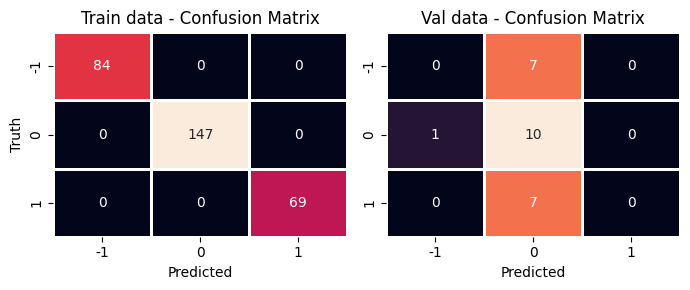

In [90]:
# plot the confusion metrics
plot_confusion_matrix(rf_wv, X_train_Word2Vec, y_train_en, X_val_Word2Vec, y_val_en)

**Observations**:

* Sentiments are predicted accurately on the training data.

* On the test data, only neutral sentiments are predicted reliably.

* Negative and positive sentiments are predicted poorly.

In [91]:
# Evaluate the metrics
model_classification_report(rf_wv, X_train_Word2Vec, y_train_en, X_val_Word2Vec, y_val_en)

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
RF_Default_Word2Vec,1.0,0.4,1.0,0.4,1.0,0.183333,1.0,0.251429


**Observations**:

* The model demonstrates strong performance on the training data.

* Performance on the validation data is poor.

* This indicates that the model is overfitting.

#### Random Forest - GloVe

In [92]:
### Random Forest model - word2vector
rf_gv = RandomForestClassifier(random_state=42)
rf_gv.name = "RF_Default_Glove"
rf_gv.fit(X_train_Glove,y_train_en)

RandomForestClassifier(random_state=42)

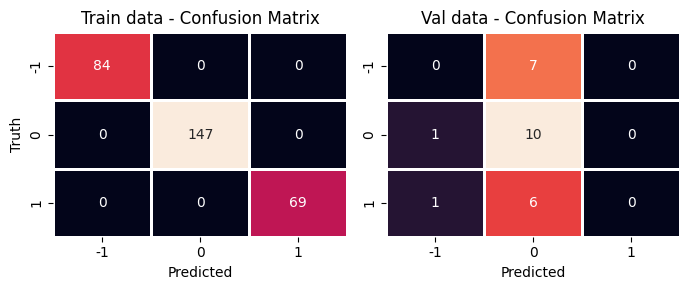

In [93]:
# plot the confusion metrics
plot_confusion_matrix(rf_gv, X_train_Glove, y_train_en, X_val_Glove, y_val_en)

**Observations**:
* The sentiments are predicted perfectly on training data.
* The positive and negative sentiment prediction test data is very poor.

In [94]:
# Evaluate the metrics
model_classification_report(rf_gv, X_train_Glove, y_train_en, X_val_Glove, y_val_en)

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
RF_Default_Glove,1.0,0.4,1.0,0.4,1.0,0.191304,1.0,0.258824


**Observations**:

* F1 score and accuracy showed slight improvement over the Word2Vec model on the validation data.

* However, the model continues to overfit.

#### Random Forest - Sentence Transformer

In [95]:
### Random Forest model - Sentence Transformer
rf_st = RandomForestClassifier(random_state=42)
rf_st.name = "RF_Default_SenTrans"
rf_st.fit(X_train_SenTrans,y_train_en)

RandomForestClassifier(random_state=42)

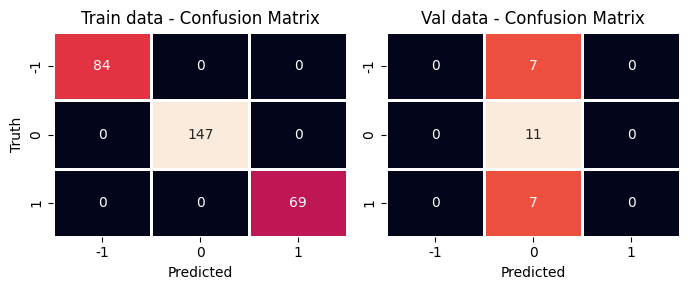

In [96]:
# plot the confusion metrics
plot_confusion_matrix(rf_st, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en)

* The sentiments are predicted perfectly on training data.
* The positive and negative sentiment prediction test data is very poor.

In [97]:
# Evaluate the metrics
model_classification_report(rf_st, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en)

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
RF_Default_SenTrans,1.0,0.44,1.0,0.44,1.0,0.1936,1.0,0.268889


* F1 score and accuracy showed slight improvement over the Word2Vec and Glove models on the validation data.

* However, the model continues to overfit.

### Extreme Gradient Boosting

#### XGB Word2Vec

In [98]:
# eXtreme Gradient Boosting model - Word2Vec
xgb_wv = XGBClassifier(random_state=42)
xgb_wv.name = "XGB_Word2Vec"
xgb_wv.fit(X_train_Word2Vec,y_train_en)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

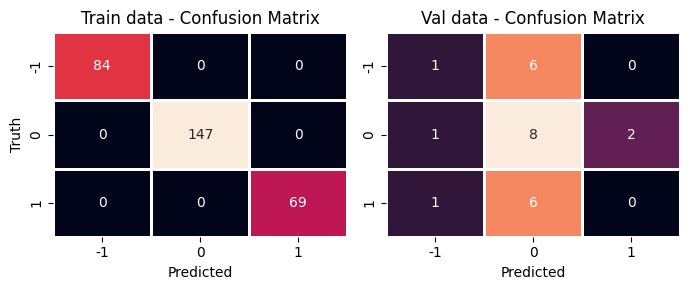

In [99]:
# plot confusion matrix
plot_confusion_matrix(xgb_wv, X_train_Word2Vec, y_train_en, X_val_Word2Vec, y_val_en)

**Observations**:
* The sentiments are predicted very well on the training data.
* The sentiments are poorly predicted on test data for negative and positive sentiments

In [100]:
# Evaluate metrics
model_classification_report(xgb_wv, X_train_Word2Vec, y_train_en, X_val_Word2Vec, y_val_en)

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
XGB_Word2Vec,1.0,0.36,1.0,0.36,1.0,0.269333,1.0,0.283097


**Observations**:
* F1 score is better than random forest model.
* The model is overfitting

#### XGB Glove

In [101]:
# eXtreme Gradient Boosting model - Glove
xgb_gv = XGBClassifier(random_state=42)
xgb_gv.name = "XGB_Word2Vec"
xgb_gv.fit(X_train_Glove,y_train_en)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

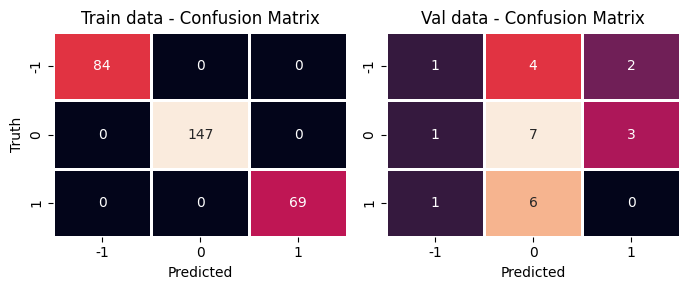

In [102]:
# plot confusion matrix
plot_confusion_matrix(xgb_gv, X_train_Glove, y_train_en, X_val_Glove, y_val_en)

**Observations**:
* The predictions are quite good on train data
* The predictions are poor on validation data

In [103]:
# Evaluate metrics
model_classification_report(xgb_gv, X_train_Glove, y_train_en, X_val_Glove, y_val_en)

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
XGB_Word2Vec,1.0,0.32,1.0,0.32,1.0,0.27451,1.0,0.276


**Observations**:
* The F1 score and accuracy slightly dropped compared to Word2Vec
* The model is in overfitting state

#### XGB Sentence Transformer

In [104]:
# eXtreme Gradient Boosting model
xgb_st = XGBClassifier(random_state=42)
xgb_st.name = "XGB_SenTrans"
xgb_st.fit(X_train_SenTrans,y_train_en)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

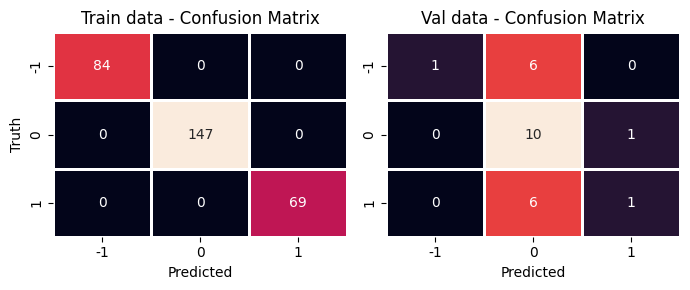

In [105]:
# plot confusion matrix
plot_confusion_matrix(xgb_st, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en)

* The predictions are quite good on train data
* The predictions are poor on validation data

In [106]:
# Evaluate metrics
model_classification_report(xgb_st, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en)

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
XGB_SenTrans,1.0,0.48,1.0,0.48,1.0,0.62,1.0,0.398889


**Observations**:
* The F1 score and accuracy are slightly improved over the Word2Vec and Glove models.
* The model is in overfitting state

### Random Forest Tuning

As the Sentence Transform embeddings are giving the better results , these vectors are considered in the tuning of the models

In [107]:
%%time
# Choose the type of classifier.
rf_estimator_tuned = RandomForestClassifier(random_state=42)

# Grid of parameters to choose from
## add from article
parameters = {
    'n_estimators': [50, 100],        # number of trees
    'max_depth': [4, 6],        # tree depth
    'min_samples_split': [5, 10],        # min samples to split
    'min_samples_leaf': [2, 4],          # min samples at leaf
    'max_features': ['sqrt', 'log2'],       # features considered per split
    'class_weight': ['balanced']      # useful if data is imbalanced
}

# Type of scoring used to compare parameter combinations
f1m_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring=f1m_scorer,cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_SenTrans, y_train_en)

# Set the clf to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_
rf_estimator_tuned.name="RF_Tuned_SenTrans"

# Fit the best algorithm to the data.
rf_estimator_tuned.fit(X_train_SenTrans, y_train_en)

CPU times: user 965 ms, sys: 58.8 ms, total: 1.02 s
Wall time: 30.1 s


RandomForestClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=50, random_state=42)

In [108]:
# print best params
grid_obj.best_params_

{'class_weight': 'balanced',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 50}

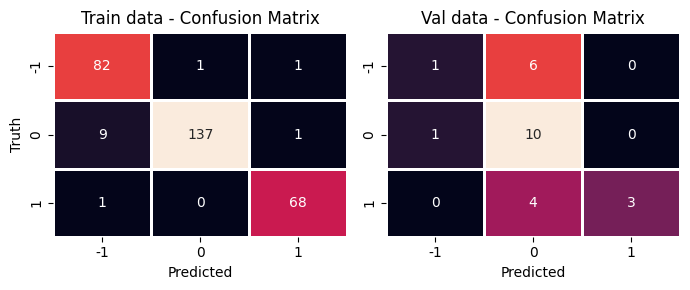

In [109]:
# plot the confusion matrix
plot_confusion_matrix(rf_estimator_tuned, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en)


In [110]:
# evaluate the metrics
model_classification_report(rf_estimator_tuned, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en)

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
RF_Tuned_SenTrans,0.956667,0.56,0.956667,0.56,0.959443,0.64,0.957033,0.514093


In [111]:
%%time
# XGB Classifier Tuning
xgb_tuned = XGBClassifier(random_state=42)

# Grid of parameters to choose from
## add from
parameters = {
    'max_depth': [3, 5],
    'min_child_weight': [7],
    'gamma': [0, 1],
    'subsample': [0.5],
    'colsample_bytree': [0.6],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
    'scale_pos_weight': [1, 2],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1]
}

# Type of scoring used to compare parameter combinations
mf1_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=mf1_scorer,cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_SenTrans, y_train_en)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_
xgb_tuned.name = "XGB_Tuned_SenTrans"

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train_SenTrans, y_train_en)

CPU times: user 3.35 s, sys: 279 ms, total: 3.63 s
Wall time: 4min 59s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [112]:
grid_obj.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 7,
 'n_estimators': 50,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.5}

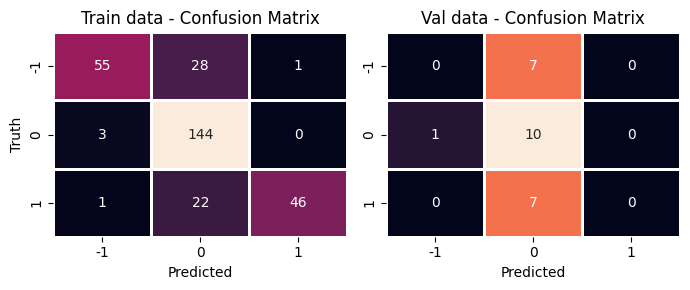

In [113]:
# plot the confusion matrix
plot_confusion_matrix(xgb_tuned, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en)

In [114]:
# evaluate the metrics
model_classification_report(xgb_tuned, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en)

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
XGB_Tuned_SenTrans,0.816667,0.4,0.816667,0.4,0.849835,0.183333,0.81164,0.251429


#### Model selection

In [115]:
# print the metrics for all the models
pd.concat(
    [
      model_classification_report(rf_wv, X_train_Word2Vec, y_train_en, X_val_Word2Vec, y_val_en),
      model_classification_report(rf_gv, X_train_Glove, y_train_en, X_val_Glove, y_val_en),
      model_classification_report(rf_st, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en),
      model_classification_report(xgb_wv, X_train_Word2Vec, y_train_en, X_val_Word2Vec, y_val_en),
      model_classification_report(xgb_gv, X_train_Glove, y_train_en, X_val_Glove, y_val_en),
      model_classification_report(xgb_st, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en),
      model_classification_report(rf_estimator_tuned, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en),
      model_classification_report(xgb_tuned, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en)
    ]
)

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
RF_Default_Word2Vec,1.000000,0.40,1.000000,0.40,1.000000,0.183333,1.000000,0.251429
RF_Default_Glove,1.000000,0.40,1.000000,0.40,1.000000,0.191304,1.000000,0.258824
RF_Default_SenTrans,1.000000,0.44,1.000000,0.44,1.000000,0.193600,1.000000,0.268889
XGB_Word2Vec,1.000000,0.36,1.000000,0.36,1.000000,0.269333,1.000000,0.283097
XGB_Word2Vec,1.000000,0.32,1.000000,0.32,1.000000,0.274510,1.000000,0.276000
XGB_SenTrans,1.000000,0.48,1.000000,0.48,1.000000,0.620000,1.000000,0.398889
RF_Tuned_SenTrans,0.956667,0.56,0.956667,0.56,0.959443,0.640000,0.957033,0.514093
XGB_Tuned_SenTrans,0.816667,0.40,0.816667,0.40,0.849835,0.183333,0.811640,0.251429


**Observations**:

* All models perform well on the training data but show poor metrics on the validation data.

* Among them, the tuned Random Forest model achieves comparatively better validation performance.

* The tuned Random Forest model has a higher F1 score, accuracy  than the others.

* All models exhibit overfitting.

As the tuned Random Forest is giving better results on Validation data, the model is selected and is evaluated on the test data.

In [116]:
# Encode the target variable for test data
y_test_en = labelEncoder.transform(y_test['Label'])

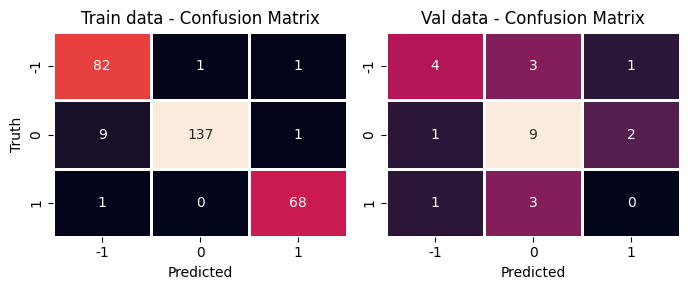

In [117]:
# plot the confusion matrix
plot_confusion_matrix(rf_estimator_tuned, X_train_SenTrans, y_train_en, X_test_SenTrans, y_test_en)

In [118]:
# Evaluate the model
model_classification_report(rf_estimator_tuned, X_train_SenTrans, y_train_en, X_test_SenTrans, y_test_en)

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
RF_Tuned_SenTrans,0.956667,0.541667,0.956667,0.541667,0.959443,0.522222,0.957033,0.52381


**Acionable Insights**:

* The model’s metrics (F1-score, precision, recall, and accuracy) are close to the validation results.

* The model exhibits significant overfitting.

* Further tuning is essential, including a wider range of hyperparameters and regularization techniques.

* Training on larger datasets is required.

* Alternative models, such as LLMs and Neural Networks, should be explored.

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [122]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.2.45 --force-reinstall --no-cache-dir -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 64.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 146.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 356.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 223.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 276.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.2 which is incompatible.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 2.3.2 which i

In [123]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

# Importing the json module
import json

#### Loading the data

In [124]:
# path to csv file
path = '/content/drive/MyDrive/NLP/stock_news.csv'

# import the dataset
from google.colab import drive
drive.mount('/content/drive')
stock_news = pd.read_csv(path)

data = stock_news.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,"Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets",41.740002,42.244999,41.482498,40.246914,130672400,-1


In [126]:
data.shape

(349, 8)

#### Loading the model

In [127]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
model_basename = "llama-2-13b-chat.Q5_K_M.gguf" # the model is in gguf format

In [128]:
# Using hf_hub_download to download a model from the Hugging Face model hub
# The repo_id parameter specifies the model name or path in the Hugging Face repository
# The filename parameter specifies the name of the file to download
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

In [129]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=-1,  # uncomment and change this value based on GPU VRAM pool.
    n_ctx=4096,  # Context window
    log_level="ERROR"
)

llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rope.dimension_

#### Aggregating the data weekly

In [130]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [131]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [132]:
# set pandas dataframe maxwidth to None
pd.set_option('max_colwidth',2000)

In [133]:
weekly_grouped.head()

,Date,News
0,2019-01-06,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January. || Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 || Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon || This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple || Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets || Apple CEO Tim Cook discussed the company's Q1 warning on CNBC, attributing US-China trade tensions as a factor. Despite not mentioning iPhone unit sales specifically, Cook indicated Apple may comment on them again. Services revenue is projected to exceed $10.8 billion in Q1. Cook also addressed the lack of || Roku Inc has announced plans to offer premium video channels on a subscription basis through its free streaming serv..."
1,2019-01-13,"Sprint and Samsung plan to release 5G smartphones in nine U.S. cities this summer, with Atlanta, Chicago, Dallas, Houston, Kansas City, Los Angeles, New York City, Phoenix, and Washington D.C. being the initial locations. Rival Verizon also announced similar plans for the first half of 20 || AMS, an Austrian tech company listed in Switzerland and a major supplier to Apple, has developed a light and infrared proximity sensor that can be placed behind a smartphone's screen. This allows for a larger display area by reducing the required space for sensors. AMS provides optical sensors for 3D facial recognition features on Apple || Deutsche Bank upgraded Vivendi's Universal Music Group valuation from €20 billion to €29 billion, surpassing the market cap of Vivendi at €28.3 billion. The bank anticipates music streaming revenue to reach €21 billion in 2023 and identifies potential suitors for || Amazon's stock is predicted to surge by over 20% by the end of this year, according to a new report from Pivotal Research. Senior analyst Brian Wieser initiated coverage on the stock with a buy rating and a year-end price target of $1,920. The growth potential for Amazon lies primarily in || AMS, an Austrian sensor specialist, is partnering with Chinese software maker Face to develop new 3D facial recognition features for smartphones. This move comes as AMS aims to reduce its dependence on Apple and boost its battered shares. AMS provides optical sensors for Apple's 3D facial recognition feature on iPhones, || Geely, China's most successful carmaker, forecasts flat sales for 2019 due to economic slowdown and cautious consumers. In 2018, it posted a 20% sales growth, but missed its target of 1.58 million cars by around 5%. Sales dropped 44 || China is making sincere efforts to address U.S. concerns and resolve the ongoing trade war, including lowering taxes on automobile imports and implementing a law banning forced technology transfers. However, Be

In [134]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are a financial sentiment analysis expert specializing in stock market news.

Task
Analyze the sentiment of the following stock market news headline or article and output STRICT JSON only.

Decision rubric
- Positive: Clear upside catalysts likely to lift prices (e.g., earnings beat, raised guidance, major contract win, regulatory approval, expansion, dividend/buyback increase, upgrade, strong outlook).
- Negative: Clear downside risks likely to pressure prices (e.g., earnings/revenue miss, guidance cut, layoffs, lawsuit/investigation, fines/sanctions, data breach, downgrade, bankruptcy/restructuring, product recall, strike, trade tensions).
- Neutral: Informational/mixed/uncertain (e.g., scheduling/appointments, rumors without confirmation, minor moves, balanced pros/cons, no directional catalyst).
- If any “hard negative” events are present (e.g., layoffs, guidance cut, probe, recall, sanctions, trade tensions, global economic slowdown), prefer Negative.
- Be conservative: if evidence is mixed or weak, choose Neutral (do NOT default to Positive).

Extraction instructions
1) Extract sentiment-bearing key events from the text and classify them into positive vs negative evidence.
2) Decide the final sentiment using the rubric above.

```

**Sample Output**:

```
  {"sentiment": "Positive | Negative | Neutral",

  "positive_keyevents": ["keyevent1", "keyevent2", "keyevent3"],

  "negative_keyevents": ["keyevent1", "keyevent2", "keyevent3"] }
```


In [135]:
# First prompt to extract key events
instruction_1 = """
You are a financial sentiment analysis expert specializing in stock market news.

Task:
Analyze the sentiment of the following stock market news headline or article and output STRICT JSON only.

Decision rubric
- Positive: Clear upside catalysts likely to lift prices (e.g., earnings beat, raised guidance, major contract win, regulatory approval, expansion, dividend/buyback increase, upgrade, strong outlook).
- Negative: Clear downside risks likely to pressure prices (e.g., earnings/revenue miss, guidance cut, layoffs, lawsuit/investigation, fines/sanctions, data breach, downgrade, bankruptcy/restructuring, product recall, strike, trade tensions).
- Neutral: Informational/mixed/uncertain (e.g., scheduling/appointments, rumors without confirmation, minor moves, balanced pros/cons, no directional catalyst).
- If any “hard negative” events are present (e.g., layoffs, guidance cut, probe, recall, sanctions, trade tensions, global economic slowdown), prefer Negative.
- Be conservative: if evidence is mixed or weak, choose Neutral (do NOT default to Positive).

Instructions:
1) Extract sentiment-bearing key events from the text and classify them into positive vs negative evidence.
2) Decide the final sentiment using the rubric above.

Format the output as a JSON object with the following structure:
{
  "sentiment": "Positive | Negative | Neutral",
  "keyevents": ["keyevent1", "keyevent2", "keyevent3"]
}
"""

In [136]:
# second prompt that will group the positive and negative events and also predict sentiment
instruction_2 = """

You are a financial sentiment analysis expert specializing in stock market news.

Task:
Based on the following key events extracted from multiple stock market news items, determine:
1. The **overall sentiment**: Positive, Negative, or Neutral.
2. How strong this sentiment is on a scale from 0 (very weak) to 1 (very strong), based on the consistency and polarity of the keywords.

Decision rubric:
- Positive: Clear upside catalysts likely to lift prices (e.g., earnings beat, raised guidance, major contract win, regulatory approval, expansion, dividend/buyback increase, upgrade, strong outlook).
- Negative: Clear downside risks likely to pressure prices (e.g., earnings/revenue miss, guidance cut, layoffs, lawsuit/investigation, fines/sanctions, data breach, downgrade, bankruptcy/restructuring, product recall, strike, trade tensions).
- Neutral: Informational/mixed/uncertain (e.g., scheduling/appointments, rumors without confirmation, minor moves, balanced pros/cons, no directional catalyst).
- When hard negatives are detected, sentiment should be Negative unless there is overwhelming evidence of Positive impact.
- Strength should reflect the dominance: set it ≥0.7 when hard negatives are present.

Instructions:
- Identify the top three positive and negative events from the week that are likely to impact the stock price as a list
- Weigh the frequency and polarity of keywords to determine the overall sentiment, giving higher priority to hard negatives.
- Keep the response concise and strictly in JSON format.

Format the output as:
{
  "sentiment": "your_overall_sentiment_prediction",
  "strength": 0.0 to 1.0,
  "positive_keyevents": ["event1","event2","event3"],
  "negative_keyevents": [event1","event2","event3"]
}
"""

##### Utility Functions

In [137]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

In [138]:
# Function that extract sentiment
def extract_sentiment(model_response):
    if 'Positive' in model_response:
        return 'Positive'
    elif 'Negative' in model_response:
        return 'Negative'
    elif 'Neutral' in model_response:
        return 'Neutral'

##### Defining the response function

In [139]:
# prepare the prompt
def generate_llama_response(instruction, review):

    # System message explicitly instructing not to include the review text
    system_message = """
        [INST]<<SYS>>
        {}
        <</SYS>>[/INST]
    """.format(instruction)

    # Combine user_prompt and system_message to create the prompt
    prompt = f"{review}\n{system_message}"

    # Generate a response from the LLaMA model
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=1024,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        top_k=50,
        stop=['INST'],
        echo=False,
        seed=42,
    )

    # Extract the sentiment from the response
    response_text = response["choices"][0]["text"]
    return response_text

##### Checking the model output on a sample

In [140]:
"""
As the comibined news is sometimes more than context lets split the news and
    extract the key events in each news. Then extract the key positive and negative events
    in the entire week
"""
def generate_llama_agg_response(instruction_1, instruction_2, reviews):
  delimiter = "||"
  news = reviews.split(delimiter)
  responses = []
  for tnew in news:
    response = generate_llama_response(instruction_1, tnew)
    print(f"Sentiment Analysis Response : {response}")
    response = extract_json_data(response)
    responses.append(response)
  print(f"Sentiment Analysis Responses : {responses}")
  return generate_llama_response(instruction_2, responses)

In [141]:
# Test the output on some sample news
news_test = """
The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon
"""
print(generate_llama_agg_response(instruction_1, instruction_2, news_test))


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      33.59 ms /    55 runs   (    0.61 ms per token,  1637.64 tokens per second)
llama_print_timings: prompt eval time =    1689.27 ms /   492 tokens (    3.43 ms per token,   291.25 tokens per second)
llama_print_timings:        eval time =    3678.68 ms /    54 runs   (   68.12 ms per token,    14.68 tokens per second)
llama_print_timings:       total time =    5587.06 ms /   546 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["downward revision of its revenue expectations", "significant decline in the aftermarket", "notable suppliers seeing their stocks drop"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      40.46 ms /    61 runs   (    0.66 ms per token,  1507.77 tokens per second)
llama_print_timings: prompt eval time =    1067.49 ms /   491 tokens (    2.17 ms per token,   459.96 tokens per second)
llama_print_timings:        eval time =    4151.80 ms /    60 runs   (   69.20 ms per token,    14.45 tokens per second)
llama_print_timings:       total time =    5509.49 ms /   551 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weaker than expected iPhone sales", "significant drop in Apple's stock price", "broader market declines for tech indices such as Nasdaq 10"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      27.34 ms /    50 runs   (    0.55 ms per token,  1828.62 tokens per second)
llama_print_timings: prompt eval time =    1091.11 ms /   489 tokens (    2.23 ms per token,   448.17 tokens per second)
llama_print_timings:        eval time =    3568.38 ms /    49 runs   (   72.82 ms per token,    13.73 tokens per second)
llama_print_timings:       total time =    4832.10 ms /   538 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weaker demand in China", "fewer iPhone upgrades", "constrained sales of AirPods and MacBooks"]
     }
Sentiment Analysis Responses : [{'sentiment': 'Negative', 'keyevents': ['downward revision of its revenue expectations', 'significant decline in the aftermarket', 'notable suppliers seeing their stocks drop']}, {'sentiment': 'Negative', 'keyevents': ['weaker than expected iPhone sales', "significant drop in Apple's stock price", 'broader market declines for tech indices such as Nasdaq 10']}, {'sentiment': 'Negative', 'keyevents': ['weaker demand in China', 'fewer iPhone upgrades', 'constrained sales of AirPods and MacBooks']}]



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      92.42 ms /   162 runs   (    0.57 ms per token,  1752.85 tokens per second)
llama_print_timings: prompt eval time =    1712.01 ms /   642 tokens (    2.67 ms per token,   375.00 tokens per second)
llama_print_timings:        eval time =   11758.97 ms /   161 runs   (   73.04 ms per token,    13.69 tokens per second)
llama_print_timings:       total time =   14174.46 ms /   803 tokens


 {
"sentiment": "Negative",
"strength": 0.8,
"positive_keyevents": ["no positive events"],
"negative_keyevents": ["weaker demand in China", "fewer iPhone upgrades", "constrained sales of AirPods and MacBooks"]
}

Based on the provided key events, the overall sentiment is Negative, with a strength of 0.8. There are no positive events identified. The key negative events that are likely to impact Apple's stock price include weaker demand in China, fewer iPhone upgrades, and constrained sales of AirPods and MacBooks. These events are consistent and have a high polarity, indicating a strong negative sentiment.


**Observations**:

The prompt is correctly analyzing the news and extracting the key events

In [142]:
# print the news for the first week
data_1.iloc[0]["News"]

' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [143]:
# get the output from the model on the first week
print(generate_llama_agg_response(instruction_1, instruction_2, data_1.iloc[0]["News"]))

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      37.91 ms /    55 runs   (    0.69 ms per token,  1450.65 tokens per second)
llama_print_timings: prompt eval time =    1036.54 ms /   490 tokens (    2.12 ms per token,   472.73 tokens per second)
llama_print_timings:        eval time =    3573.04 ms /    54 runs   (   66.17 ms per token,    15.11 tokens per second)
llama_print_timings:       total time =    4908.92 ms /   544 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["downward revision of its revenue expectations", "significant decline in the aftermarket", "notable suppliers seeing their stocks drop"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      34.03 ms /    61 runs   (    0.56 ms per token,  1792.38 tokens per second)
llama_print_timings: prompt eval time =    1045.66 ms /   491 tokens (    2.13 ms per token,   469.56 tokens per second)
llama_print_timings:        eval time =    4063.10 ms /    60 runs   (   67.72 ms per token,    14.77 tokens per second)
llama_print_timings:       total time =    5318.24 ms /   551 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weaker than expected iPhone sales", "significant drop in Apple's stock price", "broader market declines for tech indices such as Nasdaq 10"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      28.49 ms /    50 runs   (    0.57 ms per token,  1754.82 tokens per second)
llama_print_timings: prompt eval time =    1009.74 ms /   489 tokens (    2.06 ms per token,   484.28 tokens per second)
llama_print_timings:        eval time =    3256.10 ms /    49 runs   (   66.45 ms per token,    15.05 tokens per second)
llama_print_timings:       total time =    4446.04 ms /   538 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weaker demand in China", "fewer iPhone upgrades", "constrained sales of AirPods and MacBooks"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      45.99 ms /    66 runs   (    0.70 ms per token,  1435.00 tokens per second)
llama_print_timings: prompt eval time =    1008.30 ms /   485 tokens (    2.08 ms per token,   481.01 tokens per second)
llama_print_timings:        eval time =    4061.20 ms /    65 runs   (   62.48 ms per token,    16.01 tokens per second)
llama_print_timings:       total time =    5415.11 ms /   550 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["yields on long-dated US treasury securities hit their lowest levels in nearly a year", "concerns about the health of the global economy", "partial US government shutdown"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      27.59 ms /    50 runs   (    0.55 ms per token,  1812.25 tokens per second)
llama_print_timings: prompt eval time =    1004.55 ms /   492 tokens (    2.04 ms per token,   489.77 tokens per second)
llama_print_timings:        eval time =    3168.32 ms /    49 runs   (   64.66 ms per token,    15.47 tokens per second)
llama_print_timings:       total time =    4359.03 ms /   541 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple's revenue warning", "decline in USD/JPY pair", "gain in Japanese yen"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      41.44 ms /    64 runs   (    0.65 ms per token,  1544.48 tokens per second)
llama_print_timings: prompt eval time =    1002.73 ms /   488 tokens (    2.05 ms per token,   486.67 tokens per second)
llama_print_timings:        eval time =    3988.35 ms /    63 runs   (   63.31 ms per token,    15.80 tokens per second)
llama_print_timings:       total time =    5276.52 ms /   551 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple CEO Tim Cook discussed the company's Q1 warning on CNBC", "despite not mentioning iPhone unit sales specifically", "Cook indicated Apple may comment on them again"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      88.57 ms /   157 runs   (    0.56 ms per token,  1772.65 tokens per second)
llama_print_timings: prompt eval time =    1009.36 ms /   485 tokens (    2.08 ms per token,   480.50 tokens per second)
llama_print_timings:        eval time =   10046.52 ms /   156 runs   (   64.40 ms per token,    15.53 tokens per second)
llama_print_timings:       total time =   11678.84 ms /   641 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["CBS Corp's Showtime", "Lionsgate's Starz", "Viacom Inc's Noggin"]
}

The sentiment of the news headline is Positive because it highlights the addition of new premium video channels on Roku's free streaming service, which is likely to be a positive catalyst for the company's growth. The mention of well-known content providers like Showtime, Starz, and Noggin further supports this positive outlook. There are no clear downside risks or negative events mentioned in the headline.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      19.78 ms /    34 runs   (    0.58 ms per token,  1718.56 tokens per second)
llama_print_timings: prompt eval time =    1012.19 ms /   491 tokens (    2.06 ms per token,   485.09 tokens per second)
llama_print_timings:        eval time =    2004.86 ms /    33 runs   (   60.75 ms per token,    16.46 tokens per second)
llama_print_timings:       total time =    3213.95 ms /   524 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak demand in China", "global economic slowdown"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      27.16 ms /    50 runs   (    0.54 ms per token,  1841.15 tokens per second)
llama_print_timings: prompt eval time =     999.39 ms /   493 tokens (    2.03 ms per token,   493.30 tokens per second)
llama_print_timings:        eval time =    3249.86 ms /    49 runs   (   66.32 ms per token,    15.08 tokens per second)
llama_print_timings:       total time =    4421.19 ms /   542 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["lower iPhone revenue", "weaker-than-expected demand", "upgrade", "weakness in emerging markets"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      25.94 ms /    46 runs   (    0.56 ms per token,  1773.46 tokens per second)
llama_print_timings: prompt eval time =    1006.32 ms /   493 tokens (    2.04 ms per token,   489.90 tokens per second)
llama_print_timings:        eval time =    3004.61 ms /    45 runs   (   66.77 ms per token,    14.98 tokens per second)
llama_print_timings:       total time =    4174.77 ms /   538 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["Apple lowered its quarterly sales forecast", "slowing Chinese economy", "trade tensions"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      31.10 ms /    41 runs   (    0.76 ms per token,  1318.33 tokens per second)
llama_print_timings: prompt eval time =    1018.25 ms /   488 tokens (    2.09 ms per token,   479.25 tokens per second)
llama_print_timings:        eval time =    2544.91 ms /    40 runs   (   63.62 ms per token,    15.72 tokens per second)
llama_print_timings:       total time =    3785.11 ms /   528 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["automated selling", "liquidity issues", "drought of trades"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      99.57 ms /   166 runs   (    0.60 ms per token,  1667.12 tokens per second)
llama_print_timings: prompt eval time =    1026.16 ms /   491 tokens (    2.09 ms per token,   478.48 tokens per second)
llama_print_timings:        eval time =   11179.45 ms /   165 runs   (   67.75 ms per token,    14.76 tokens per second)
llama_print_timings:       total time =   12925.46 ms /   656 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["U.S. dollar and Australian dollar collapsed", "Apple's earnings warning of sluggish iPhone sales in China", "risk aversion"]
     }

The sentiment of the news headline is Negative because it mentions "collapsed" for both the U.S. dollar and Australian dollar, which implies significant downside pressure on prices. Additionally, the mention of "earnings warning" for Apple, which is one of the largest and most influential companies in the world, is also a strong negative factor. Finally, "risk aversion" is a negative sentiment driver that can exacerbate market volatility and negatively impact asset prices.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     157.73 ms /   273 runs   (    0.58 ms per token,  1730.83 tokens per second)
llama_print_timings: prompt eval time =    1023.65 ms /   488 tokens (    2.10 ms per token,   476.73 tokens per second)
llama_print_timings:        eval time =   18381.17 ms /   272 runs   (   67.58 ms per token,    14.80 tokens per second)
llama_print_timings:       total time =   20643.10 ms /   760 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple's revenue warning", "the 10-year Treasury yield also dropped", "money flowing into US government paper"]
     }

Here is my analysis of the given news headline:

The news headline mentions three key events:

1. Apple's revenue warning: This could be considered a negative event as it suggests that Apple may not meet its revenue expectations, which could negatively impact its stock price.
2. The 10-year Treasury yield dropping: This could be considered a neutral event as it is not necessarily a positive or negative factor for stock prices.
3. Money flowing into US government paper: This could be considered a neutral event as it is not necessarily a positive or negative factor for stock prices.

Based on these key events, I have classified the sentiment of the news headline as neutral. While there are some potential negative factors mentioned (Apple's revenue warning), they are balanced by neutral 


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      91.60 ms /   136 runs   (    0.67 ms per token,  1484.68 tokens per second)
llama_print_timings: prompt eval time =    1027.75 ms /   489 tokens (    2.10 ms per token,   475.80 tokens per second)
llama_print_timings:        eval time =    8913.71 ms /   135 runs   (   66.03 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =   10547.36 ms /   624 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["RBC Capital maintains its bullish stance on Apple", "oncoming iPhone demand concerns", "potential capital allocation adjustments"]
     }

The sentiment of the news headline is Neutral because while there is a mention of "bullish stance" which is a positive sentiment, it is balanced by the mention of "oncoming iPhone demand concerns" which is a negative sentiment. Additionally, the mention of "potential capital allocation adjustments" is neutral as it does not provide any clear directional catalyst for the stock.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      96.45 ms /   157 runs   (    0.61 ms per token,  1627.79 tokens per second)
llama_print_timings: prompt eval time =    1007.57 ms /   490 tokens (    2.06 ms per token,   486.32 tokens per second)
llama_print_timings:        eval time =   10160.05 ms /   156 runs   (   65.13 ms per token,    15.35 tokens per second)
llama_print_timings:       total time =   11893.08 ms /   646 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["oil prices dropped", "investor sentiment remained affected by China's economic slowdown", "turmoil in stock and currency markets"]
}

The news headline mentions that oil prices have dropped, which could be considered a negative event. However, the article also states that the drop is due to investor sentiment being affected by China's economic slowdown and turmoil in stock and currency markets, which is a neutral event. There are no clear upside or downside catalysts mentioned in the headline, so the overall sentiment is classified as neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     156.85 ms /   255 runs   (    0.62 ms per token,  1625.77 tokens per second)
llama_print_timings: prompt eval time =    1013.67 ms /   490 tokens (    2.07 ms per token,   483.39 tokens per second)
llama_print_timings:        eval time =   16492.69 ms /   254 runs   (   64.93 ms per token,    15.40 tokens per second)
llama_print_timings:       total time =   18751.49 ms /   744 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given stock market news headline:

{
"sentiment": "Negative",
"keyevents": ["Apple's revenue warning", "investor concerns about a slowing Chinese and global economy", "significant surge in the Japanese yen"]
}

Based on the given headline, I have identified the following key events:

1. Apple's revenue warning: This is a hard negative event as it indicates that Apple is facing challenges in terms of sales growth, which could negatively impact its stock price.
2. Investor concerns about a slowing Chinese and global economy: This is also a hard negative event as it suggests that there are macroeconomic risks that could impact the stock market as a whole.
3. Significant surge in the Japanese yen: This is a neutral event as it is simply a descriptive statement and does not provide any clear directional catalyst for stock prices.

Using the decision rubric provided, I have determined that the overall sentiment of the headline i


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      31.26 ms /    50 runs   (    0.63 ms per token,  1599.28 tokens per second)
llama_print_timings: prompt eval time =    1015.62 ms /   487 tokens (    2.09 ms per token,   479.51 tokens per second)
llama_print_timings:        eval time =    3171.70 ms /    49 runs   (   64.73 ms per token,    15.45 tokens per second)
llama_print_timings:       total time =    4431.19 ms /   536 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple lowered its revenue forecast", "Asian stocks declined", "gold and Japanese yen gained"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      38.67 ms /    60 runs   (    0.64 ms per token,  1551.47 tokens per second)
llama_print_timings: prompt eval time =    1019.55 ms /   490 tokens (    2.08 ms per token,   480.60 tokens per second)
llama_print_timings:        eval time =    3864.77 ms /    59 runs   (   65.50 ms per token,    15.27 tokens per second)
llama_print_timings:       total time =    5164.66 ms /   549 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Fears of a global economic slowdown", "led to a decline in the US dollar", "the yen gained ground due to its status as a safe haven currency"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      21.78 ms /    47 runs   (    0.46 ms per token,  2158.24 tokens per second)
llama_print_timings: prompt eval time =    1031.86 ms /   497 tokens (    2.08 ms per token,   481.66 tokens per second)
llama_print_timings:        eval time =    3102.48 ms /    46 runs   (   67.45 ms per token,    14.83 tokens per second)
llama_print_timings:       total time =    4315.27 ms /   543 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["Apple's warning of decreased revenue", "White House advisor adding to concerns of earnings down"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      62.08 ms /   123 runs   (    0.50 ms per token,  1981.38 tokens per second)
llama_print_timings: prompt eval time =    1021.42 ms /   484 tokens (    2.11 ms per token,   473.85 tokens per second)
llama_print_timings:        eval time =    8110.18 ms /   122 runs   (   66.48 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =    9689.09 ms /   606 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Gold prices have reached their highest level since mid-June", "investor concerns over a slowing economy", "Apple's bearish revenue outlook"]
     }

The sentiment of the news headline is Neutral because there are no clear upside catalysts or downside risks mentioned in the text. The key events mentioned are simply statements about gold prices and Apple's revenue outlook, which do not convey any strong positive or negative sentiment.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      42.61 ms /    75 runs   (    0.57 ms per token,  1760.23 tokens per second)
llama_print_timings: prompt eval time =    1020.11 ms /   488 tokens (    2.09 ms per token,   478.38 tokens per second)
llama_print_timings:        eval time =    5025.68 ms /    74 runs   (   67.91 ms per token,    14.72 tokens per second)
llama_print_timings:       total time =    6326.35 ms /   562 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Wedbush analyst Daniel Ives lowered his price target for Apple from $275 to $200", "estimated 750 million active iPhones worldwide that could cease growing or even decline"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      47.59 ms /    69 runs   (    0.69 ms per token,  1450.01 tokens per second)
llama_print_timings: prompt eval time =    1029.42 ms /   495 tokens (    2.08 ms per token,   480.85 tokens per second)
llama_print_timings:        eval time =    4439.59 ms /    68 runs   (   65.29 ms per token,    15.32 tokens per second)
llama_print_timings:       total time =    5809.07 ms /   563 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": [
         "signs of output cuts by Saudi Arabia",
         "weaker fuel oil margins leading Riyadh to lower February prices for heavier crude grades sold to Asia"
       ]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      38.59 ms /    71 runs   (    0.54 ms per token,  1839.76 tokens per second)
llama_print_timings: prompt eval time =    1015.09 ms /   489 tokens (    2.08 ms per token,   481.73 tokens per second)
llama_print_timings:        eval time =    4701.74 ms /    70 runs   (   67.17 ms per token,    14.89 tokens per second)
llama_print_timings:       total time =    5980.17 ms /   559 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["Apple's Q1 revenue warning", "Sesen Bio (SESN) stock price dropped by 28%", "Prana Biotechnology (PRAN) stock price dropped by 11%"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      36.10 ms /    46 runs   (    0.78 ms per token,  1274.31 tokens per second)
llama_print_timings: prompt eval time =    1012.39 ms /   488 tokens (    2.07 ms per token,   482.03 tokens per second)
llama_print_timings:        eval time =    2850.94 ms /    45 runs   (   63.35 ms per token,    15.78 tokens per second)
llama_print_timings:       total time =    4140.26 ms /   533 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["weak stock markets", "slumping dollar", "investors towards safe-haven assets"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     118.68 ms /   193 runs   (    0.61 ms per token,  1626.26 tokens per second)
llama_print_timings: prompt eval time =    1006.06 ms /   485 tokens (    2.07 ms per token,   482.08 tokens per second)
llama_print_timings:        eval time =   12624.66 ms /   192 runs   (   65.75 ms per token,    15.21 tokens per second)
llama_print_timings:       total time =   14497.28 ms /   677 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["FDIC Chair expresses no concern over market volatility", "review of CAMELS rating system"]
}

Based on my analysis, the sentiment of the news headline is Neutral as there are no clear upside catalysts or downside risks present in the text. The key events extracted from the text are:

* "FDIC Chair expresses no concern over market volatility" - This event is neutral as it does not indicate any clear directional catalysts for the stock market.
* "review of CAMELS rating system" - This event is neutral as it is an informational event that does not have any clear directional impact on stock prices.

Therefore, the final sentiment is Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      25.92 ms /    46 runs   (    0.56 ms per token,  1774.97 tokens per second)
llama_print_timings: prompt eval time =    1012.75 ms /   489 tokens (    2.07 ms per token,   482.84 tokens per second)
llama_print_timings:        eval time =    2992.01 ms /    45 runs   (   66.49 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =    4173.00 ms /   534 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak iPhone sales in China", "trade tensions with the US", "broader economic concerns in China"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.22 ms /    48 runs   (    0.55 ms per token,  1830.38 tokens per second)
llama_print_timings: prompt eval time =    1004.78 ms /   489 tokens (    2.05 ms per token,   486.67 tokens per second)
llama_print_timings:        eval time =    3130.56 ms /    47 runs   (   66.61 ms per token,    15.01 tokens per second)
llama_print_timings:       total time =    4307.96 ms /   536 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["reduced revenue estimate", "lowered price target", "potential risks to 2019 numbers"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      77.04 ms /   129 runs   (    0.60 ms per token,  1674.50 tokens per second)
llama_print_timings: prompt eval time =    1012.97 ms /   489 tokens (    2.07 ms per token,   482.74 tokens per second)
llama_print_timings:        eval time =    8327.44 ms /   128 runs   (   65.06 ms per token,    15.37 tokens per second)
llama_print_timings:       total time =    9951.84 ms /   617 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["Delta Air Lines lowered its fourth-quarter revenue growth forecast", "earnings per share are now expected to be $1.25 to $1.30"]
     }

The sentiment of the news headline is Negative because Delta Air Lines has lowered its fourth-quarter revenue growth forecast, indicating potential downside risks for investors. This outweighs any potential positive catalysts mentioned in the article, such as earnings per share expectations.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     142.74 ms /   230 runs   (    0.62 ms per token,  1611.32 tokens per second)
llama_print_timings: prompt eval time =    1008.50 ms /   487 tokens (    2.07 ms per token,   482.89 tokens per second)
llama_print_timings:        eval time =   15014.52 ms /   229 runs   (   65.57 ms per token,    15.25 tokens per second)
llama_print_timings:       total time =   17094.17 ms /   716 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure, I can help you with that! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple's profit warning", "significantly impacted the stock market", "changed the outlook for interest rates"]
}

Based on the given headline, I have identified three key events:

1. Apple's profit warning
2. Significantly impacted the stock market
3. Changed the outlook for interest rates

Of these, two events are neutral (#2 and #3) as they describe the effects of the profit warning on the stock market and interest rates, respectively, without expressing any clear positive or negative sentiment. Event #1 (Apple's profit warning) could be considered a negative event, but since it is not explicitly stated as such, I have classified it as neutral as well.

Therefore, the overall sentiment of the headline is Neutral, as there are no clear positive or negative catalysts mentioned.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      49.13 ms /    72 runs   (    0.68 ms per token,  1465.50 tokens per second)
llama_print_timings: prompt eval time =    1010.73 ms /   488 tokens (    2.07 ms per token,   482.82 tokens per second)
llama_print_timings:        eval time =    4529.15 ms /    71 runs   (   63.79 ms per token,    15.68 tokens per second)
llama_print_timings:       total time =    5916.30 ms /   559 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Kevin Hassett stated that a decline in Chinese economic growth would negatively impact US firm profits", "However, he also noted that a trade deal between Washington and Beijing could lead to a recovery in US firm profits"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      27.80 ms /    47 runs   (    0.59 ms per token,  1690.89 tokens per second)
llama_print_timings: prompt eval time =    1012.80 ms /   490 tokens (    2.07 ms per token,   483.81 tokens per second)
llama_print_timings:        eval time =    3063.76 ms /    46 runs   (   66.60 ms per token,    15.01 tokens per second)
llama_print_timings:       total time =    4259.27 ms /   536 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["White House economic advisor Kevin Hassett warning of potential earnings downgrades", "decline in oil prices"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      23.93 ms /    42 runs   (    0.57 ms per token,  1754.90 tokens per second)
llama_print_timings: prompt eval time =    1007.84 ms /   488 tokens (    2.07 ms per token,   484.20 tokens per second)
llama_print_timings:        eval time =    2744.87 ms /    41 runs   (   66.95 ms per token,    14.94 tokens per second)
llama_print_timings:       total time =    3914.69 ms /   529 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak iPhone sales in China", "global growth concerns", "technology shares tumbling"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      31.99 ms /    46 runs   (    0.70 ms per token,  1437.99 tokens per second)
llama_print_timings: prompt eval time =    1015.74 ms /   490 tokens (    2.07 ms per token,   482.41 tokens per second)
llama_print_timings:        eval time =    2893.44 ms /    45 runs   (   64.30 ms per token,    15.55 tokens per second)
llama_print_timings:       total time =    4149.15 ms /   535 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["fears of aggressive monetary policy", "economic slowdown", "iPhone sales"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      29.48 ms /    48 runs   (    0.61 ms per token,  1628.39 tokens per second)
llama_print_timings: prompt eval time =    1009.14 ms /   486 tokens (    2.08 ms per token,   481.60 tokens per second)
llama_print_timings:        eval time =    3133.73 ms /    47 runs   (   66.68 ms per token,    15.00 tokens per second)
llama_print_timings:       total time =    4328.96 ms /   533 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weaker demand in China", "estimated $3.8 billion paper loss", "broad market declines"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     133.09 ms /   215 runs   (    0.62 ms per token,  1615.48 tokens per second)
llama_print_timings: prompt eval time =    1016.96 ms /   490 tokens (    2.08 ms per token,   481.83 tokens per second)
llama_print_timings:        eval time =   14300.12 ms /   214 runs   (   66.82 ms per token,    14.96 tokens per second)
llama_print_timings:       total time =   16233.72 ms /   704 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Wish Wu planned to present on how to bypass Apple's Face ID biometric security", "Apple's Face ID biometric security", "Ant Financial asked him to withdraw the presentation"]
}

Based on the given headline, there are two key events:

1. Wish Wu planned to present on how to bypass Apple's Face ID biometric security - This event is neutral as it is an informational event and does not have any clear directional catalyst.
2. Ant Financial asked him to withdraw the presentation - This event has a negative connotation as it suggests that there may be downside risks for Apple's Face ID biometric security.

Overall, the sentiment of the headline is Neutral as there is no clear positive or negative catalyst presented in the text.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     178.48 ms /   288 runs   (    0.62 ms per token,  1613.66 tokens per second)
llama_print_timings: prompt eval time =    1021.32 ms /   491 tokens (    2.08 ms per token,   480.75 tokens per second)
llama_print_timings:        eval time =   19094.15 ms /   287 runs   (   66.53 ms per token,    15.03 tokens per second)
llama_print_timings:       total time =   21427.27 ms /   778 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["OPEC's production cuts", "uncertainty", "stock markets", "Apple's lowered revenue forecast", "global economic slowdown"]
     }

The sentiment of the news headline is Neutral because it mentions several negative events (OPEC's production cuts, uncertainty, stock markets declining) without any clear positive catalysts to offset them. The key events that contributed to the neutral sentiment are:

1. OPEC's production cuts: This is a negative event as it may lead to a decrease in oil supply and potentially drive up prices.
2. Uncertainty: This is a negative event as it can create a lack of confidence in the market and lead to decreased investment.
3. Stock markets declining: This is a negative event as it can indicate a decrease in investor confidence and a potential downturn in the economy.
4. Apple's lowered revenue forecast: This is a negative event as it may indicate a decrease in demand for the comp


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      24.58 ms /    45 runs   (    0.55 ms per token,  1830.91 tokens per second)
llama_print_timings: prompt eval time =    1018.64 ms /   488 tokens (    2.09 ms per token,   479.07 tokens per second)
llama_print_timings:        eval time =    2954.21 ms /    44 runs   (   67.14 ms per token,    14.89 tokens per second)
llama_print_timings:       total time =    4138.34 ms /   532 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["decline in Apple stock", "potential unrealized investment losses", "push Berk 
       
       
       "sentiment": "Negative",
       "keyevents": ["decline in Apple stock", "potential unrealized investment losses", "push Berk 
       
       



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      82.56 ms /   122 runs   (    0.68 ms per token,  1477.78 tokens per second)
llama_print_timings: prompt eval time =    1021.27 ms /   489 tokens (    2.09 ms per token,   478.81 tokens per second)
llama_print_timings:        eval time =    7916.58 ms /   121 runs   (   65.43 ms per token,    15.28 tokens per second)
llama_print_timings:       total time =    9533.21 ms /   610 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["two-year Treasury note yield drop", "Federal Reserve's effective rate", "investors belief"]
     }

The sentiment of the given news headline is Neutral because it does not contain any clear upside or downside catalysts. The headline simply states a market move and an investor belief, which are informational and do not convey a strong directional bias. Therefore, none of the criteria in the positive or negative categories are met.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     118.60 ms /   209 runs   (    0.57 ms per token,  1762.29 tokens per second)
llama_print_timings: prompt eval time =    1011.64 ms /   486 tokens (    2.08 ms per token,   480.41 tokens per second)
llama_print_timings:        eval time =   13903.55 ms /   208 runs   (   66.84 ms per token,    14.96 tokens per second)
llama_print_timings:       total time =   15810.80 ms /   694 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure, I can assist you with that! Here's my analysis of the given news headline:

Headline: "U.S. and China to Hold First Face-to-Face Trade Talks Since Truce"

Based on the given headline, I have extracted the following sentiment-bearing key events:

1. "first face-to-face trade talks since truce" (Positive)
2. "U.S.-China trade war" (Neutral)

Using the decision rubric provided, I would classify the overall sentiment of the headline as Neutral, as there is no clear upside catalyst or downside risk mentioned in the headline.

Here's the JSON output:

{
"sentiment": "Neutral",
"keyevents": ["first face-to-face trade talks since truce", "U.S.-China trade war"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      97.54 ms /   156 runs   (    0.63 ms per token,  1599.36 tokens per second)
llama_print_timings: prompt eval time =    1019.22 ms /   486 tokens (    2.10 ms per token,   476.84 tokens per second)
llama_print_timings:        eval time =   10233.72 ms /   155 runs   (   66.02 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =   11952.01 ms /   641 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["increased uncertainty in the stock market", "potential Fed rate hikes"]
}

The news headline mentions "increased uncertainty in the stock market" which is a neutral event as it does not provide any clear directional catalyst for investors. Additionally, "potential Fed rate hikes" could be seen as a negative event as it may lead to higher borrowing costs for companies and potentially slow down economic growth. However, without any clear indication of an imminent rate hike or any other major negative event, the overall sentiment is classified as neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      22.88 ms /    51 runs   (    0.45 ms per token,  2229.41 tokens per second)
llama_print_timings: prompt eval time =    1016.87 ms /   489 tokens (    2.08 ms per token,   480.89 tokens per second)
llama_print_timings:        eval time =    3392.22 ms /    50 runs   (   67.84 ms per token,    14.74 tokens per second)
llama_print_timings:       total time =    4587.35 ms /   539 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["lower-than-expected fourth quarter unit revenue growth", "weaker than anticipated late bookings", "increased competition"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      27.99 ms /    39 runs   (    0.72 ms per token,  1393.30 tokens per second)
llama_print_timings: prompt eval time =    1015.28 ms /   489 tokens (    2.08 ms per token,   481.64 tokens per second)
llama_print_timings:        eval time =    2401.20 ms /    38 runs   (   63.19 ms per token,    15.83 tokens per second)
llama_print_timings:       total time =    3640.96 ms /   527 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak revenue from Apple", "slowing U.S. factory activity"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      29.01 ms /    53 runs   (    0.55 ms per token,  1827.21 tokens per second)
llama_print_timings: prompt eval time =    1013.66 ms /   486 tokens (    2.09 ms per token,   479.45 tokens per second)
llama_print_timings:        eval time =    3509.86 ms /    52 runs   (   67.50 ms per token,    14.82 tokens per second)
llama_print_timings:       total time =    4709.86 ms /   538 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["President Trump expressed optimism over potential trade talks with China", "recent reports of weakened demand for Apple iPhones in China"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     150.93 ms /   243 runs   (    0.62 ms per token,  1610.02 tokens per second)
llama_print_timings: prompt eval time =    1018.70 ms /   486 tokens (    2.10 ms per token,   477.08 tokens per second)
llama_print_timings:        eval time =   16098.56 ms /   242 runs   (   66.52 ms per token,    15.03 tokens per second)
llama_print_timings:       total time =   18180.78 ms /   728 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Qualcomm secures court order banning sales of some iPhone models", "Apple continues to sell affected iPhones through third-party resellers"]
}

Based on the given headline, I have identified two key events:

1. "Qualcomm secures court order banning sales of some iPhone models" - This event has a negative connotation as it implies that Apple's products are being restricted or banned.
2. "Apple continues to sell affected iPhones through third-party resellers" - This event has a neutral connotation as it simply states that Apple is still selling their products despite the court order.

Using the decision rubric provided, I have determined that the overall sentiment of the headline is Neutral as there are no clear upside or downside catalysts present. The negative event of the court order being issued against Apple is balanced by the neutral event of Apple continuin


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     169.26 ms /   284 runs   (    0.60 ms per token,  1677.93 tokens per second)
llama_print_timings: prompt eval time =    1014.81 ms /   490 tokens (    2.07 ms per token,   482.85 tokens per second)
llama_print_timings:        eval time =   18756.90 ms /   283 runs   (   66.28 ms per token,    15.09 tokens per second)
llama_print_timings:       total time =   21071.76 ms /   773 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure, I can help you with that! Here's my analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["China's Commerce Ministry announced that deputy U.S. Trade Representative Jeffrey Gerrish will visit Beijing for talks", "the visit is seen as a sign of progress in trade negotiations between the two countries"]
}

Based on the given headline, I have extracted two key events:

1. China's Commerce Ministry announced that deputy U.S. Trade Representative Jeffrey Gerrish will visit Beijing for talks.
2. The visit is seen as a sign of progress in trade negotiations between the two countries.

Using the decision rubric provided, I have classified these key events as follows:

1. China's Commerce Ministry announcing the visit is a positive event, as it suggests that both countries are actively engaging in trade negotiations.
2. The visit being seen as a sign of progress is also a positive event, as it implies that there is a likelihood of a 


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     151.65 ms /   310 runs   (    0.49 ms per token,  2044.25 tokens per second)
llama_print_timings: prompt eval time =    1011.24 ms /   487 tokens (    2.08 ms per token,   481.59 tokens per second)
llama_print_timings:        eval time =   20562.53 ms /   309 runs   (   66.55 ms per token,    15.03 tokens per second)
llama_print_timings:       total time =   22935.24 ms /   796 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["gold prices surged", "weak PMIs from China", "Apple's reduced quarterly sales forecast"]
}

The news headline mentions three key events:

1. "Gold prices surged" - This could be considered a positive event for investors who hold gold assets, but it does not provide any clear upside catalyst for the price increase. Therefore, I have classified this event as neutral.
2. "Weak PMIs from China" - This is a negative event as it suggests that the Chinese economy may be slowing down, which could have a ripple effect on the global economy and financial markets.
3. "Apple's reduced quarterly sales forecast" - This is also a negative event as it suggests that one of the world's largest and most profitable companies is experiencing weaker demand for its products, which could be a sign of an economic slowdown or other negative factors affecting consumer spending power.

Ov


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     120.70 ms /   201 runs   (    0.60 ms per token,  1665.22 tokens per second)
llama_print_timings: prompt eval time =    1014.78 ms /   486 tokens (    2.09 ms per token,   478.92 tokens per second)
llama_print_timings:        eval time =   13252.48 ms /   200 runs   (   66.26 ms per token,    15.09 tokens per second)
llama_print_timings:       total time =   15138.87 ms /   686 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment in the given news headline:

Headline: Huawei's Mistake Uses an iPhone in Tweet Causes Damage to Brand

Based on the given headline, I have extracted the following sentiment-bearing key events:

* Mistake in using an iPhone in a tweet
* Damage to the brand

Using the decision rubric provided, I have classified these key events as follows:

* Mistake in using an iPhone in a tweet: Negative
* Damage to the brand: Negative

Therefore, the final sentiment of the headline is:

{
"sentiment": "Negative | Negative",
"keyevents": ["mistake in using an iPhone", "damage to the brand"]
}

Please note that this is a strict JSON output as requested.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.32 ms /    49 runs   (    0.54 ms per token,  1861.70 tokens per second)
llama_print_timings: prompt eval time =    1017.50 ms /   494 tokens (    2.06 ms per token,   485.50 tokens per second)
llama_print_timings:        eval time =    3215.36 ms /    48 runs   (   66.99 ms per token,    14.93 tokens per second)
llama_print_timings:       total time =    4428.33 ms /   542 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["trade war talks", "European stock markets", "carmakers", "mining companies", "banking"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      88.50 ms /   146 runs   (    0.61 ms per token,  1649.70 tokens per second)
llama_print_timings: prompt eval time =    1012.57 ms /   487 tokens (    2.08 ms per token,   480.95 tokens per second)
llama_print_timings:        eval time =    9551.86 ms /   145 runs   (   65.87 ms per token,    15.18 tokens per second)
llama_print_timings:       total time =   11224.17 ms /   632 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the sentiment of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Amazon has sold over 100 million devices with its Alexa digital assistant", "the company is cautious about releasing hardware sales figures"]
}

Based on the given headline, there are no clear upside or downside catalysts that suggest a positive or negative sentiment. Instead, the headline highlights a neutral piece of information about Amazon's device sales and the company's caution regarding hardware sales figures. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      27.48 ms /    49 runs   (    0.56 ms per token,  1782.86 tokens per second)
llama_print_timings: prompt eval time =    1012.29 ms /   487 tokens (    2.08 ms per token,   481.09 tokens per second)
llama_print_timings:        eval time =    3195.04 ms /    48 runs   (   66.56 ms per token,    15.02 tokens per second)
llama_print_timings:       total time =    4384.77 ms /   535 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Broadcom's appeal", "shareholder lawsuit", "Emulex investor", "class action lawsuit"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      80.16 ms /   128 runs   (    0.63 ms per token,  1596.77 tokens per second)
llama_print_timings: prompt eval time =    1010.97 ms /   485 tokens (    2.08 ms per token,   479.74 tokens per second)
llama_print_timings:        eval time =    8315.46 ms /   127 runs   (   65.48 ms per token,    15.27 tokens per second)
llama_print_timings:       total time =    9912.18 ms /   612 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Chinese central bank announces RRR cut", "economic growth slowing", "U.S. tariffs on exports"]
     }

The sentiment of the news headline is Neutral because while there is a potential upside catalyst with the RRR cut, there are also downside risks associated with slowing economic growth and U.S. tariffs on exports. These risks outweigh any potential benefits from the RRR cut, resulting in a neutral sentiment overall.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.51 ms /    46 runs   (    0.58 ms per token,  1735.06 tokens per second)
llama_print_timings: prompt eval time =    1008.48 ms /   485 tokens (    2.08 ms per token,   480.92 tokens per second)
llama_print_timings:        eval time =    3013.84 ms /    45 runs   (   66.97 ms per token,    14.93 tokens per second)
llama_print_timings:       total time =    4187.36 ms /   530 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["better-than-expected jobs report", "dovish comments from Federal Reserve Chairman Jerome Powell"]
     }
Sentiment Analysis Responses : [{'sentiment': 'Negative', 'keyevents': ['downward revision of its revenue expectations', 'significant decline in the aftermarket', 'notable suppliers seeing their stocks drop']}, {'sentiment': 'Negative', 'keyevents': ['weaker than expected iPhone sales', "significant drop in Apple's stock price", 'broader market declines for tech indices such as Nasdaq 10']}, {'sentiment': 'Negative', 'keyevents': ['weaker demand in China', 'fewer iPhone upgrades', 'constrained sales of AirPods and MacBooks']}, {'sentiment': 'Neutral', 'keyevents': ['yields on long-dated US treasury securities hit their lowest levels in nearly a year', 'concerns about the health of the global economy', 'partial US government shutdown']}, {'sentiment': 'Neutral', 'keyevents': ["Apple's revenue warni


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     105.86 ms /   194 runs   (    0.55 ms per token,  1832.63 tokens per second)
llama_print_timings: prompt eval time =    6453.43 ms /  2787 tokens (    2.32 ms per token,   431.86 tokens per second)
llama_print_timings:        eval time =   14703.63 ms /   193 runs   (   76.18 ms per token,    13.13 tokens per second)
llama_print_timings:       total time =   22126.54 ms /  2980 tokens


 Sure, I can assist you with that! Based on the key events provided, here is my analysis:

{
"sentiment": "Neutral",
"strength": 0.5,
"positive_keyevents": ["Apple's revenue warning", "trade talks", "gold prices surged"],
"negative_keyevents": ["weak iPhone sales", "global economic slowdown", "Apple's lowered quarterly sales forecast"]
}

Overall sentiment is Neutral, with a strength of 0.5. The positive key events include Apple's revenue warning, trade talks, and gold prices surged, while the negative key events include weak iPhone sales, global economic slowdown, and Apple's lowered quarterly sales forecast. The strength is moderate, indicating that there are both positive and negative factors at play.


**Observations**:

* The prompt provided to the model effectively analyzes the news.

* It extracts the key positive and negative events relevant to sentiment prediction.

* It accurately predicts the sentiment.

##### Checking the model output on the weekly data

In [144]:
# Get the model response and store it
data_1['model_response'] = data_1['News'].apply(lambda x: generate_llama_agg_response(instruction_1, instruction_2, x))

Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      31.54 ms /    55 runs   (    0.57 ms per token,  1743.87 tokens per second)
llama_print_timings: prompt eval time =    1008.72 ms /   490 tokens (    2.06 ms per token,   485.76 tokens per second)
llama_print_timings:        eval time =    3617.93 ms /    54 runs   (   67.00 ms per token,    14.93 tokens per second)
llama_print_timings:       total time =    4835.07 ms /   544 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["downward revision of its revenue expectations", "significant decline in the aftermarket", "notable suppliers seeing their stocks drop"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      40.39 ms /    61 runs   (    0.66 ms per token,  1510.42 tokens per second)
llama_print_timings: prompt eval time =    1009.20 ms /   491 tokens (    2.06 ms per token,   486.52 tokens per second)
llama_print_timings:        eval time =    3871.61 ms /    60 runs   (   64.53 ms per token,    15.50 tokens per second)
llama_print_timings:       total time =    5182.06 ms /   551 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weaker than expected iPhone sales", "significant drop in Apple's stock price", "broader market declines for tech indices such as Nasdaq 10"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      28.10 ms /    50 runs   (    0.56 ms per token,  1779.36 tokens per second)
llama_print_timings: prompt eval time =    1014.05 ms /   489 tokens (    2.07 ms per token,   482.23 tokens per second)
llama_print_timings:        eval time =    3283.01 ms /    49 runs   (   67.00 ms per token,    14.93 tokens per second)
llama_print_timings:       total time =    4476.34 ms /   538 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weaker demand in China", "fewer iPhone upgrades", "constrained sales of AirPods and MacBooks"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      42.09 ms /    66 runs   (    0.64 ms per token,  1567.88 tokens per second)
llama_print_timings: prompt eval time =    1001.65 ms /   485 tokens (    2.07 ms per token,   484.20 tokens per second)
llama_print_timings:        eval time =    4242.27 ms /    65 runs   (   65.27 ms per token,    15.32 tokens per second)
llama_print_timings:       total time =    5543.29 ms /   550 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["yields on long-dated US treasury securities hit their lowest levels in nearly a year", "concerns about the health of the global economy", "partial US government shutdown"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      28.50 ms /    50 runs   (    0.57 ms per token,  1754.08 tokens per second)
llama_print_timings: prompt eval time =    1016.44 ms /   492 tokens (    2.07 ms per token,   484.04 tokens per second)
llama_print_timings:        eval time =    3260.42 ms /    49 runs   (   66.54 ms per token,    15.03 tokens per second)
llama_print_timings:       total time =    4465.18 ms /   541 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple's revenue warning", "decline in USD/JPY pair", "gain in Japanese yen"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      36.60 ms /    64 runs   (    0.57 ms per token,  1748.78 tokens per second)
llama_print_timings: prompt eval time =    1005.90 ms /   488 tokens (    2.06 ms per token,   485.14 tokens per second)
llama_print_timings:        eval time =    4223.48 ms /    63 runs   (   67.04 ms per token,    14.92 tokens per second)
llama_print_timings:       total time =    5457.49 ms /   551 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple CEO Tim Cook discussed the company's Q1 warning on CNBC", "despite not mentioning iPhone unit sales specifically", "Cook indicated Apple may comment on them again"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      99.66 ms /   157 runs   (    0.63 ms per token,  1575.31 tokens per second)
llama_print_timings: prompt eval time =    1005.99 ms /   485 tokens (    2.07 ms per token,   482.11 tokens per second)
llama_print_timings:        eval time =   10296.52 ms /   156 runs   (   66.00 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =   11996.48 ms /   641 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["CBS Corp's Showtime", "Lionsgate's Starz", "Viacom Inc's Noggin"]
}

The sentiment of the news headline is Positive because it highlights the addition of new premium video channels on Roku's free streaming service, which is likely to be a positive catalyst for the company's growth. The mention of well-known content providers like Showtime, Starz, and Noggin further supports this positive outlook. There are no clear downside risks or negative events mentioned in the headline.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      16.18 ms /    34 runs   (    0.48 ms per token,  2100.84 tokens per second)
llama_print_timings: prompt eval time =    1010.03 ms /   491 tokens (    2.06 ms per token,   486.12 tokens per second)
llama_print_timings:        eval time =    2187.02 ms /    33 runs   (   66.27 ms per token,    15.09 tokens per second)
llama_print_timings:       total time =    3332.92 ms /   524 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak demand in China", "global economic slowdown"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      32.76 ms /    50 runs   (    0.66 ms per token,  1526.07 tokens per second)
llama_print_timings: prompt eval time =    1012.02 ms /   493 tokens (    2.05 ms per token,   487.14 tokens per second)
llama_print_timings:        eval time =    3158.66 ms /    49 runs   (   64.46 ms per token,    15.51 tokens per second)
llama_print_timings:       total time =    4404.96 ms /   542 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["lower iPhone revenue", "weaker-than-expected demand", "upgrade", "weakness in emerging markets"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.32 ms /    46 runs   (    0.57 ms per token,  1747.79 tokens per second)
llama_print_timings: prompt eval time =    1016.22 ms /   493 tokens (    2.06 ms per token,   485.13 tokens per second)
llama_print_timings:        eval time =    3020.67 ms /    45 runs   (   67.13 ms per token,    14.90 tokens per second)
llama_print_timings:       total time =    4201.65 ms /   538 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["Apple lowered its quarterly sales forecast", "slowing Chinese economy", "trade tensions"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      23.54 ms /    41 runs   (    0.57 ms per token,  1741.94 tokens per second)
llama_print_timings: prompt eval time =    1015.13 ms /   488 tokens (    2.08 ms per token,   480.73 tokens per second)
llama_print_timings:        eval time =    2670.14 ms /    40 runs   (   66.75 ms per token,    14.98 tokens per second)
llama_print_timings:       total time =    3834.43 ms /   528 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["automated selling", "liquidity issues", "drought of trades"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     100.66 ms /   166 runs   (    0.61 ms per token,  1649.15 tokens per second)
llama_print_timings: prompt eval time =    1009.21 ms /   491 tokens (    2.06 ms per token,   486.52 tokens per second)
llama_print_timings:        eval time =   10910.00 ms /   165 runs   (   66.12 ms per token,    15.12 tokens per second)
llama_print_timings:       total time =   12639.74 ms /   656 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["U.S. dollar and Australian dollar collapsed", "Apple's earnings warning of sluggish iPhone sales in China", "risk aversion"]
     }

The sentiment of the news headline is Negative because it mentions "collapsed" for both the U.S. dollar and Australian dollar, which implies significant downside pressure on prices. Additionally, the mention of "earnings warning" for Apple, which is one of the largest and most influential companies in the world, is also a strong negative factor. Finally, "risk aversion" is a negative sentiment driver that can exacerbate market volatility and negatively impact asset prices.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     157.93 ms /   273 runs   (    0.58 ms per token,  1728.62 tokens per second)
llama_print_timings: prompt eval time =    1010.89 ms /   488 tokens (    2.07 ms per token,   482.74 tokens per second)
llama_print_timings:        eval time =   17964.72 ms /   272 runs   (   66.05 ms per token,    15.14 tokens per second)
llama_print_timings:       total time =   20216.24 ms /   760 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple's revenue warning", "the 10-year Treasury yield also dropped", "money flowing into US government paper"]
     }

Here is my analysis of the given news headline:

The news headline mentions three key events:

1. Apple's revenue warning: This could be considered a negative event as it suggests that Apple may not meet its revenue expectations, which could negatively impact its stock price.
2. The 10-year Treasury yield dropping: This could be considered a neutral event as it is not necessarily a positive or negative factor for stock prices.
3. Money flowing into US government paper: This could be considered a neutral event as it is not necessarily a positive or negative factor for stock prices.

Based on these key events, I have classified the sentiment of the news headline as neutral. While there are some potential negative factors mentioned (Apple's revenue warning), they are balanced by neutral 


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      86.02 ms /   136 runs   (    0.63 ms per token,  1581.01 tokens per second)
llama_print_timings: prompt eval time =    1013.62 ms /   489 tokens (    2.07 ms per token,   482.43 tokens per second)
llama_print_timings:        eval time =    8898.22 ms /   135 runs   (   65.91 ms per token,    15.17 tokens per second)
llama_print_timings:       total time =   10535.66 ms /   624 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["RBC Capital maintains its bullish stance on Apple", "oncoming iPhone demand concerns", "potential capital allocation adjustments"]
     }

The sentiment of the news headline is Neutral because while there is a mention of "bullish stance" which is a positive sentiment, it is balanced by the mention of "oncoming iPhone demand concerns" which is a negative sentiment. Additionally, the mention of "potential capital allocation adjustments" is neutral as it does not provide any clear directional catalyst for the stock.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      96.43 ms /   157 runs   (    0.61 ms per token,  1628.07 tokens per second)
llama_print_timings: prompt eval time =    1008.40 ms /   490 tokens (    2.06 ms per token,   485.92 tokens per second)
llama_print_timings:        eval time =   10290.54 ms /   156 runs   (   65.97 ms per token,    15.16 tokens per second)
llama_print_timings:       total time =   11980.22 ms /   646 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["oil prices dropped", "investor sentiment remained affected by China's economic slowdown", "turmoil in stock and currency markets"]
}

The news headline mentions that oil prices have dropped, which could be considered a negative event. However, the article also states that the drop is due to investor sentiment being affected by China's economic slowdown and turmoil in stock and currency markets, which is a neutral event. There are no clear upside or downside catalysts mentioned in the headline, so the overall sentiment is classified as neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     154.97 ms /   255 runs   (    0.61 ms per token,  1645.49 tokens per second)
llama_print_timings: prompt eval time =    1010.66 ms /   490 tokens (    2.06 ms per token,   484.83 tokens per second)
llama_print_timings:        eval time =   16798.66 ms /   254 runs   (   66.14 ms per token,    15.12 tokens per second)
llama_print_timings:       total time =   18955.51 ms /   744 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given stock market news headline:

{
"sentiment": "Negative",
"keyevents": ["Apple's revenue warning", "investor concerns about a slowing Chinese and global economy", "significant surge in the Japanese yen"]
}

Based on the given headline, I have identified the following key events:

1. Apple's revenue warning: This is a hard negative event as it indicates that Apple is facing challenges in terms of sales growth, which could negatively impact its stock price.
2. Investor concerns about a slowing Chinese and global economy: This is also a hard negative event as it suggests that there are macroeconomic risks that could impact the stock market as a whole.
3. Significant surge in the Japanese yen: This is a neutral event as it is simply a descriptive statement and does not provide any clear directional catalyst for stock prices.

Using the decision rubric provided, I have determined that the overall sentiment of the headline i


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      27.83 ms /    50 runs   (    0.56 ms per token,  1796.75 tokens per second)
llama_print_timings: prompt eval time =    1007.91 ms /   487 tokens (    2.07 ms per token,   483.18 tokens per second)
llama_print_timings:        eval time =    3267.28 ms /    49 runs   (   66.68 ms per token,    15.00 tokens per second)
llama_print_timings:       total time =    4456.94 ms /   536 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple lowered its revenue forecast", "Asian stocks declined", "gold and Japanese yen gained"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      44.41 ms /    60 runs   (    0.74 ms per token,  1351.17 tokens per second)
llama_print_timings: prompt eval time =    1009.70 ms /   490 tokens (    2.06 ms per token,   485.29 tokens per second)
llama_print_timings:        eval time =    3763.26 ms /    59 runs   (   63.78 ms per token,    15.68 tokens per second)
llama_print_timings:       total time =    5101.71 ms /   549 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Fears of a global economic slowdown", "led to a decline in the US dollar", "the yen gained ground due to its status as a safe haven currency"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      21.02 ms /    47 runs   (    0.45 ms per token,  2235.97 tokens per second)
llama_print_timings: prompt eval time =    1019.32 ms /   497 tokens (    2.05 ms per token,   487.58 tokens per second)
llama_print_timings:        eval time =    3092.61 ms /    46 runs   (   67.23 ms per token,    14.87 tokens per second)
llama_print_timings:       total time =    4280.32 ms /   543 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["Apple's warning of decreased revenue", "White House advisor adding to concerns of earnings down"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      61.98 ms /   123 runs   (    0.50 ms per token,  1984.35 tokens per second)
llama_print_timings: prompt eval time =    1011.19 ms /   484 tokens (    2.09 ms per token,   478.65 tokens per second)
llama_print_timings:        eval time =    8027.11 ms /   122 runs   (   65.80 ms per token,    15.20 tokens per second)
llama_print_timings:       total time =    9588.12 ms /   606 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Gold prices have reached their highest level since mid-June", "investor concerns over a slowing economy", "Apple's bearish revenue outlook"]
     }

The sentiment of the news headline is Neutral because there are no clear upside catalysts or downside risks mentioned in the text. The key events mentioned are simply statements about gold prices and Apple's revenue outlook, which do not convey any strong positive or negative sentiment.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      43.06 ms /    75 runs   (    0.57 ms per token,  1741.92 tokens per second)
llama_print_timings: prompt eval time =    1009.16 ms /   488 tokens (    2.07 ms per token,   483.57 tokens per second)
llama_print_timings:        eval time =    4960.48 ms /    74 runs   (   67.03 ms per token,    14.92 tokens per second)
llama_print_timings:       total time =    6248.21 ms /   562 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Wedbush analyst Daniel Ives lowered his price target for Apple from $275 to $200", "estimated 750 million active iPhones worldwide that could cease growing or even decline"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      50.62 ms /    69 runs   (    0.73 ms per token,  1363.21 tokens per second)
llama_print_timings: prompt eval time =    1018.93 ms /   495 tokens (    2.06 ms per token,   485.81 tokens per second)
llama_print_timings:        eval time =    4406.19 ms /    68 runs   (   64.80 ms per token,    15.43 tokens per second)
llama_print_timings:       total time =    5790.20 ms /   563 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": [
         "signs of output cuts by Saudi Arabia",
         "weaker fuel oil margins leading Riyadh to lower February prices for heavier crude grades sold to Asia"
       ]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      38.66 ms /    71 runs   (    0.54 ms per token,  1836.33 tokens per second)
llama_print_timings: prompt eval time =    1014.06 ms /   489 tokens (    2.07 ms per token,   482.22 tokens per second)
llama_print_timings:        eval time =    4715.37 ms /    70 runs   (   67.36 ms per token,    14.85 tokens per second)
llama_print_timings:       total time =    5987.43 ms /   559 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["Apple's Q1 revenue warning", "Sesen Bio (SESN) stock price dropped by 28%", "Prana Biotechnology (PRAN) stock price dropped by 11%"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      27.09 ms /    46 runs   (    0.59 ms per token,  1697.86 tokens per second)
llama_print_timings: prompt eval time =    1011.69 ms /   488 tokens (    2.07 ms per token,   482.36 tokens per second)
llama_print_timings:        eval time =    3005.75 ms /    45 runs   (   66.79 ms per token,    14.97 tokens per second)
llama_print_timings:       total time =    4190.46 ms /   533 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["weak stock markets", "slumping dollar", "investors towards safe-haven assets"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     126.09 ms /   193 runs   (    0.65 ms per token,  1530.63 tokens per second)
llama_print_timings: prompt eval time =    1008.95 ms /   485 tokens (    2.08 ms per token,   480.70 tokens per second)
llama_print_timings:        eval time =   12653.03 ms /   192 runs   (   65.90 ms per token,    15.17 tokens per second)
llama_print_timings:       total time =   14574.00 ms /   677 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["FDIC Chair expresses no concern over market volatility", "review of CAMELS rating system"]
}

Based on my analysis, the sentiment of the news headline is Neutral as there are no clear upside catalysts or downside risks present in the text. The key events extracted from the text are:

* "FDIC Chair expresses no concern over market volatility" - This event is neutral as it does not indicate any clear directional catalysts for the stock market.
* "review of CAMELS rating system" - This event is neutral as it is an informational event that does not have any clear directional impact on stock prices.

Therefore, the final sentiment is Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      28.02 ms /    46 runs   (    0.61 ms per token,  1641.86 tokens per second)
llama_print_timings: prompt eval time =    1018.27 ms /   489 tokens (    2.08 ms per token,   480.23 tokens per second)
llama_print_timings:        eval time =    2965.47 ms /    45 runs   (   65.90 ms per token,    15.17 tokens per second)
llama_print_timings:       total time =    4189.06 ms /   534 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak iPhone sales in China", "trade tensions with the US", "broader economic concerns in China"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.30 ms /    48 runs   (    0.55 ms per token,  1825.16 tokens per second)
llama_print_timings: prompt eval time =    1019.15 ms /   489 tokens (    2.08 ms per token,   479.81 tokens per second)
llama_print_timings:        eval time =    3161.26 ms /    47 runs   (   67.26 ms per token,    14.87 tokens per second)
llama_print_timings:       total time =    4353.68 ms /   536 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["reduced revenue estimate", "lowered price target", "potential risks to 2019 numbers"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      78.93 ms /   129 runs   (    0.61 ms per token,  1634.44 tokens per second)
llama_print_timings: prompt eval time =    1011.40 ms /   489 tokens (    2.07 ms per token,   483.49 tokens per second)
llama_print_timings:        eval time =    8450.96 ms /   128 runs   (   66.02 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =   10057.73 ms /   617 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["Delta Air Lines lowered its fourth-quarter revenue growth forecast", "earnings per share are now expected to be $1.25 to $1.30"]
     }

The sentiment of the news headline is Negative because Delta Air Lines has lowered its fourth-quarter revenue growth forecast, indicating potential downside risks for investors. This outweighs any potential positive catalysts mentioned in the article, such as earnings per share expectations.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     141.77 ms /   230 runs   (    0.62 ms per token,  1622.32 tokens per second)
llama_print_timings: prompt eval time =    1009.18 ms /   487 tokens (    2.07 ms per token,   482.57 tokens per second)
llama_print_timings:        eval time =   15257.25 ms /   229 runs   (   66.63 ms per token,    15.01 tokens per second)
llama_print_timings:       total time =   17284.55 ms /   716 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure, I can help you with that! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple's profit warning", "significantly impacted the stock market", "changed the outlook for interest rates"]
}

Based on the given headline, I have identified three key events:

1. Apple's profit warning
2. Significantly impacted the stock market
3. Changed the outlook for interest rates

Of these, two events are neutral (#2 and #3) as they describe the effects of the profit warning on the stock market and interest rates, respectively, without expressing any clear positive or negative sentiment. Event #1 (Apple's profit warning) could be considered a negative event, but since it is not explicitly stated as such, I have classified it as neutral as well.

Therefore, the overall sentiment of the headline is Neutral, as there are no clear positive or negative catalysts mentioned.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      49.83 ms /    72 runs   (    0.69 ms per token,  1444.85 tokens per second)
llama_print_timings: prompt eval time =    1013.85 ms /   488 tokens (    2.08 ms per token,   481.34 tokens per second)
llama_print_timings:        eval time =    4566.39 ms /    71 runs   (   64.32 ms per token,    15.55 tokens per second)
llama_print_timings:       total time =    5962.51 ms /   559 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Kevin Hassett stated that a decline in Chinese economic growth would negatively impact US firm profits", "However, he also noted that a trade deal between Washington and Beijing could lead to a recovery in US firm profits"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.46 ms /    47 runs   (    0.56 ms per token,  1775.93 tokens per second)
llama_print_timings: prompt eval time =    1016.54 ms /   490 tokens (    2.07 ms per token,   482.03 tokens per second)
llama_print_timings:        eval time =    3094.46 ms /    46 runs   (   67.27 ms per token,    14.87 tokens per second)
llama_print_timings:       total time =    4281.23 ms /   536 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["White House economic advisor Kevin Hassett warning of potential earnings downgrades", "decline in oil prices"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      23.89 ms /    42 runs   (    0.57 ms per token,  1757.91 tokens per second)
llama_print_timings: prompt eval time =    1006.81 ms /   488 tokens (    2.06 ms per token,   484.70 tokens per second)
llama_print_timings:        eval time =    2749.17 ms /    41 runs   (   67.05 ms per token,    14.91 tokens per second)
llama_print_timings:       total time =    3910.61 ms /   529 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak iPhone sales in China", "global growth concerns", "technology shares tumbling"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      35.09 ms /    46 runs   (    0.76 ms per token,  1311.03 tokens per second)
llama_print_timings: prompt eval time =    1011.24 ms /   490 tokens (    2.06 ms per token,   484.55 tokens per second)
llama_print_timings:        eval time =    2867.70 ms /    45 runs   (   63.73 ms per token,    15.69 tokens per second)
llama_print_timings:       total time =    4147.68 ms /   535 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["fears of aggressive monetary policy", "economic slowdown", "iPhone sales"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.62 ms /    48 runs   (    0.55 ms per token,  1802.95 tokens per second)
llama_print_timings: prompt eval time =    1007.98 ms /   486 tokens (    2.07 ms per token,   482.15 tokens per second)
llama_print_timings:        eval time =    3132.09 ms /    47 runs   (   66.64 ms per token,    15.01 tokens per second)
llama_print_timings:       total time =    4320.64 ms /   533 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weaker demand in China", "estimated $3.8 billion paper loss", "broad market declines"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     131.06 ms /   215 runs   (    0.61 ms per token,  1640.43 tokens per second)
llama_print_timings: prompt eval time =    1013.49 ms /   490 tokens (    2.07 ms per token,   483.48 tokens per second)
llama_print_timings:        eval time =   14226.75 ms /   214 runs   (   66.48 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =   16185.69 ms /   704 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Wish Wu planned to present on how to bypass Apple's Face ID biometric security", "Apple's Face ID biometric security", "Ant Financial asked him to withdraw the presentation"]
}

Based on the given headline, there are two key events:

1. Wish Wu planned to present on how to bypass Apple's Face ID biometric security - This event is neutral as it is an informational event and does not have any clear directional catalyst.
2. Ant Financial asked him to withdraw the presentation - This event has a negative connotation as it suggests that there may be downside risks for Apple's Face ID biometric security.

Overall, the sentiment of the headline is Neutral as there is no clear positive or negative catalyst presented in the text.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     181.55 ms /   288 runs   (    0.63 ms per token,  1586.36 tokens per second)
llama_print_timings: prompt eval time =    1019.80 ms /   491 tokens (    2.08 ms per token,   481.47 tokens per second)
llama_print_timings:        eval time =   18918.56 ms /   287 runs   (   65.92 ms per token,    15.17 tokens per second)
llama_print_timings:       total time =   21315.96 ms /   778 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["OPEC's production cuts", "uncertainty", "stock markets", "Apple's lowered revenue forecast", "global economic slowdown"]
     }

The sentiment of the news headline is Neutral because it mentions several negative events (OPEC's production cuts, uncertainty, stock markets declining) without any clear positive catalysts to offset them. The key events that contributed to the neutral sentiment are:

1. OPEC's production cuts: This is a negative event as it may lead to a decrease in oil supply and potentially drive up prices.
2. Uncertainty: This is a negative event as it can create a lack of confidence in the market and lead to decreased investment.
3. Stock markets declining: This is a negative event as it can indicate a decrease in investor confidence and a potential downturn in the economy.
4. Apple's lowered revenue forecast: This is a negative event as it may indicate a decrease in demand for the comp


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      24.15 ms /    45 runs   (    0.54 ms per token,  1863.66 tokens per second)
llama_print_timings: prompt eval time =    1013.93 ms /   488 tokens (    2.08 ms per token,   481.29 tokens per second)
llama_print_timings:        eval time =    2948.29 ms /    44 runs   (   67.01 ms per token,    14.92 tokens per second)
llama_print_timings:       total time =    4118.34 ms /   532 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["decline in Apple stock", "potential unrealized investment losses", "push Berk 
       
       
       "sentiment": "Negative",
       "keyevents": ["decline in Apple stock", "potential unrealized investment losses", "push Berk 
       
       



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      79.39 ms /   122 runs   (    0.65 ms per token,  1536.74 tokens per second)
llama_print_timings: prompt eval time =    1009.99 ms /   489 tokens (    2.07 ms per token,   484.16 tokens per second)
llama_print_timings:        eval time =    7942.51 ms /   121 runs   (   65.64 ms per token,    15.23 tokens per second)
llama_print_timings:       total time =    9507.41 ms /   610 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["two-year Treasury note yield drop", "Federal Reserve's effective rate", "investors belief"]
     }

The sentiment of the given news headline is Neutral because it does not contain any clear upside or downside catalysts. The headline simply states a market move and an investor belief, which are informational and do not convey a strong directional bias. Therefore, none of the criteria in the positive or negative categories are met.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     120.91 ms /   209 runs   (    0.58 ms per token,  1728.60 tokens per second)
llama_print_timings: prompt eval time =    1010.44 ms /   486 tokens (    2.08 ms per token,   480.98 tokens per second)
llama_print_timings:        eval time =   13828.58 ms /   208 runs   (   66.48 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =   15738.71 ms /   694 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure, I can assist you with that! Here's my analysis of the given news headline:

Headline: "U.S. and China to Hold First Face-to-Face Trade Talks Since Truce"

Based on the given headline, I have extracted the following sentiment-bearing key events:

1. "first face-to-face trade talks since truce" (Positive)
2. "U.S.-China trade war" (Neutral)

Using the decision rubric provided, I would classify the overall sentiment of the headline as Neutral, as there is no clear upside catalyst or downside risk mentioned in the headline.

Here's the JSON output:

{
"sentiment": "Neutral",
"keyevents": ["first face-to-face trade talks since truce", "U.S.-China trade war"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     100.13 ms /   156 runs   (    0.64 ms per token,  1557.97 tokens per second)
llama_print_timings: prompt eval time =    1009.05 ms /   486 tokens (    2.08 ms per token,   481.64 tokens per second)
llama_print_timings:        eval time =   10253.53 ms /   155 runs   (   66.15 ms per token,    15.12 tokens per second)
llama_print_timings:       total time =   11939.73 ms /   641 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["increased uncertainty in the stock market", "potential Fed rate hikes"]
}

The news headline mentions "increased uncertainty in the stock market" which is a neutral event as it does not provide any clear directional catalyst for investors. Additionally, "potential Fed rate hikes" could be seen as a negative event as it may lead to higher borrowing costs for companies and potentially slow down economic growth. However, without any clear indication of an imminent rate hike or any other major negative event, the overall sentiment is classified as neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      22.47 ms /    51 runs   (    0.44 ms per token,  2270.00 tokens per second)
llama_print_timings: prompt eval time =    1017.40 ms /   489 tokens (    2.08 ms per token,   480.64 tokens per second)
llama_print_timings:        eval time =    3349.13 ms /    50 runs   (   66.98 ms per token,    14.93 tokens per second)
llama_print_timings:       total time =    4547.50 ms /   539 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["lower-than-expected fourth quarter unit revenue growth", "weaker than anticipated late bookings", "increased competition"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      24.44 ms /    39 runs   (    0.63 ms per token,  1595.68 tokens per second)
llama_print_timings: prompt eval time =    1014.32 ms /   489 tokens (    2.07 ms per token,   482.10 tokens per second)
llama_print_timings:        eval time =    2497.05 ms /    38 runs   (   65.71 ms per token,    15.22 tokens per second)
llama_print_timings:       total time =    3682.49 ms /   527 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak revenue from Apple", "slowing U.S. factory activity"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      33.19 ms /    53 runs   (    0.63 ms per token,  1596.77 tokens per second)
llama_print_timings: prompt eval time =    1008.17 ms /   486 tokens (    2.07 ms per token,   482.06 tokens per second)
llama_print_timings:        eval time =    3402.55 ms /    52 runs   (   65.43 ms per token,    15.28 tokens per second)
llama_print_timings:       total time =    4646.90 ms /   538 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["President Trump expressed optimism over potential trade talks with China", "recent reports of weakened demand for Apple iPhones in China"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     151.29 ms /   243 runs   (    0.62 ms per token,  1606.21 tokens per second)
llama_print_timings: prompt eval time =    1011.61 ms /   486 tokens (    2.08 ms per token,   480.42 tokens per second)
llama_print_timings:        eval time =   16190.83 ms /   242 runs   (   66.90 ms per token,    14.95 tokens per second)
llama_print_timings:       total time =   18228.01 ms /   728 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Qualcomm secures court order banning sales of some iPhone models", "Apple continues to sell affected iPhones through third-party resellers"]
}

Based on the given headline, I have identified two key events:

1. "Qualcomm secures court order banning sales of some iPhone models" - This event has a negative connotation as it implies that Apple's products are being restricted or banned.
2. "Apple continues to sell affected iPhones through third-party resellers" - This event has a neutral connotation as it simply states that Apple is still selling their products despite the court order.

Using the decision rubric provided, I have determined that the overall sentiment of the headline is Neutral as there are no clear upside or downside catalysts present. The negative event of the court order being issued against Apple is balanced by the neutral event of Apple continuin


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     167.33 ms /   284 runs   (    0.59 ms per token,  1697.28 tokens per second)
llama_print_timings: prompt eval time =    1015.97 ms /   490 tokens (    2.07 ms per token,   482.30 tokens per second)
llama_print_timings:        eval time =   18864.05 ms /   283 runs   (   66.66 ms per token,    15.00 tokens per second)
llama_print_timings:       total time =   21181.15 ms /   773 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure, I can help you with that! Here's my analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["China's Commerce Ministry announced that deputy U.S. Trade Representative Jeffrey Gerrish will visit Beijing for talks", "the visit is seen as a sign of progress in trade negotiations between the two countries"]
}

Based on the given headline, I have extracted two key events:

1. China's Commerce Ministry announced that deputy U.S. Trade Representative Jeffrey Gerrish will visit Beijing for talks.
2. The visit is seen as a sign of progress in trade negotiations between the two countries.

Using the decision rubric provided, I have classified these key events as follows:

1. China's Commerce Ministry announcing the visit is a positive event, as it suggests that both countries are actively engaging in trade negotiations.
2. The visit being seen as a sign of progress is also a positive event, as it implies that there is a likelihood of a 


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     147.64 ms /   310 runs   (    0.48 ms per token,  2099.74 tokens per second)
llama_print_timings: prompt eval time =    1010.97 ms /   487 tokens (    2.08 ms per token,   481.71 tokens per second)
llama_print_timings:        eval time =   20777.14 ms /   309 runs   (   67.24 ms per token,    14.87 tokens per second)
llama_print_timings:       total time =   23086.83 ms /   796 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["gold prices surged", "weak PMIs from China", "Apple's reduced quarterly sales forecast"]
}

The news headline mentions three key events:

1. "Gold prices surged" - This could be considered a positive event for investors who hold gold assets, but it does not provide any clear upside catalyst for the price increase. Therefore, I have classified this event as neutral.
2. "Weak PMIs from China" - This is a negative event as it suggests that the Chinese economy may be slowing down, which could have a ripple effect on the global economy and financial markets.
3. "Apple's reduced quarterly sales forecast" - This is also a negative event as it suggests that one of the world's largest and most profitable companies is experiencing weaker demand for its products, which could be a sign of an economic slowdown or other negative factors affecting consumer spending power.

Ov


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     123.27 ms /   201 runs   (    0.61 ms per token,  1630.59 tokens per second)
llama_print_timings: prompt eval time =    1012.00 ms /   486 tokens (    2.08 ms per token,   480.24 tokens per second)
llama_print_timings:        eval time =   13343.91 ms /   200 runs   (   66.72 ms per token,    14.99 tokens per second)
llama_print_timings:       total time =   15236.49 ms /   686 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment in the given news headline:

Headline: Huawei's Mistake Uses an iPhone in Tweet Causes Damage to Brand

Based on the given headline, I have extracted the following sentiment-bearing key events:

* Mistake in using an iPhone in a tweet
* Damage to the brand

Using the decision rubric provided, I have classified these key events as follows:

* Mistake in using an iPhone in a tweet: Negative
* Damage to the brand: Negative

Therefore, the final sentiment of the headline is:

{
"sentiment": "Negative | Negative",
"keyevents": ["mistake in using an iPhone", "damage to the brand"]
}

Please note that this is a strict JSON output as requested.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.32 ms /    49 runs   (    0.54 ms per token,  1861.49 tokens per second)
llama_print_timings: prompt eval time =    1018.70 ms /   494 tokens (    2.06 ms per token,   484.93 tokens per second)
llama_print_timings:        eval time =    3246.86 ms /    48 runs   (   67.64 ms per token,    14.78 tokens per second)
llama_print_timings:       total time =    4441.52 ms /   542 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["trade war talks", "European stock markets", "carmakers", "mining companies", "banking"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      89.26 ms /   146 runs   (    0.61 ms per token,  1635.69 tokens per second)
llama_print_timings: prompt eval time =    1018.86 ms /   487 tokens (    2.09 ms per token,   477.99 tokens per second)
llama_print_timings:        eval time =    9637.29 ms /   145 runs   (   66.46 ms per token,    15.05 tokens per second)
llama_print_timings:       total time =   11307.72 ms /   632 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the sentiment of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Amazon has sold over 100 million devices with its Alexa digital assistant", "the company is cautious about releasing hardware sales figures"]
}

Based on the given headline, there are no clear upside or downside catalysts that suggest a positive or negative sentiment. Instead, the headline highlights a neutral piece of information about Amazon's device sales and the company's caution regarding hardware sales figures. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.98 ms /    49 runs   (    0.55 ms per token,  1816.50 tokens per second)
llama_print_timings: prompt eval time =    1014.63 ms /   487 tokens (    2.08 ms per token,   479.98 tokens per second)
llama_print_timings:        eval time =    3261.66 ms /    48 runs   (   67.95 ms per token,    14.72 tokens per second)
llama_print_timings:       total time =    4443.10 ms /   535 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Broadcom's appeal", "shareholder lawsuit", "Emulex investor", "class action lawsuit"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      80.15 ms /   128 runs   (    0.63 ms per token,  1596.99 tokens per second)
llama_print_timings: prompt eval time =    1009.79 ms /   485 tokens (    2.08 ms per token,   480.30 tokens per second)
llama_print_timings:        eval time =    8358.47 ms /   127 runs   (   65.81 ms per token,    15.19 tokens per second)
llama_print_timings:       total time =    9966.57 ms /   612 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Chinese central bank announces RRR cut", "economic growth slowing", "U.S. tariffs on exports"]
     }

The sentiment of the news headline is Neutral because while there is a potential upside catalyst with the RRR cut, there are also downside risks associated with slowing economic growth and U.S. tariffs on exports. These risks outweigh any potential benefits from the RRR cut, resulting in a neutral sentiment overall.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      29.45 ms /    46 runs   (    0.64 ms per token,  1561.92 tokens per second)
llama_print_timings: prompt eval time =    1002.58 ms /   485 tokens (    2.07 ms per token,   483.75 tokens per second)
llama_print_timings:        eval time =    2932.02 ms /    45 runs   (   65.16 ms per token,    15.35 tokens per second)
llama_print_timings:       total time =    4162.45 ms /   530 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["better-than-expected jobs report", "dovish comments from Federal Reserve Chairman Jerome Powell"]
     }
Sentiment Analysis Responses : [{'sentiment': 'Negative', 'keyevents': ['downward revision of its revenue expectations', 'significant decline in the aftermarket', 'notable suppliers seeing their stocks drop']}, {'sentiment': 'Negative', 'keyevents': ['weaker than expected iPhone sales', "significant drop in Apple's stock price", 'broader market declines for tech indices such as Nasdaq 10']}, {'sentiment': 'Negative', 'keyevents': ['weaker demand in China', 'fewer iPhone upgrades', 'constrained sales of AirPods and MacBooks']}, {'sentiment': 'Neutral', 'keyevents': ['yields on long-dated US treasury securities hit their lowest levels in nearly a year', 'concerns about the health of the global economy', 'partial US government shutdown']}, {'sentiment': 'Neutral', 'keyevents': ["Apple's revenue warni


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     225.12 ms /   194 runs   (    1.16 ms per token,   861.77 tokens per second)
llama_print_timings: prompt eval time =    6499.90 ms /  2787 tokens (    2.33 ms per token,   428.78 tokens per second)
llama_print_timings:        eval time =   14253.57 ms /   193 runs   (   73.85 ms per token,    13.54 tokens per second)
llama_print_timings:       total time =   22712.05 ms /  2980 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      91.67 ms /   126 runs   (    0.73 ms per token,  1374.56 tokens per second)
llama_print_timings: prompt eval time =    1007.39 ms /   486 tokens (    2.07 ms per token,   482.43 tokens per second)
llama_print_timings:        eval time =    7874.08 ms /   125 runs   (   62.99 ms per token,    15.87 tokens per second)
llama_print_timings:       total time =    9734.16 ms /   611 

Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Sprint and Samsung plan to release 5G smartphones in nine US cities this summer"]
}

The news headline does not contain any clear positive or negative catalysts that could significantly impact the stock price of either company. The announcement of the release of 5G smartphones is an informational event that does not provide any clear directional sentiment. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     116.70 ms /   168 runs   (    0.69 ms per token,  1439.65 tokens per second)
llama_print_timings: prompt eval time =    1016.49 ms /   489 tokens (    2.08 ms per token,   481.07 tokens per second)
llama_print_timings:        eval time =   10844.03 ms /   167 runs   (   64.93 ms per token,    15.40 tokens per second)
llama_print_timings:       total time =   12699.92 ms /   656 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["AMS's new proximity sensor technology", "allowing for a larger display area", "reducing the required space for sensors"]
}

Based on the given headline, I have classified the sentiment as Positive because the new technology from AMS is expected to provide clear upside catalysts for the stock. The reduction of space required for sensors will likely lead to a larger display area, which is a positive feature for consumers and could potentially increase demand for the company's products. There are no clear downside risks or negative events mentioned in the headline, so the final sentiment is classified as Positive.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      62.30 ms /   117 runs   (    0.53 ms per token,  1877.92 tokens per second)
llama_print_timings: prompt eval time =    1003.57 ms /   481 tokens (    2.09 ms per token,   479.29 tokens per second)
llama_print_timings:        eval time =    7752.11 ms /   116 runs   (   66.83 ms per token,    14.96 tokens per second)
llama_print_timings:       total time =    9192.79 ms /   597 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Deutsche Bank upgraded Vivendi's Universal Music Group valuation from €20 billion to €29 billion", "identifies potential suitors for Universal Music Group"]
     }

The sentiment of the news headline is Positive because it highlights positive developments for Vivendi's Universal Music Group, such as an upgrade in valuation and potential suitors for the company. These are clear upside catalysts that are likely to lift prices.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      22.64 ms /    36 runs   (    0.63 ms per token,  1589.83 tokens per second)
llama_print_timings: prompt eval time =    1008.41 ms /   485 tokens (    2.08 ms per token,   480.96 tokens per second)
llama_print_timings:        eval time =    2264.38 ms /    35 runs   (   64.70 ms per token,    15.46 tokens per second)
llama_print_timings:       total time =    3434.18 ms /   520 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["earnings beat", "raised guidance", "major contract win"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      97.33 ms /   156 runs   (    0.62 ms per token,  1602.83 tokens per second)
llama_print_timings: prompt eval time =    1014.87 ms /   491 tokens (    2.07 ms per token,   483.81 tokens per second)
llama_print_timings:        eval time =   10140.57 ms /   155 runs   (   65.42 ms per token,    15.29 tokens per second)
llama_print_timings:       total time =   11877.38 ms /   646 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Austrian sensor specialist AMS partners with Chinese software maker Face to develop new 3D facial recognition features for smartphones", "AMS aims to reduce its dependence on Apple and boost its battered shares"]
     }

The sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the text. The key events mentioned are the partnership between AMS and Face to develop new 3D facial recognition features and AMS's aim to reduce its dependence on Apple and boost its shares, which are neutral events without any clear positive or negative connotations.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      87.80 ms /   146 runs   (    0.60 ms per token,  1662.95 tokens per second)
llama_print_timings: prompt eval time =    1011.83 ms /   486 tokens (    2.08 ms per token,   480.32 tokens per second)
llama_print_timings:        eval time =    9596.10 ms /   145 runs   (   66.18 ms per token,    15.11 tokens per second)
llama_print_timings:       total time =   11495.27 ms /   631 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Geely, China's most successful carmaker", "forecasts", "flat", "sales", "2019", "due", "economic", "slowdown", "cautious", "consumers"]
     }



Note: The sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the text. The headline only reports on the company's forecast of flat sales in 2019 due to economic slowdown and cautious consumers, which is neutral information.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     148.72 ms /   237 runs   (    0.63 ms per token,  1593.56 tokens per second)
llama_print_timings: prompt eval time =    1013.23 ms /   489 tokens (    2.07 ms per token,   482.61 tokens per second)
llama_print_timings:        eval time =   15565.24 ms /   236 runs   (   65.95 ms per token,    15.16 tokens per second)
llama_print_timings:       total time =   17661.28 ms /   725 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["China making sincere efforts to address US concerns", "lower taxes on automobile imports", "implementing a law banning forced technology transfers"]
}

Based on the given headline, I have identified the following key events:

1. China making sincere efforts to address US concerns
2. Lower taxes on automobile imports
3. Implementing a law banning forced technology transfers

I have classified these events as neutral because they do not indicate any clear upside or downside catalysts for the stock market. The headline suggests that China is taking steps to address US concerns, but it does not provide any information about the likelihood of success or the potential impact on the stock market. Additionally, the headline mentions tax cuts and regulatory changes, which could be seen as positive or negative depending on one's perspective. Overall, I have classified the


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      30.73 ms /    50 runs   (    0.61 ms per token,  1627.02 tokens per second)
llama_print_timings: prompt eval time =    1007.40 ms /   488 tokens (    2.06 ms per token,   484.42 tokens per second)
llama_print_timings:        eval time =    3245.32 ms /    49 runs   (   66.23 ms per token,    15.10 tokens per second)
llama_print_timings:       total time =    4461.74 ms /   537 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["lack of progress in U.S.-China trade talks", "political risks from the ongoing government shutdown"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     156.14 ms /   174 runs   (    0.90 ms per token,  1114.36 tokens per second)
llama_print_timings: prompt eval time =    1009.57 ms /   487 tokens (    2.07 ms per token,   482.38 tokens per second)
llama_print_timings:        eval time =   10827.22 ms /   173 runs   (   62.59 ms per token,    15.98 tokens per second)
llama_print_timings:       total time =   13083.31 ms /   660 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["entry-level", "Performance", "Premiere", "Paramount"]
}

Based on the given headline, I have identified the following key events:

* "entry-level"
* "Performance"
* "Premiere"
* "Paramount"

These key events are all positive as they indicate that Qualcomm is expanding its offerings for the automotive market, which could potentially lead to increased revenue and growth for the company. There are no negative events mentioned in the headline that could indicate downside risks or pressure on prices. Therefore, I have classified the sentiment as "Positive".



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     207.50 ms /   206 runs   (    1.01 ms per token,   992.78 tokens per second)
llama_print_timings: prompt eval time =    1007.31 ms /   485 tokens (    2.08 ms per token,   481.48 tokens per second)
llama_print_timings:        eval time =   12817.11 ms /   205 runs   (   62.52 ms per token,    15.99 tokens per second)
llama_print_timings:       total time =   15605.22 ms /   690 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure, I can assist you with that! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["minimal changes", "trade talks progress", "U.S.-China"]
}

Based on my analysis, the sentiment of the news headline is Neutral, as there are no clear upside or downside catalysts mentioned in the text. The headline simply states that there were "minimal changes" in the stock market, which suggests a lack of significant movement or directional catalysts. Additionally, the mention of "trade talks progress" could be seen as a neutral event, as it does not provide any clear indication of a positive or negative outcome. Finally, the mention of "U.S.-China" relations is also neutral, as it is a broad topic that does not provide any clear directional signal for the markets.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      25.70 ms /    44 runs   (    0.58 ms per token,  1712.06 tokens per second)
llama_print_timings: prompt eval time =    1015.47 ms /   487 tokens (    2.09 ms per token,   479.58 tokens per second)
llama_print_timings:        eval time =    2850.07 ms /    43 runs   (   66.28 ms per token,    15.09 tokens per second)
llama_print_timings:       total time =    4048.60 ms /   530 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["economic growth concerns", "dollar weakness", "stagnant interest rate expectations"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      88.02 ms /   115 runs   (    0.77 ms per token,  1306.49 tokens per second)
llama_print_timings: prompt eval time =    1009.86 ms /   486 tokens (    2.08 ms per token,   481.26 tokens per second)
llama_print_timings:        eval time =    7262.13 ms /   114 runs   (   63.70 ms per token,    15.70 tokens per second)
llama_print_timings:       total time =    8994.15 ms /   600 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Chinese smartphone market sees decline", "12-15.5 percent drop in shipments", "December experienced a 17 percent slump"]
     }

The sentiment of the news headline is Neutral as there are no clear upside catalysts or downside risks mentioned. The key events mentioned are all negative, but the overall sentiment is neutralized by the lack of any clear directional catalysts.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      21.64 ms /    36 runs   (    0.60 ms per token,  1663.66 tokens per second)
llama_print_timings: prompt eval time =    1017.66 ms /   489 tokens (    2.08 ms per token,   480.52 tokens per second)
llama_print_timings:        eval time =    2299.23 ms /    35 runs   (   65.69 ms per token,    15.22 tokens per second)
llama_print_timings:       total time =    3478.06 ms /   524 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["weak demand", "downward revision", "3% increase"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      29.57 ms /    49 runs   (    0.60 ms per token,  1656.80 tokens per second)
llama_print_timings: prompt eval time =    1023.84 ms /   492 tokens (    2.08 ms per token,   480.54 tokens per second)
llama_print_timings:        eval time =    3146.51 ms /    48 runs   (   65.55 ms per token,    15.25 tokens per second)
llama_print_timings:       total time =    4410.52 ms /   540 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["reportedly made strides on purchases of U.S. goods and services", "extended talks for a third day"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      40.02 ms /    64 runs   (    0.63 ms per token,  1599.32 tokens per second)
llama_print_timings: prompt eval time =    1016.49 ms /   493 tokens (    2.06 ms per token,   485.00 tokens per second)
llama_print_timings:        eval time =    4119.14 ms /    63 runs   (   65.38 ms per token,    15.29 tokens per second)
llama_print_timings:       total time =    5441.75 ms /   556 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Mercedes Benz sold over 2.31 million passenger cars in 2018", "analysts question how long German manufacturers can dominate the luxury car industry"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      24.40 ms /    44 runs   (    0.55 ms per token,  1803.28 tokens per second)
llama_print_timings: prompt eval time =    1013.25 ms /   487 tokens (    2.08 ms per token,   480.63 tokens per second)
llama_print_timings:        eval time =    2862.30 ms /    43 runs   (   66.57 ms per token,    15.02 tokens per second)
llama_print_timings:       total time =    4057.58 ms /   530 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["gains in Apple", "gains in Amazon", "gains in Facebook", "industrial shares"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     132.64 ms /   214 runs   (    0.62 ms per token,  1613.43 tokens per second)
llama_print_timings: prompt eval time =    1018.73 ms /   491 tokens (    2.07 ms per token,   481.97 tokens per second)
llama_print_timings:        eval time =   14040.43 ms /   213 runs   (   65.92 ms per token,    15.17 tokens per second)
llama_print_timings:       total time =   16058.94 ms /   704 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["optimism over progress in trade talks", "reports suggesting that both parties are narrowing their differences"]
}

Based on the given headline, I have identified two key events that bear sentiment:

1. "optimism over progress in trade talks" - This is a positive event as it suggests that there is a possibility of a resolution to the ongoing trade tensions between the US and China, which could have a positive impact on the stock market.
2. "reports suggesting that both parties are narrowing their differences" - This is also a positive event as it suggests that there is movement towards a resolution, which could lead to an increase in investor confidence and a boost for the stock market.

Using the decision rubric provided, I have classified these events as positive evidence, leading to an overall positive sentiment for the headline.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     119.87 ms /   189 runs   (    0.63 ms per token,  1576.77 tokens per second)
llama_print_timings: prompt eval time =    1008.01 ms /   488 tokens (    2.07 ms per token,   484.12 tokens per second)
llama_print_timings:        eval time =   12406.42 ms /   188 runs   (   65.99 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =   14248.37 ms /   676 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["Roku's stock dropped by 5%", "Citron Research's reversal of its long position", "uninvestable"]
     }

The sentiment of the news headline is Negative because it mentions a drop in Roku's stock price and a negative assessment from Citron Research, which could be seen as a clear downside risk for investors. The key events that contributed to this sentiment are:

* "Roku's stock dropped by 5%" - a clear negative event that could pressure prices.
* "Citron Research's reversal of its long position" - a negative development that could impact investor confidence.
* "uninvestable" - a strong negative sentiment that suggests Roku may not be a good investment opportunity.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     129.84 ms /   208 runs   (    0.62 ms per token,  1601.97 tokens per second)
llama_print_timings: prompt eval time =    1007.04 ms /   488 tokens (    2.06 ms per token,   484.59 tokens per second)
llama_print_timings:        eval time =   13649.42 ms /   207 runs   (   65.94 ms per token,    15.17 tokens per second)
llama_print_timings:       total time =   15575.91 ms /   695 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["Chinese Vice Premier Liu He made an appearance at the negotiations", "both sides signaling progress towards resolving the conflict"]
}

Based on the given headline, I have extracted two key events:

1. "Chinese Vice Premier Liu He made an appearance at the negotiations" - This event is positive as it suggests that China's top leadership is actively involved in the trade negotiations and could be a sign of progress towards a resolution.
2. "both sides signaling progress towards resolving the conflict" - This event is also positive as it suggests that there have been positive developments in the negotiations and that a resolution may be closer than previously thought.

Using the decision rubric provided, I have classified these events as positive evidence and have determined the final sentiment as "Positive".



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      90.22 ms /   186 runs   (    0.49 ms per token,  2061.58 tokens per second)
llama_print_timings: prompt eval time =    1006.50 ms /   487 tokens (    2.07 ms per token,   483.86 tokens per second)
llama_print_timings:        eval time =   12217.94 ms /   185 runs   (   66.04 ms per token,    15.14 tokens per second)
llama_print_timings:       total time =   14020.21 ms /   672 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Xiaomi co-founder Lei Jun remains optimistic about the future of his smartphone company", "the company is shifting its focus to the high end and expanding into Europe", "Xiaomi aims to elevate its Redmi brand"]
     }

The sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the text. While the co-founder's optimism suggests a positive outlook for the company's future, there are no specific details provided to support this sentiment. Additionally, the company's shift towards the high end and expansion into Europe may be seen as neutral as it does not provide any clear directional catalyst for investors. Therefore, the final sentiment is Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      91.80 ms /   152 runs   (    0.60 ms per token,  1655.72 tokens per second)
llama_print_timings: prompt eval time =    1015.82 ms /   487 tokens (    2.09 ms per token,   479.42 tokens per second)
llama_print_timings:        eval time =    9785.70 ms /   151 runs   (   64.81 ms per token,    15.43 tokens per second)
llama_print_timings:       total time =   11621.51 ms /   638 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Nike's tax treatment in the Netherlands under investigation by the European Commission", "concerns over unfair advantage through royalty payment structures"]
}

Based on my analysis, the sentiment of the news headline is Neutral as there are no clear upside or downside catalysts mentioned in the text. The news is informational and does not provide any directional guidance for investors. The key events mentioned are the investigation by the European Commission and concerns over unfair advantage, which are neutral events without any clear positive or negative connotations.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      20.87 ms /    37 runs   (    0.56 ms per token,  1773.13 tokens per second)
llama_print_timings: prompt eval time =    1010.10 ms /   489 tokens (    2.07 ms per token,   484.11 tokens per second)
llama_print_timings:        eval time =    2384.08 ms /    36 runs   (   66.22 ms per token,    15.10 tokens per second)
llama_print_timings:       total time =    3537.94 ms /   525 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["weak demand for consumer electronics", "monthly revenue dip"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     143.50 ms /   170 runs   (    0.84 ms per token,  1184.68 tokens per second)
llama_print_timings: prompt eval time =    1005.45 ms /   486 tokens (    2.07 ms per token,   483.37 tokens per second)
llama_print_timings:        eval time =   10910.16 ms /   169 runs   (   64.56 ms per token,    15.49 tokens per second)
llama_print_timings:       total time =   12966.04 ms /   655 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis for the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["JD.com offering discounts on Apple iPhones", "price reductions of approximately 600 yuan and 800 yuan for iPhone 8 and 8 Plus models"]
}

The news headline mentions that JD.com is offering discounts on Apple iPhones, which could be seen as a positive catalyst for the company's sales. However, the discounts are not significant enough to be considered a clear upside catalyst, and the news does not provide any information about the company's financial performance or outlook. Therefore, the sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     110.37 ms /   115 runs   (    0.96 ms per token,  1041.98 tokens per second)
llama_print_timings: prompt eval time =    1007.89 ms /   490 tokens (    2.06 ms per token,   486.16 tokens per second)
llama_print_timings:        eval time =    7124.79 ms /   114 runs   (   62.50 ms per token,    16.00 tokens per second)
llama_print_timings:       total time =    9014.01 ms /   604 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Pat Ward to retire", "Mark Smith to succeed", "long-term Chief Financial Officer"]
     }

The sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the text. The key events mentioned are related to the retirement and succession plan of the company's CFO, which do not have a clear positive or negative impact on the company's stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      54.39 ms /    70 runs   (    0.78 ms per token,  1286.95 tokens per second)
llama_print_timings: prompt eval time =    1027.14 ms /   489 tokens (    2.10 ms per token,   476.08 tokens per second)
llama_print_timings:        eval time =    4235.15 ms /    69 runs   (   61.38 ms per token,    16.29 tokens per second)
llama_print_timings:       total time =    5847.06 ms /   558 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Federal Reserve Chairman Jerome Powell maintained his patient stance on monetary policy", "he raised concerns about the balance sheet reduction", "he indicated that the Fed's balance sheet would be substantially smaller"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      25.81 ms /    41 runs   (    0.63 ms per token,  1588.65 tokens per second)
llama_print_timings: prompt eval time =    1009.45 ms /   484 tokens (    2.09 ms per token,   479.47 tokens per second)
llama_print_timings:        eval time =    2542.99 ms /    40 runs   (   63.57 ms per token,    15.73 tokens per second)
llama_print_timings:       total time =    3763.92 ms /   524 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Wall Street experienced a decline", "following five consecutive days of gains"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     119.07 ms /   143 runs   (    0.83 ms per token,  1200.93 tokens per second)
llama_print_timings: prompt eval time =    1011.03 ms /   486 tokens (    2.08 ms per token,   480.70 tokens per second)
llama_print_timings:        eval time =    8917.02 ms /   142 runs   (   62.80 ms per token,    15.92 tokens per second)
llama_print_timings:       total time =   10893.07 ms /   628 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["discounts on iPhones", "weak sales in China", "recent revenue warning"]
}

Based on my analysis, the sentiment of the news headline is Neutral because it mentions both positive (discounts on iPhones) and negative (weak sales in China and recent revenue warning) events. There are no clear upside catalysts or downside risks that suggest a strong directional sentiment. The news is primarily informational and provides a balanced view of the current situation.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      65.19 ms /   112 runs   (    0.58 ms per token,  1718.03 tokens per second)
llama_print_timings: prompt eval time =    1007.43 ms /   487 tokens (    2.07 ms per token,   483.41 tokens per second)
llama_print_timings:        eval time =    7380.79 ms /   111 runs   (   66.49 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =    8864.77 ms /   598 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["Green Dot's impressive growth", "wide distribution network", "perks"]
}

The headline highlights positive aspects of Green Dot's performance, such as its impressive growth and wide distribution network, which suggests that the company is doing well and has potential for future success. Therefore, the sentiment of the headline is classified as Positive.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     166.24 ms /   233 runs   (    0.71 ms per token,  1401.63 tokens per second)
llama_print_timings: prompt eval time =    1012.48 ms /   491 tokens (    2.06 ms per token,   484.95 tokens per second)
llama_print_timings:        eval time =   15041.97 ms /   232 runs   (   64.84 ms per token,    15.42 tokens per second)
llama_print_timings:       total time =   17333.19 ms /   723 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Negative",
"keyevents": ["disappointing holiday sales", "revenue cuts", "potential recession"]
}

Based on the given headline, I have identified the following key events:

* Disappointing holiday sales
* Revenue cuts
* Potential recession

All of these key events are negative indicators for the stock market. Disappointing holiday sales suggest that consumer spending may be slowing down, which could have a ripple effect throughout the economy. Revenue cuts could indicate that companies are struggling to maintain their profitability, which could lead to further downward pressure on stock prices. Finally, the possibility of a recession is a major negative factor that could lead to widespread selling in the stock market.

Using the decision rubric provided, I have classified these key events as negative evidence. Therefore, the overall sentiment of the news headline is negative.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      42.44 ms /    77 runs   (    0.55 ms per token,  1814.37 tokens per second)
llama_print_timings: prompt eval time =    1012.58 ms /   486 tokens (    2.08 ms per token,   479.96 tokens per second)
llama_print_timings:        eval time =    5133.33 ms /    76 runs   (   67.54 ms per token,    14.81 tokens per second)
llama_print_timings:       total time =    6422.23 ms /   562 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple's NASDAQ AAPL stock declined by 0.52% in premarket trade Friday", "Johnson & Johnson's NYSE JNJ stock edged forward after raising prescription drug prices", "Starbucks"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      56.54 ms /    87 runs   (    0.65 ms per token,  1538.73 tokens per second)
llama_print_timings: prompt eval time =    1010.96 ms /   485 tokens (    2.08 ms per token,   479.74 tokens per second)
llama_print_timings:        eval time =    5629.70 ms /    86 runs   (   65.46 ms per token,    15.28 tokens per second)
llama_print_timings:       total time =    7057.91 ms /   571 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple opted to stick with"]
     }

The sentiment of the given news headline is Neutral as there are no clear upside or downside catalysts mentioned in the text. The key event mentioned is "Apple opted to stick with", which does not convey any positive or negative sentiment.
Sentiment Analysis Responses : [{'sentiment': 'Neutral', 'keyevents': ['Sprint and Samsung plan to release 5G smartphones in nine US cities this summer']}, {'sentiment': 'Positive', 'keyevents': ["AMS's new proximity sensor technology", 'allowing for a larger display area', 'reducing the required space for sensors']}, {'sentiment': 'Positive', 'keyevents': ["Deutsche Bank upgraded Vivendi's Universal Music Group valuation from €20 billion to €29 billion", 'identifies potential suitors for Universal Music Group']}, {'sentiment': 'Positive', 'keyevents': ['earnings beat', 'raised guidance', 'major contract win']}, {'sentiment': 'Neu


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     155.63 ms /   235 runs   (    0.66 ms per token,  1510.03 tokens per second)
llama_print_timings: prompt eval time =    4179.40 ms /  1842 tokens (    2.27 ms per token,   440.73 tokens per second)
llama_print_timings:        eval time =   17243.77 ms /   234 runs   (   73.69 ms per token,    13.57 tokens per second)
llama_print_timings:       total time =   22784.65 ms /  2076 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      25.66 ms /    45 runs   (    0.57 ms per token,  1753.63 tokens per second)
llama_print_timings: prompt eval time =    1017.02 ms /   488 tokens (    2.08 ms per token,   479.83 tokens per second)
llama_print_timings:        eval time =    2971.23 ms /    44 runs   (   67.53 ms per token,    14.81 tokens per second)
llama_print_timings:       total time =    4150.48 ms /   532 

Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["unexpected drops in China's exports and imports", "tech stocks suffered the most significant losses"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      32.73 ms /    57 runs   (    0.57 ms per token,  1741.36 tokens per second)
llama_print_timings: prompt eval time =    1015.22 ms /   489 tokens (    2.08 ms per token,   481.67 tokens per second)
llama_print_timings:        eval time =    3778.67 ms /    56 runs   (   67.48 ms per token,    14.82 tokens per second)
llama_print_timings:       total time =    4996.58 ms /   545 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak Chinese trade data", "halt in Europe's four-day stock market rally", "luxury goods sectors bear the brunt of selling"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      27.18 ms /    41 runs   (    0.66 ms per token,  1508.68 tokens per second)
llama_print_timings: prompt eval time =    1008.21 ms /   486 tokens (    2.07 ms per token,   482.04 tokens per second)
llama_print_timings:        eval time =    2569.38 ms /    40 runs   (   64.23 ms per token,    15.57 tokens per second)
llama_print_timings:       total time =    3795.12 ms /   526 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["phrasing out of purchase tax cuts", "US-China trade war"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      58.14 ms /   125 runs   (    0.47 ms per token,  2150.09 tokens per second)
llama_print_timings: prompt eval time =    1015.41 ms /   489 tokens (    2.08 ms per token,   481.58 tokens per second)
llama_print_timings:        eval time =    8315.34 ms /   124 runs   (   67.06 ms per token,    14.91 tokens per second)
llama_print_timings:       total time =    9960.22 ms /   613 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Dialog Semiconductor's shares rose 4%", "investors praised its resilience"]
     }

The sentiment of the news headline is Positive because the key events mentioned are positive catalysts that are likely to lift the stock price, such as the increase in share price and the praise from investors, which indicate that the company is doing well and has potential for future growth. There are no negative events mentioned that could indicate downside risks to the stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      34.67 ms /    51 runs   (    0.68 ms per token,  1471.10 tokens per second)
llama_print_timings: prompt eval time =    1013.64 ms /   489 tokens (    2.07 ms per token,   482.42 tokens per second)
llama_print_timings:        eval time =    3206.03 ms /    50 runs   (   64.12 ms per token,    15.60 tokens per second)
llama_print_timings:       total time =    4508.72 ms /   539 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["U.S. stocks declined", "losses in Utilities", "Healthcare", "Technology sectors"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     146.17 ms /   260 runs   (    0.56 ms per token,  1778.71 tokens per second)
llama_print_timings: prompt eval time =    1015.07 ms /   483 tokens (    2.10 ms per token,   475.83 tokens per second)
llama_print_timings:        eval time =   17367.09 ms /   259 runs   (   67.05 ms per token,    14.91 tokens per second)
llama_print_timings:       total time =   19460.21 ms /   742 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given stock market news headline:

{
"sentiment": "Neutral",
"keyevents": ["China's weakening economy", "crude oil prices fall", "concerns over decreasing exports and imports"]
}

Based on the given headline, I have identified the following key events:

1. China's weakening economy
2. Crude oil prices fall
3. Concerns over decreasing exports and imports

I have classified these events as neutral because they do not indicate any clear upside or downside catalysts for the stock market. The headline simply states that China's economy is weakening, which could potentially have negative implications for global trade and economic growth, but it does not provide any specific information about how this might impact the stock market. Additionally, the fact that crude oil prices are falling could be seen as either positive or negative, depending on one's perspective (e.g., positive for consumers, negative for energy companies). Overa


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      22.39 ms /    41 runs   (    0.55 ms per token,  1831.34 tokens per second)
llama_print_timings: prompt eval time =    1020.00 ms /   493 tokens (    2.07 ms per token,   483.33 tokens per second)
llama_print_timings:        eval time =    2682.85 ms /    40 runs   (   67.07 ms per token,    14.91 tokens per second)
llama_print_timings:       total time =    3856.05 ms /   533 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["mixed fourth-quarter earnings report", "falling tech stocks"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      31.55 ms /    56 runs   (    0.56 ms per token,  1774.90 tokens per second)
llama_print_timings: prompt eval time =    1010.45 ms /   484 tokens (    2.09 ms per token,   478.99 tokens per second)
llama_print_timings:        eval time =    3564.78 ms /    55 runs   (   64.81 ms per token,    15.43 tokens per second)
llama_print_timings:       total time =    4854.95 ms /   539 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["rumors of Apple cutting back on its self-driving vehicle program", "potential reversal could impact Services segment", "stagnating iPhone sales"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     284.67 ms /   288 runs   (    0.99 ms per token,  1011.69 tokens per second)
llama_print_timings: prompt eval time =    1018.59 ms /   489 tokens (    2.08 ms per token,   480.07 tokens per second)
llama_print_timings:        eval time =   18246.10 ms /   287 runs   (   63.58 ms per token,    15.73 tokens per second)
llama_print_timings:       total time =   21445.40 ms /   776 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Qualcomm wins partial victory in patent dispute with Apple", "German court dismisses patent lawsuit against Apple", "Qualcomm plans to appeal"]
}

Based on the given headline, I have identified the following key events:

1. Qualcomm wins partial victory in patent dispute with Apple: This event could be considered positive for Qualcomm as it represents a partial win in their legal battle with Apple.
2. German court dismisses patent lawsuit against Apple: This event is neutral as it does not have any clear directional impact on either company.
3. Qualcomm plans to appeal: This event is also neutral as it simply indicates that Qualcomm intends to continue pursuing legal action, without providing any clear indication of success or failure.

Using the decision rubric provided, I have classified these events as follows:

1. Qualcomm wins partial victory in patent disp


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     204.57 ms /   258 runs   (    0.79 ms per token,  1261.17 tokens per second)
llama_print_timings: prompt eval time =    1010.69 ms /   486 tokens (    2.08 ms per token,   480.86 tokens per second)
llama_print_timings:        eval time =   16405.94 ms /   257 runs   (   63.84 ms per token,    15.67 tokens per second)
llama_print_timings:       total time =   19079.42 ms /   743 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["partnership between TD Ameritrade and Apple", "allow customers to fund their accounts instantly using debit cards in Apple Pay digital wallets"]
}

Based on the given headline, I have identified two key events:

1. Partnership between TD Ameritrade and Apple
2. Allowing customers to fund their accounts instantly using debit cards in Apple Pay digital wallets

Both of these events are positive catalysts for TD Ameritrade's stock price. The partnership with Apple is a significant upside catalyst as it expands TD Ameritrade's reach and provides a seamless experience for customers to access and manage their funds. Additionally, the ability for customers to fund their accounts instantly using debit cards in Apple Pay digital wallets provides a convenient and efficient way for customers to transact, which could lead to increased trading activity and revenue growth fo


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     112.78 ms /   160 runs   (    0.70 ms per token,  1418.68 tokens per second)
llama_print_timings: prompt eval time =    1015.81 ms /   489 tokens (    2.08 ms per token,   481.39 tokens per second)
llama_print_timings:        eval time =   10519.66 ms /   159 runs   (   66.16 ms per token,    15.11 tokens per second)
llama_print_timings:       total time =   12334.08 ms /   648 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the analysis of the given headline:

{
"sentiment": "Positive",
"keyevents": ["Netflix announces price hike", "optimism towards Chinese economic stimulus"]
}

Based on the given headline, the sentiment is classified as "Positive" due to the presence of clear upside catalysts mentioned in the headline, specifically the price hike by Netflix and the optimism towards the Chinese economic stimulus. These catalysts are likely to lift the prices of the mentioned stocks. There are no clear downside risks or negative events mentioned in the headline that could pressure the prices. Therefore, the final sentiment is classified as "Positive".



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      58.78 ms /    62 runs   (    0.95 ms per token,  1054.74 tokens per second)
llama_print_timings: prompt eval time =    1022.05 ms /   492 tokens (    2.08 ms per token,   481.38 tokens per second)
llama_print_timings:        eval time =    3849.06 ms /    61 runs   (   63.10 ms per token,    15.85 tokens per second)
llama_print_timings:       total time =    5294.36 ms /   553 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": [
         "Netflix's price increase",
         "JPMorgan rebounded from weak earnings",
         "Wells Fargo struggled after mixed results"
       ]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      41.79 ms /    55 runs   (    0.76 ms per token,  1316.10 tokens per second)
llama_print_timings: prompt eval time =    1009.32 ms /   491 tokens (    2.06 ms per token,   486.47 tokens per second)
llama_print_timings:        eval time =    3530.00 ms /    54 runs   (   65.37 ms per token,    15.30 tokens per second)
llama_print_timings:       total time =    4810.52 ms /   545 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["$440 million judgment against Apple", "patent infringement case", "intellectual property licensing firm VirnetX"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     115.32 ms /   170 runs   (    0.68 ms per token,  1474.13 tokens per second)
llama_print_timings: prompt eval time =    1014.86 ms /   487 tokens (    2.08 ms per token,   479.87 tokens per second)
llama_print_timings:        eval time =   10976.88 ms /   169 runs   (   64.95 ms per token,    15.40 tokens per second)
llama_print_timings:       total time =   12924.53 ms /   656 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["record-breaking online sales", "up 16.5% from last year", "mobile platforms accounted for 51% of traffic and nearly a third of spending"]
     }

The sentiment of the news headline is Positive because it highlights record-breaking online sales, which is a clear upside catalyst for retailers. The use of "up 16.5% from last year" further reinforces this positive sentiment. Additionally, the fact that mobile platforms accounted for a significant portion of traffic and spending is also seen as a positive factor. There are no negative events or downside risks mentioned in the headline that could offset these positive catalysts.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      85.46 ms /   140 runs   (    0.61 ms per token,  1638.14 tokens per second)
llama_print_timings: prompt eval time =    1012.95 ms /   485 tokens (    2.09 ms per token,   478.80 tokens per second)
llama_print_timings:        eval time =    9216.28 ms /   139 runs   (   66.30 ms per token,    15.08 tokens per second)
llama_print_timings:       total time =   10854.12 ms /   624 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["Verizon offering free Apple Music subscriptions", "partnership between Verizon and Apple", "growth opportunity for Apple"]
}

Based on the given headline, the sentiment is classified as "Positive" because the news highlights a growth opportunity for Apple through its partnership with Verizon, which is likely to have a positive impact on the company's stock price. The key events identified are the offering of free Apple Music subscriptions and the partnership between Verizon and Apple.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      84.65 ms /   136 runs   (    0.62 ms per token,  1606.69 tokens per second)
llama_print_timings: prompt eval time =    1014.00 ms /   482 tokens (    2.10 ms per token,   475.34 tokens per second)
llama_print_timings:        eval time =    8945.83 ms /   135 runs   (   66.27 ms per token,    15.09 tokens per second)
llama_print_timings:       total time =   10567.69 ms /   617 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Verizon expanding partnership with Apple Music", "Beyond Unlimited and Above Unlimited plans", "six months of free Apple Music service"]
}

The headline mentions the expansion of Verizon's partnership with Apple Music, which is a positive development for both companies. However, the article does not provide any clear upside catalysts or downside risks that could significantly impact the stock price. Therefore, the sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      58.90 ms /   110 runs   (    0.54 ms per token,  1867.70 tokens per second)
llama_print_timings: prompt eval time =    1015.38 ms /   486 tokens (    2.09 ms per token,   478.64 tokens per second)
llama_print_timings:        eval time =    7312.04 ms /   109 runs   (   67.08 ms per token,    14.91 tokens per second)
llama_print_timings:       total time =    8775.67 ms /   595 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Netflix raised the prices", "standard plan now costs", "top plan is"]
     }

The sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the text. The key events extracted are related to the price increase of Netflix's plans, which is a neutral event as it does not have any clear directional impact on the stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     107.09 ms /   211 runs   (    0.51 ms per token,  1970.27 tokens per second)
llama_print_timings: prompt eval time =    1020.12 ms /   490 tokens (    2.08 ms per token,   480.34 tokens per second)
llama_print_timings:        eval time =   13912.11 ms /   210 runs   (   66.25 ms per token,    15.09 tokens per second)
llama_print_timings:       total time =   15982.83 ms /   700 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Belarus launches world-first regulated tokenized securities exchange", "traders can buy shares and other assets using cryptocurrencies", "platform developed by IT investment firms VP Capital and Larnabel Ventures", "offers tokens that track the value of real assets like stocks in Apple Inc, gold, oil"]
}

The news headline is neutral as it does not contain any clear upside or downside catalysts for the stock market. The launch of the tokenized securities exchange is a new development, but it does not provide any clear directional indication for the market. The mention of cryptocurrencies and real assets like Apple Inc, gold, and oil is informational and does not have a clear sentiment leaning. Therefore, the final sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      25.40 ms /    44 runs   (    0.58 ms per token,  1732.35 tokens per second)
llama_print_timings: prompt eval time =    1021.31 ms /   493 tokens (    2.07 ms per token,   482.71 tokens per second)
llama_print_timings:        eval time =    2887.51 ms /    43 runs   (   67.15 ms per token,    14.89 tokens per second)
llama_print_timings:       total time =    4064.72 ms /   536 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["Apple cutting back on hiring", "missing revenue forecasts", "fewer iPhone sales"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      85.20 ms /   135 runs   (    0.63 ms per token,  1584.47 tokens per second)
llama_print_timings: prompt eval time =    1011.06 ms /   490 tokens (    2.06 ms per token,   484.64 tokens per second)
llama_print_timings:        eval time =    8890.03 ms /   134 runs   (   66.34 ms per token,    15.07 tokens per second)
llama_print_timings:       total time =   10504.18 ms /   624 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["FAANG stocks", "strong performances", "high correlation", "price volatility", "best pair trading opportunity"]
     }

The sentiment of the given text is Neutral because it does not contain any clear upside or downside catalysts for the FAANG stocks. The text mentions their strong performances and high correlation, but it also mentions that they offer various levels of price volatility, indicating a balanced mix of pros and cons. Therefore, it does not meet the criteria for a Positive or Negative sentiment.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      95.08 ms /   150 runs   (    0.63 ms per token,  1577.59 tokens per second)
llama_print_timings: prompt eval time =    1016.93 ms /   488 tokens (    2.08 ms per token,   479.88 tokens per second)
llama_print_timings:        eval time =    9913.83 ms /   149 runs   (   66.54 ms per token,    15.03 tokens per second)
llama_print_timings:       total time =   11593.97 ms /   637 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given stock market news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple CEO Tim Cook announced internal staffing adjustments in response to lower-than-expected iPhone sales and missed revenue forecasts during the holiday quarter."]
}

Based on my analysis, the sentiment of the headline is Neutral as it does not contain any clear upside or downside catalysts. The announcement of internal staffing adjustments due to lower iPhone sales and missed revenue forecasts is a neutral event as it does not have a clear positive or negative impact on the company's future performance.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     166.78 ms /   253 runs   (    0.66 ms per token,  1516.94 tokens per second)
llama_print_timings: prompt eval time =    1015.89 ms /   484 tokens (    2.10 ms per token,   476.43 tokens per second)
llama_print_timings:        eval time =   16687.17 ms /   252 runs   (   66.22 ms per token,    15.10 tokens per second)
llama_print_timings:       total time =   18911.94 ms /   736 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given stock market news headline:

Headline: 

Jason Katims Leaves Universal TV For Multiyear Deal With Apple

Based on the given headline, here are the sentiment-bearing key events that I have extracted:

1. Leaves Universal TV
2. Multiyear Deal With Apple

Now, let me classify these key events into positive vs negative evidence using the decision rubric provided:

1. Leaves Universal TV: Neutral (no clear directional catalyst)
2. Multiyear Deal With Apple: Positive (clear upside catalyst - major contract win)

Using the decision rubric provided, I can determine that the final sentiment of the headline is:

{
  "sentiment": "Positive",
  "keyevents": ["Leaves Universal TV", "Multiyear Deal With Apple"]
}

Here's the output in JSON format as requested:

{
  "sentiment": "Positive",
  "keyevents": ["Leaves Universal TV", "Multiyear Deal With Apple"]
}
Error parsing JSON: Extra data: line 6 column 1 (char 100)



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      30.81 ms /    46 runs   (    0.67 ms per token,  1492.83 tokens per second)
llama_print_timings: prompt eval time =    1020.17 ms /   487 tokens (    2.09 ms per token,   477.37 tokens per second)
llama_print_timings:        eval time =    2913.35 ms /    45 runs   (   64.74 ms per token,    15.45 tokens per second)
llama_print_timings:       total time =    4171.42 ms /   532 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["planned hiring cuts", "disappointing iPhone sales", "missed revenue forecasts"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     175.25 ms /   157 runs   (    1.12 ms per token,   895.84 tokens per second)
llama_print_timings: prompt eval time =    1010.63 ms /   484 tokens (    2.09 ms per token,   478.91 tokens per second)
llama_print_timings:        eval time =    9715.95 ms /   156 runs   (   62.28 ms per token,    16.06 tokens per second)
llama_print_timings:       total time =   11969.38 ms /   640 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment in the given news headline:

{
"sentiment": "Negative",
"keyevents": ["Chinese government-linked think tank criticizes foreign companies for not correctly referencing Hong Kong and Taiwan as part of China"]
}

Based on the decision rubric provided, I have classified the sentiment of the headline as Negative because it contains a "hard negative" event - a criticism from a powerful government entity. The key event is the statement from the Chinese Academy of Social Sciences (CASS) regarding the correct reference of Hong Kong and Taiwan as part of China. This event is likely to pressure prices and has a negative impact on the companies mentioned in the headline.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     203.54 ms /   198 runs   (    1.03 ms per token,   972.77 tokens per second)
llama_print_timings: prompt eval time =    1012.22 ms /   489 tokens (    2.07 ms per token,   483.10 tokens per second)
llama_print_timings:        eval time =   12522.51 ms /   197 runs   (   63.57 ms per token,    15.73 tokens per second)
llama_print_timings:       total time =   15098.16 ms /   686 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["introduced a new platform", "enabling investors", "using cryptocurrencies", "Bitcoin slipped", "Ethereum rose", "other digital coins also traded lower"]
     }

The sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the text. The key events extracted from the text are:

* Introduced a new platform
* Enabling investors
* Using cryptocurrencies
* Bitcoin slipped
* Ethereum rose
* Other digital coins also traded lower

These events are informational/mixed/uncertain and do not indicate any clear directional catalysts for the stock market. Therefore, the final sentiment is Neutral according to the decision rubric provided.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      77.62 ms /   130 runs   (    0.60 ms per token,  1674.83 tokens per second)
llama_print_timings: prompt eval time =    1005.15 ms /   489 tokens (    2.06 ms per token,   486.50 tokens per second)
llama_print_timings:        eval time =    8538.85 ms /   129 runs   (   66.19 ms per token,    15.11 tokens per second)
llama_print_timings:       total time =   10087.35 ms /   618 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple banned from selling some iPhones in Germany"]
}

The news headline suggests that there is a legal issue with Apple's sale of certain iPhones in Germany, which could potentially have negative implications for the company's financial performance. However, there is no clear indication of any significant downside risks or catalysts that would suggest a negative sentiment. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     145.00 ms /   225 runs   (    0.64 ms per token,  1551.78 tokens per second)
llama_print_timings: prompt eval time =    1014.20 ms /   489 tokens (    2.07 ms per token,   482.15 tokens per second)
llama_print_timings:        eval time =   14649.27 ms /   224 runs   (   65.40 ms per token,    15.29 tokens per second)
llama_print_timings:       total time =   16769.36 ms /   713 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["U.S. Treasury Secretary Steven Mnuchin suggested offering a rollback during upcoming trade talks scheduled for Jan. 30.", "The S&P 500 rose on Friday following reports that U.S. and Chinese officials discussed the possibility of lifting some tariffs."]
}

Based on the given headline, I have identified two key events:

1. U.S. Treasury Secretary Steven Mnuchin suggesting a rollback of tariffs during upcoming trade talks.
2. The S&P 500 rising following reports of potential tariff liftings.

I have classified these events as positive evidence as they indicate a possible resolution to the ongoing trade tensions between the US and China, which could lead to improved economic conditions and increased investor confidence.

Therefore, the final sentiment is "Positive".



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      85.99 ms /   152 runs   (    0.57 ms per token,  1767.57 tokens per second)
llama_print_timings: prompt eval time =    1008.32 ms /   483 tokens (    2.09 ms per token,   479.02 tokens per second)
llama_print_timings:        eval time =   10017.57 ms /   151 runs   (   66.34 ms per token,    15.07 tokens per second)
llama_print_timings:       total time =   11648.71 ms /   634 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Foxconn, Apple's biggest iPhone assembler, has let go around 50,000 contract workers in China earlier than usual this year", "The scale of the cuts is not necessarily deeper than previous years but significantly earlier"]
     }

The sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the text. The key events extracted from the text are "Foxconn letting go of 50,000 contract workers" and "earlier than usual dismissal", which are neutral events without any clear positive or negative connotation.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      30.63 ms /    37 runs   (    0.83 ms per token,  1207.81 tokens per second)
llama_print_timings: prompt eval time =    1011.13 ms /   485 tokens (    2.08 ms per token,   479.66 tokens per second)
llama_print_timings:        eval time =    2211.18 ms /    36 runs   (   61.42 ms per token,    16.28 tokens per second)
llama_print_timings:       total time =    3480.14 ms /   521 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak demand", "profit decline", "trade war"]
     }
Sentiment Analysis Responses : [{'sentiment': 'Negative', 'keyevents': ["unexpected drops in China's exports and imports", 'tech stocks suffered the most significant losses']}, {'sentiment': 'Negative', 'keyevents': ['weak Chinese trade data', "halt in Europe's four-day stock market rally", 'luxury goods sectors bear the brunt of selling']}, {'sentiment': 'Neutral', 'keyevents': ['phrasing out of purchase tax cuts', 'US-China trade war']}, {'sentiment': 'Positive', 'keyevents': ["Dialog Semiconductor's shares rose 4%", 'investors praised its resilience']}, {'sentiment': 'Neutral', 'keyevents': ['U.S. stocks declined', 'losses in Utilities', 'Healthcare', 'Technology sectors']}, {'sentiment': 'Neutral', 'keyevents': ["China's weakening economy", 'crude oil prices fall', 'concerns over decreasing exports and imports']}, {'sentiment': 'Neutral', 'keyev


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     170.32 ms /   269 runs   (    0.63 ms per token,  1579.40 tokens per second)
llama_print_timings: prompt eval time =    3954.06 ms /  1768 tokens (    2.24 ms per token,   447.14 tokens per second)
llama_print_timings:        eval time =   19618.90 ms /   268 runs   (   73.20 ms per token,    13.66 tokens per second)
llama_print_timings:       total time =   25114.61 ms /  2036 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     115.59 ms /   141 runs   (    0.82 ms per token,  1219.82 tokens per second)
llama_print_timings: prompt eval time =    1001.86 ms /   487 tokens (    2.06 ms per token,   486.10 tokens per second)
llama_print_timings:        eval time =    8763.44 ms /   140 runs   (   62.60 ms per token,    15.98 tokens per second)
llama_print_timings:       total time =   10679.00 ms /   627 

Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Swiss National Bank Governor states negative interest rates and foreign currency market intervention are necessary to prevent a strong Swiss franc from causing deflation"]
}

The news headline does not contain any clear upside or downside catalysts, and there is no mention of any major events or announcements that could significantly impact the stock market. The statement by the SNB Governor is more informational in nature and does not convey any clear directional sentiment. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     217.51 ms /   225 runs   (    0.97 ms per token,  1034.44 tokens per second)
llama_print_timings: prompt eval time =    1013.68 ms /   489 tokens (    2.07 ms per token,   482.40 tokens per second)
llama_print_timings:        eval time =   14163.75 ms /   224 runs   (   63.23 ms per token,    15.82 tokens per second)
llama_print_timings:       total time =   16643.30 ms /   713 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["White House economic advisor Lawrence Kudlow denied reports of canceled trade talks with China", "The International Monetary Fund (IMF) released a bearish outlook on global growth", "Weak existing home sales data was also reported"]
}

Based on my analysis, the sentiment of the news headline is Neutral as there are both positive and negative events mentioned in the text.

The positive event is the denial of canceled trade talks by Lawrence Kudlow, which could be seen as a positive catalyst for the market. However, this is balanced by the negative event of a bearish outlook on global growth from the IMF and weak existing home sales data. These negative events could potentially pressure prices and offset any potential upside from the trade talk developments. Therefore, I have classified the sentiment as Neutral according to the decision rubric provided.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      47.43 ms /    40 runs   (    1.19 ms per token,   843.35 tokens per second)
llama_print_timings: prompt eval time =     952.22 ms /   444 tokens (    2.14 ms per token,   466.28 tokens per second)
llama_print_timings:        eval time =    2273.10 ms /    39 runs   (   58.28 ms per token,    17.16 tokens per second)
llama_print_timings:       total time =    3660.59 ms /   483 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["better-than-expected earnings", "revenue", "cloud computing business"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      59.73 ms /   123 runs   (    0.49 ms per token,  2059.16 tokens per second)
llama_print_timings: prompt eval time =    1012.40 ms /   484 tokens (    2.09 ms per token,   478.07 tokens per second)
llama_print_timings:        eval time =    8232.99 ms /   122 runs   (   67.48 ms per token,    14.82 tokens per second)
llama_print_timings:       total time =    9693.42 ms /   606 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the sentiment of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Huawei expanding presence in Europe with new smartphone launch"]
}

The headline does not contain any clear positive or negative catalysts. The expansion of Huawei's presence in Europe through the launch of a new smartphone can be seen as an informational event without any clear directional impact on the company's stock price. Therefore, the sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      68.42 ms /   112 runs   (    0.61 ms per token,  1637.07 tokens per second)
llama_print_timings: prompt eval time =    1011.76 ms /   485 tokens (    2.09 ms per token,   479.36 tokens per second)
llama_print_timings:        eval time =    7317.84 ms /   111 runs   (   65.93 ms per token,    15.17 tokens per second)
llama_print_timings:       total time =    8817.38 ms /   596 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Foxconn looking to hire over 50,000 employees", "reports of mass layoffs"]
     }

The sentiment of the news headline is Neutral because it mentions both positive and negative events. The key events are "Foxconn looking to hire over 50,000 employees" which is a positive event and "reports of mass layoffs" which is a negative event.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      99.03 ms /   159 runs   (    0.62 ms per token,  1605.51 tokens per second)
llama_print_timings: prompt eval time =    1012.30 ms /   488 tokens (    2.07 ms per token,   482.07 tokens per second)
llama_print_timings:        eval time =   10466.36 ms /   158 runs   (   66.24 ms per token,    15.10 tokens per second)
llama_print_timings:       total time =   12174.05 ms /   646 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Amazon launches direct fulfillment and delivery network in Brazil", "complications from the country's complex tax system and logistics"]
}

Based on the given headline, there are no clear upside or downside catalysts present. The news focuses on Amazon's expansion into Brazil and the challenges they face due to the country's complex tax system and logistics. This information is neutral as it does not indicate any significant positive or negative impact on the company's financial performance or outlook. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      77.99 ms /   129 runs   (    0.60 ms per token,  1654.10 tokens per second)
llama_print_timings: prompt eval time =    1016.73 ms /   490 tokens (    2.07 ms per token,   481.94 tokens per second)
llama_print_timings:        eval time =    8458.89 ms /   128 runs   (   66.09 ms per token,    15.13 tokens per second)
llama_print_timings:       total time =   10055.35 ms /   618 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Tesla is considering Tianjin Lishen as a potential battery supplier", "no agreement has been reached yet"]
     }

The sentiment of the news headline is Neutral because there are no clear upside catalysts or downside risks mentioned in the text. The key events extracted from the text are "Tesla is considering Tianjin Lishen as a potential battery supplier" and "no agreement has been reached yet", which do not indicate any strong positive or negative sentiment.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      28.73 ms /    51 runs   (    0.56 ms per token,  1775.21 tokens per second)
llama_print_timings: prompt eval time =    1012.50 ms /   485 tokens (    2.09 ms per token,   479.01 tokens per second)
llama_print_timings:        eval time =    3367.51 ms /    50 runs   (   67.35 ms per token,    14.85 tokens per second)
llama_print_timings:       total time =    4560.91 ms /   535 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["TomTom agrees to sell its fleet management business to Bridgestone", "sale comes as TomTom faces competition from Google"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      74.90 ms /   113 runs   (    0.66 ms per token,  1508.76 tokens per second)
llama_print_timings: prompt eval time =    1007.20 ms /   486 tokens (    2.07 ms per token,   482.53 tokens per second)
llama_print_timings:        eval time =    7386.29 ms /   112 runs   (   65.95 ms per token,    15.16 tokens per second)
llama_print_timings:       total time =    8914.31 ms /   598 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Japan Display shares surged", "reports of potential funding", "advanced discussions"]
     }

The sentiment of the news headline is Positive because it highlights "advanced discussions" and "potential funding" which are clear upside catalysts that could lift the stock price. The key events extracted from the text are all positive indicators, indicating that there is strong potential for an increase in share value.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      62.93 ms /   134 runs   (    0.47 ms per token,  2129.38 tokens per second)
llama_print_timings: prompt eval time =    1014.53 ms /   486 tokens (    2.09 ms per token,   479.04 tokens per second)
llama_print_timings:        eval time =    8919.33 ms /   133 runs   (   67.06 ms per token,    14.91 tokens per second)
llama_print_timings:       total time =   10460.49 ms /   619 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["White House rejected a scheduled meeting with Chinese officials", "disagreements over intellectual property rules"]
}

Based on my analysis, the news headline has neutral sentiment as there are no clear upside or downside catalysts mentioned in the text. The key events mentioned are the rejection of the scheduled meeting by the White House and disagreements over intellectual property rules, which are informational/mixed/uncertain events without any clear directional impact on the market.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     126.56 ms /   215 runs   (    0.59 ms per token,  1698.76 tokens per second)
llama_print_timings: prompt eval time =    1013.48 ms /   486 tokens (    2.09 ms per token,   479.54 tokens per second)
llama_print_timings:        eval time =   14279.89 ms /   214 runs   (   66.73 ms per token,    14.99 tokens per second)
llama_print_timings:       total time =   16221.95 ms /   700 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Positive | Negative | Neutral",
"keyevents": ["Trump expressed optimism about ongoing trade negotiations with China", "the U.S. was doing well", "China wants to make a deal"]
}

Based on the given headline, I have extracted the following key events:

1. Trump expressed optimism about ongoing trade negotiations with China
2. the U.S. was doing well
3. China wants to make a deal

Using the decision rubric provided, I have classified these key events as follows:

1. Trump expressed optimism about ongoing trade negotiations with China: Positive
2. the U.S. was doing well: Positive
3. China wants to make a deal: Positive

Therefore, the overall sentiment of the headline is Positive | Positive | Positive.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      18.90 ms /    34 runs   (    0.56 ms per token,  1799.13 tokens per second)
llama_print_timings: prompt eval time =    1011.51 ms /   490 tokens (    2.06 ms per token,   484.42 tokens per second)
llama_print_timings:        eval time =    2213.77 ms /    33 runs   (   67.08 ms per token,    14.91 tokens per second)
llama_print_timings:       total time =    3343.64 ms /   523 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["earnings beat", "weak global smartphone sales"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     108.99 ms /   160 runs   (    0.68 ms per token,  1467.97 tokens per second)
llama_print_timings: prompt eval time =    1019.26 ms /   486 tokens (    2.10 ms per token,   476.82 tokens per second)
llama_print_timings:        eval time =   10494.01 ms /   159 runs   (   66.00 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =   12283.54 ms /   645 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["FireEye's stock price surged", "Baird added it to their 'Fresh Picks' list", "confident 2019 guidance"]
     }

The sentiment of the news headline is Positive because the key events mentioned indicate clear upside catalysts that are likely to lift the company's stock price. The headline mentions that the company's stock price surged after being added to Baird's "Fresh Picks" list, which suggests that investors have confidence in the company's future performance. Additionally, the mention of "confident 2019 guidance" further supports the positive sentiment.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     201.36 ms /   273 runs   (    0.74 ms per token,  1355.76 tokens per second)
llama_print_timings: prompt eval time =    1015.86 ms /   490 tokens (    2.07 ms per token,   482.35 tokens per second)
llama_print_timings:        eval time =   17558.50 ms /   272 runs   (   64.55 ms per token,    15.49 tokens per second)
llama_print_timings:       total time =   20230.25 ms /   762 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["IBM, Procter & Gamble, United Technologies, and Comcast stocks surged", "better-than-expected fourth quarter results", "raised full year profit guidance"]
     }

The sentiment of the news headline is Positive because it highlights several companies with clear upside catalysts that are likely to lift their prices. The key events that contribute to this sentiment are:

* "IBM, Procter & Gamble, United Technologies, and Comcast stocks surged" - This indicates that these companies have experienced a significant increase in their stock prices, which is a positive sign for investors.
* "better-than-expected fourth quarter results" - This suggests that these companies have performed better than expected in the previous quarter, which is a positive indicator for their future performance.
* "raised full year profit guidance" - This indicates that these companies have increased their profit guidance for the c


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      75.37 ms /   131 runs   (    0.58 ms per token,  1738.16 tokens per second)
llama_print_timings: prompt eval time =    1018.42 ms /   486 tokens (    2.10 ms per token,   477.21 tokens per second)
llama_print_timings:        eval time =    8644.12 ms /   130 runs   (   66.49 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =   10258.15 ms /   616 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Google's increased lobbying expenses", "Facebook's increased lobbying expenses"]
}

The news headline does not mention any clear upside or downside catalysts that could significantly impact the stock prices of Google or Facebook. The focus is on the increased lobbying expenses of both companies, which is an informational event rather than a positive or negative one. Therefore, the sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     116.62 ms /   191 runs   (    0.61 ms per token,  1637.84 tokens per second)
llama_print_timings: prompt eval time =    1011.83 ms /   485 tokens (    2.09 ms per token,   479.33 tokens per second)
llama_print_timings:        eval time =   12772.26 ms /   190 runs   (   67.22 ms per token,    14.88 tokens per second)
llama_print_timings:       total time =   14582.30 ms /   675 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

Headline: "Apple lays off over 200 employees from Project Titan"

Sentiment: Negative

Key Events:

* Layoffs of over 200 employees from Project Titan

Reasoning:
The news of layoffs at Apple's Project Titan indicates a negative development for the company's autonomous driving initiative. The decision to downsize the team suggests that there may be challenges or setbacks in the development process, which could negatively impact the company's stock price. Therefore, the sentiment for this news headline is classified as Negative.

Output:

{
"sentiment": "Negative",
"keyevents": ["layoffs of over 200 employees from Project Titan"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     185.67 ms /   299 runs   (    0.62 ms per token,  1610.38 tokens per second)
llama_print_timings: prompt eval time =    1012.70 ms /   486 tokens (    2.08 ms per token,   479.91 tokens per second)
llama_print_timings:        eval time =   19836.39 ms /   298 runs   (   66.57 ms per token,    15.02 tokens per second)
llama_print_timings:       total time =   22214.53 ms /   784 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["U.S.-China trade talks make progress", "Chinese delegation to visit Washington next week", "possibility of reaching an agreement before March 1 deadline"]
}

Based on the given headline, I have identified three key events:

1. U.S.-China trade talks make progress
2. Chinese delegation to visit Washington next week
3. Possibility of reaching an agreement before March 1 deadline

I have classified these events as follows:

1. U.S.-China trade talks make progress: Neutral (informational/mixed/uncertain)
2. Chinese delegation to visit Washington next week: Neutral (informational/mixed/uncertain)
3. Possibility of reaching an agreement before March 1 deadline: Positive (clear upside catalyst)

Therefore, the overall sentiment of the headline is Neutral, as the key events convey mixed signals about the potential resolution of the trade dispute between the US and China


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     113.39 ms /   180 runs   (    0.63 ms per token,  1587.47 tokens per second)
llama_print_timings: prompt eval time =    1001.51 ms /   484 tokens (    2.07 ms per token,   483.27 tokens per second)
llama_print_timings:        eval time =   11893.10 ms /   179 runs   (   66.44 ms per token,    15.05 tokens per second)
llama_print_timings:       total time =   13680.67 ms /   663 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Starbucks facing pressure from Wall Street", "despite opening stores at a rate of nearly 600 per year", "same store sales in China were up only"]
     }

The sentiment of the news headline is Neutral because there are no clear upside catalysts or downside risks mentioned in the text. The key events extracted from the text are:

* "Starbucks facing pressure from Wall Street" (neutral event)
* "despite opening stores at a rate of nearly 600 per year" (neutral event)
* "same store sales in China were up only" (negative event)

The final sentiment is Neutral because there are more neutral events than negative events.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     152.19 ms /   263 runs   (    0.58 ms per token,  1728.08 tokens per second)
llama_print_timings: prompt eval time =    1012.02 ms /   486 tokens (    2.08 ms per token,   480.23 tokens per second)
llama_print_timings:        eval time =   17509.89 ms /   262 runs   (   66.83 ms per token,    14.96 tokens per second)
llama_print_timings:       total time =   19622.68 ms /   748 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Mastercard's renewed effort to obtain a bankcard clearing license in China", "despite voluntarily withdrawing an application in 2018", "American Express becoming the first U.S. card network to gain direct access"]
}

Based on the given headline, I have identified the following key events:

1. Mastercard's renewed effort to obtain a bankcard clearing license in China
2. American Express becoming the first U.S. card network to gain direct access

I have classified these events as neutral because there are no clear upside or downside catalysts mentioned in the headline. While Mastercard's renewed effort may suggest a potential positive development, there is no guarantee of success, and the fact that they withdrew their previous application suggests there may be challenges ahead. Similarly, American Express's success does not necessarily imply that other companies w


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     269.35 ms /   441 runs   (    0.61 ms per token,  1637.29 tokens per second)
llama_print_timings: prompt eval time =    1005.52 ms /   485 tokens (    2.07 ms per token,   482.34 tokens per second)
llama_print_timings:        eval time =   29286.40 ms /   440 runs   (   66.56 ms per token,    15.02 tokens per second)
llama_print_timings:       total time =   32315.33 ms /   925 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Mastercard's continued pursuit of a bankcard clearing license in China", "plans to submit another application soon", "previous application in 2017 was withdrawn voluntarily", "American Express becoming the first US card network to gain direct access to China's payments network", "bypassing UnionPay's monopoly"]
}

Based on the given headline, I have identified the following key events:

1. Mastercard's continued pursuit of a bankcard clearing license in China
2. Plans to submit another application soon
3. Previous application in 2017 was withdrawn voluntarily
4. American Express becoming the first US card network to gain direct access to China's payments network
5. Bypassing UnionPay's monopoly

Using the decision rubric provided, I have classified these key events as follows:

1. Mastercard's continued pursuit of a bankcard clearing license in China: Neutral (


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     212.66 ms /   341 runs   (    0.62 ms per token,  1603.53 tokens per second)
llama_print_timings: prompt eval time =    1010.96 ms /   487 tokens (    2.08 ms per token,   481.72 tokens per second)
llama_print_timings:        eval time =   22565.58 ms /   340 runs   (   66.37 ms per token,    15.07 tokens per second)
llama_print_timings:       total time =   25112.55 ms /   827 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Indian government considering incentives for electronics manufacturing", "icea submitting a 174-page document to the government", "major smartphone makers seeking increased export credits and tariff cuts"]
}

Based on the given headline, I have identified the following key events:

1. Indian government considering incentives for electronics manufacturing
2. ICEA submitting a 174-page document to the government
3. Major smartphone makers seeking increased export credits and tariff cuts

I have classified these events into positive, negative, and neutral categories based on the decision rubric provided:

1. Indian government considering incentives for electronics manufacturing: Neutral
	* This event is informational and does not have any clear directional catalyst.
2. ICEA submitting a 174-page document to the government: Neutral
	* This event is informational and


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     179.63 ms /   311 runs   (    0.58 ms per token,  1731.35 tokens per second)
llama_print_timings: prompt eval time =    3198.22 ms /  1486 tokens (    2.15 ms per token,   464.63 tokens per second)
llama_print_timings:        eval time =   22347.70 ms /   310 runs   (   72.09 ms per token,    13.87 tokens per second)
llama_print_timings:       total time =   26999.97 ms /  1796 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      29.68 ms /    53 runs   (    0.56 ms per token,  1785.77 tokens per second)
llama_print_timings: prompt eval time =    1008.01 ms /   486 tokens (    2.07 ms per token,   482.14 tokens per second)
llama_print_timings:        eval time =    3463.85 ms /    52 runs   (   66.61 ms per token,    15.01 tokens per second)
llama_print_timings:       total time =    4658.00 ms /   538 

Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak demand in China's construction business", "lower-than-expected earnings", "lower full year 2019 outlook"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      58.92 ms /   100 runs   (    0.59 ms per token,  1697.19 tokens per second)
llama_print_timings: prompt eval time =    1005.56 ms /   486 tokens (    2.07 ms per token,   483.32 tokens per second)
llama_print_timings:        eval time =    6454.13 ms /    99 runs   (   65.19 ms per token,    15.34 tokens per second)
llama_print_timings:       total time =    7927.20 ms /   585 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple reported spending over $60 billion with around 9,000 US component suppliers and companies in 2018, marking a more than 10% increase from the previous year.",
                    "Since 2011, Apple has generated or supported over 2 million jobs across all 50 states in the US"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      32.43 ms /    51 runs   (    0.64 ms per token,  1572.62 tokens per second)
llama_print_timings: prompt eval time =    1006.86 ms /   488 tokens (    2.06 ms per token,   484.68 tokens per second)
llama_print_timings:        eval time =    3272.61 ms /    50 runs   (   65.45 ms per token,    15.28 tokens per second)
llama_print_timings:       total time =    4503.53 ms /   538 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["disappointing iPhone sales in China", "trade tensions", "competition from lower-priced smartphones"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      77.24 ms /   124 runs   (    0.62 ms per token,  1605.34 tokens per second)
llama_print_timings: prompt eval time =    1004.77 ms /   488 tokens (    2.06 ms per token,   485.68 tokens per second)
llama_print_timings:        eval time =    8060.18 ms /   123 runs   (   65.53 ms per token,    15.26 tokens per second)
llama_print_timings:       total time =    9636.38 ms /   611 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["China's smartphone shipments declined 14% YoY"]
}

Based on my analysis, the sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the headline. The headline only reports a decline in China's smartphone shipments, which is an informational event without any clear directional impact on stock prices.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      97.64 ms /   159 runs   (    0.61 ms per token,  1628.46 tokens per second)
llama_print_timings: prompt eval time =    1014.35 ms /   491 tokens (    2.07 ms per token,   484.05 tokens per second)
llama_print_timings:        eval time =   10488.05 ms /   158 runs   (   66.38 ms per token,    15.06 tokens per second)
llama_print_timings:       total time =   12183.77 ms /   649 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given stock market news headline:

{
"sentiment": "Neutral",
"keyevents": ["Gold hits a seven-month high", "investors seek safety", "upcoming major macro events", "weak economic data"]
}

The headline mentions gold hitting a seven-month high, which could be considered a positive event for gold prices. However, the article also mentions that the increase is due to uncertainties surrounding US-China trade talks and weak economic data, which could be seen as negative factors. Additionally, the article states that investors are seeking safety, which is neutral. Therefore, the overall sentiment of the headline is Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      83.48 ms /   141 runs   (    0.59 ms per token,  1689.13 tokens per second)
llama_print_timings: prompt eval time =    1002.96 ms /   486 tokens (    2.06 ms per token,   484.57 tokens per second)
llama_print_timings:        eval time =    9330.87 ms /   140 runs   (   66.65 ms per token,    15.00 tokens per second)
llama_print_timings:       total time =   10896.70 ms /   626 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Aetna launches new health app for Apple Watches", "uses personalized health goals", "rewards customers with subsidies or gift cards"]
}

The sentiment of the news headline is Neutral as there are no clear upside catalysts or downside risks mentioned in the headline. The key events mentioned are the launch of the new health app and the use of personalized health goals, which are informational and do not have any clear directional impact on the stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      63.19 ms /   112 runs   (    0.56 ms per token,  1772.49 tokens per second)
llama_print_timings: prompt eval time =    1008.22 ms /   486 tokens (    2.07 ms per token,   482.04 tokens per second)
llama_print_timings:        eval time =    7380.13 ms /   111 runs   (   66.49 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =    8811.62 ms /   597 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple releases software patch to fix FaceTime bug", "issue affects iPhone users", "service temporarily taken offline"]
}

The headline mentions the release of a software patch to fix the FaceTime bug, but the service is temporarily taken offline, indicating a neutral sentiment as there are no clear upside catalysts or downside risks present.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     118.72 ms /   198 runs   (    0.60 ms per token,  1667.82 tokens per second)
llama_print_timings: prompt eval time =    1013.70 ms /   486 tokens (    2.09 ms per token,   479.43 tokens per second)
llama_print_timings:        eval time =   13096.78 ms /   197 runs   (   66.48 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =   14939.60 ms /   683 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple, Aetna, and CVS partnering to create a new health app", "free Apple Watch Series 3 offered to users who complete fitness goals", "users must meet fitness goals over 24 months to pay off the watch"]
}

The headline is neutral as it does not contain any clear upside or downside catalysts. While the partnership between Apple, Aetna, and CVS is an interesting development, the article does not provide any information about the potential financial impact of the partnership or any specific benefits to the companies or users. Additionally, the mention of users having to complete fitness goals to pay off the watch suggests that there may be some limitations or requirements to receive the reward, which could be seen as neutral rather than positive.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      38.38 ms /    53 runs   (    0.72 ms per token,  1380.82 tokens per second)
llama_print_timings: prompt eval time =    1004.11 ms /   488 tokens (    2.06 ms per token,   486.00 tokens per second)
llama_print_timings:        eval time =    3286.82 ms /    52 runs   (   63.21 ms per token,    15.82 tokens per second)
llama_print_timings:       total time =    4596.08 ms /   540 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
"sentiment": "Positive",
"keyevents": ["Corning reported higher-than-expected revenue and profit for Q4", "the surge in demand from telecom companies investing in 5G networks"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      60.92 ms /   133 runs   (    0.46 ms per token,  2183.19 tokens per second)
llama_print_timings: prompt eval time =    1008.19 ms /   487 tokens (    2.07 ms per token,   483.04 tokens per second)
llama_print_timings:        eval time =    8882.24 ms /   132 runs   (   67.29 ms per token,    14.86 tokens per second)
llama_print_timings:       total time =   10364.84 ms /   619 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["anticipation for clues on U.S monetary policy", "gold prices reaching an eight-month high", "driven by expectation"]
     }

The sentiment of the given headline is Neutral as there are no clear upside or downside catalysts mentioned in the text. The key events mentioned are related to the anticipation of clues on U.S monetary policy and the reaching of an eight-month high in gold prices, but these are not sufficient to indicate a positive or negative sentiment.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      32.42 ms /    40 runs   (    0.81 ms per token,  1233.92 tokens per second)
llama_print_timings: prompt eval time =    1011.47 ms /   490 tokens (    2.06 ms per token,   484.44 tokens per second)
llama_print_timings:        eval time =    2502.52 ms /    39 runs   (   64.17 ms per token,    15.58 tokens per second)
llama_print_timings:       total time =    3721.42 ms /   529 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["weak iPhone sales", "revenue decline", "rare revenue decline"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      16.83 ms /    31 runs   (    0.54 ms per token,  1841.51 tokens per second)
llama_print_timings: prompt eval time =    1006.72 ms /   486 tokens (    2.07 ms per token,   482.76 tokens per second)
llama_print_timings:        eval time =    2006.16 ms /    30 runs   (   66.87 ms per token,    14.95 tokens per second)
llama_print_timings:       total time =    3124.03 ms /   516 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["earnings beat", "raised guidance"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      21.09 ms /    37 runs   (    0.57 ms per token,  1753.97 tokens per second)
llama_print_timings: prompt eval time =    1011.07 ms /   488 tokens (    2.07 ms per token,   482.66 tokens per second)
llama_print_timings:        eval time =    2423.10 ms /    36 runs   (   67.31 ms per token,    14.86 tokens per second)
llama_print_timings:       total time =    3560.90 ms /   524 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak demand in China", "reduction in sales growth projections"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     131.06 ms /   207 runs   (    0.63 ms per token,  1579.47 tokens per second)
llama_print_timings: prompt eval time =    1018.52 ms /   485 tokens (    2.10 ms per token,   476.18 tokens per second)
llama_print_timings:        eval time =   13557.11 ms /   206 runs   (   65.81 ms per token,    15.19 tokens per second)
llama_print_timings:       total time =   15571.16 ms /   691 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

Headline: "Apple Bans Facebook From Business App Program Over Data Collection Concerns"

Based on my analysis, I have identified the following key events and their corresponding sentiment:

Key Events:

1. "Apple bans Facebook from its business app program" - Negative
2. "over data collection concerns" - Negative

Final Sentiment: Negative

JSON Output:

{
"sentiment": "Negative",
"keyevents": ["Apple bans Facebook from its business app program", "over data collection concerns"]
}

Rationale:

The headline indicates that Apple has banned Facebook from its business app program due to concerns about data collection. This is a negative event for Facebook as it restricts their ability to collect data and could potentially impact their revenue and growth. Therefore, the final sentiment is Negative.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      93.61 ms /   155 runs   (    0.60 ms per token,  1655.86 tokens per second)
llama_print_timings: prompt eval time =    1014.27 ms /   492 tokens (    2.06 ms per token,   485.08 tokens per second)
llama_print_timings:        eval time =   10272.01 ms /   154 runs   (   66.70 ms per token,    14.99 tokens per second)
llama_print_timings:       total time =   11916.75 ms /   646 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["AMD reported in-line earnings", "missed revenue estimates", "causing shares to surge 16%"]
     }

The sentiment of the news headline is Neutral because while there is a clear upside catalyst (shares surging 16%), it is balanced by the fact that the earnings were only in-line and there were no clear directional catalysts mentioned in the text. The key events extracted from the text are:

* AMD reported in-line earnings
* Missed revenue estimates
* Causing shares to surge 16%



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     103.70 ms /   168 runs   (    0.62 ms per token,  1620.06 tokens per second)
llama_print_timings: prompt eval time =    1011.47 ms /   485 tokens (    2.09 ms per token,   479.50 tokens per second)
llama_print_timings:        eval time =   11061.51 ms /   167 runs   (   66.24 ms per token,    15.10 tokens per second)
llama_print_timings:       total time =   12815.48 ms /   652 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

Headline: "Google Faces Probe Over Reported Bypassing of App Store Regulations"

Based on the decision rubric provided, I have classified the key events as follows:

* Positive: None
* Negative: Bypassing of App Store Regulations
* Neutral: None

Therefore, the final sentiment of the headline is:

{
"sentiment": "Negative",
"keyevents": ["Bypassing of App Store Regulations"]
}

Note that there are no positive catalysts mentioned in the headline, and the mention of "bypassing" implies potential negative consequences for Google.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      41.62 ms /    60 runs   (    0.69 ms per token,  1441.58 tokens per second)
llama_print_timings: prompt eval time =    1008.63 ms /   486 tokens (    2.08 ms per token,   481.84 tokens per second)
llama_print_timings:        eval time =    3811.18 ms /    59 runs   (   64.60 ms per token,    15.48 tokens per second)
llama_print_timings:       total time =    5133.20 ms /   545 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Apple's FY16 Services revenue is on track to double by FY20", "larger percentage of the installed base paying for at least one service"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     110.54 ms /   180 runs   (    0.61 ms per token,  1628.40 tokens per second)
llama_print_timings: prompt eval time =    1009.35 ms /   487 tokens (    2.07 ms per token,   482.49 tokens per second)
llama_print_timings:        eval time =   11894.13 ms /   179 runs   (   66.45 ms per token,    15.05 tokens per second)
llama_print_timings:       total time =   13670.48 ms /   666 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple's Q4 earnings report showed better-than-expected results", "some weakness already priced in", "analysts at Morgan Stanley and JPMorgan remain overweight on the stock"]
     }

The sentiment of the news headline is Neutral because it mentions both positive (better-than-expected results) and negative (weakness already priced in) aspects of Apple's Q4 earnings report. The key events extracted from the text are:

* "better-than-expected results" (Positive)
* "weakness already priced in" (Negative)
* "analysts at Morgan Stanley and JPMorgan remain overweight on the stock" (Neutral)



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      94.52 ms /   160 runs   (    0.59 ms per token,  1692.78 tokens per second)
llama_print_timings: prompt eval time =    1015.32 ms /   486 tokens (    2.09 ms per token,   478.67 tokens per second)
llama_print_timings:        eval time =   10638.33 ms /   159 runs   (   66.91 ms per token,    14.95 tokens per second)
llama_print_timings:       total time =   12315.08 ms /   645 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["global smartphone market declines", "Samsung and Apple lead with market shares"]
     }

The sentiment of the news headline is Neutral because it reports on a decline in the global smartphone market, which is a negative event. However, the article also mentions that Samsung and Apple lead with market shares, which is a positive aspect. Overall, the news is neutral as there are no clear upside or downside catalysts mentioned.

The key events extracted from the text are:

* "global smartphone market declines" (negative event)
* "Samsung and Apple lead with market shares" (positive event)



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      76.16 ms /   132 runs   (    0.58 ms per token,  1733.31 tokens per second)
llama_print_timings: prompt eval time =    1009.00 ms /   486 tokens (    2.08 ms per token,   481.66 tokens per second)
llama_print_timings:        eval time =    8868.50 ms /   131 runs   (   67.70 ms per token,    14.77 tokens per second)
llama_print_timings:       total time =   10353.84 ms /   617 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["LG Display reported stronger profits in Q4", "warned of weaker panel prices in 2019"]
     }

The sentiment of the news headline is Neutral because while there is a positive aspect (stronger profits in Q4), there is also a negative aspect (weaker panel prices in 2019). The key events extracted from the text are "LG Display reported stronger profits in Q4" and "warned of weaker panel prices in 2019".



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      35.78 ms /    51 runs   (    0.70 ms per token,  1425.50 tokens per second)
llama_print_timings: prompt eval time =    1017.04 ms /   488 tokens (    2.08 ms per token,   479.82 tokens per second)
llama_print_timings:        eval time =    3266.30 ms /    50 runs   (   65.33 ms per token,    15.31 tokens per second)
llama_print_timings:       total time =    4538.32 ms /   538 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["LVMH reported record revenue for 2018", "driven by double-digit growth in spending by Chinese customers"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     129.09 ms /   220 runs   (    0.59 ms per token,  1704.17 tokens per second)
llama_print_timings: prompt eval time =    1010.46 ms /   485 tokens (    2.08 ms per token,   479.98 tokens per second)
llama_print_timings:        eval time =   14696.61 ms /   219 runs   (   67.11 ms per token,    14.90 tokens per second)
llama_print_timings:       total time =   16633.29 ms /   704 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["China's manufacturing sector contracted for the second consecutive month", "official Purchasing Managers Index (PMI) edged up marginally", "reading was below the 50 mark that separates growth from contraction"]
     }

The sentiment of the news headline is Neutral because there are no clear upside catalysts or downside risks mentioned in the text. The key events extracted from the text are:

* "China's manufacturing sector contracted for the second consecutive month" - Negative
* "official Purchasing Managers Index (PMI) edged up marginally" - Neutral
* "reading was below the 50 mark that separates growth from contraction" - Neutral

These events are informational and do not indicate any clear directional catalysts for the stock market. Therefore, the final sentiment is Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      32.60 ms /    60 runs   (    0.54 ms per token,  1840.32 tokens per second)
llama_print_timings: prompt eval time =    1011.66 ms /   485 tokens (    2.09 ms per token,   479.41 tokens per second)
llama_print_timings:        eval time =    4004.61 ms /    59 runs   (   67.87 ms per token,    14.73 tokens per second)
llama_print_timings:       total time =    5223.39 ms /   544 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Alibaba reported its slowest revenue growth since 2016", "missed analyst estimates", "China's slowing economy and trade tensions"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      33.66 ms /    45 runs   (    0.75 ms per token,  1336.74 tokens per second)
llama_print_timings: prompt eval time =    1012.92 ms /   491 tokens (    2.06 ms per token,   484.74 tokens per second)
llama_print_timings:        eval time =    2817.24 ms /    44 runs   (   64.03 ms per token,    15.62 tokens per second)
llama_print_timings:       total time =    4082.29 ms /   535 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["upbeat earnings reports from companies like Apple and Boeing", "dovish Federal Reserve stance"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     128.84 ms /   223 runs   (    0.58 ms per token,  1730.76 tokens per second)
llama_print_timings: prompt eval time =    1010.14 ms /   480 tokens (    2.10 ms per token,   475.18 tokens per second)
llama_print_timings:        eval time =   14872.20 ms /   222 runs   (   66.99 ms per token,    14.93 tokens per second)
llama_print_timings:       total time =   16809.34 ms /   702 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment in the given news headline:

Headline: "Google and Facebook Disable Research Apps Amid Privacy Concerns"

Based on the given headline, I have extracted the following sentiment-bearing key events:

* "Google and Facebook disable research apps amid privacy concerns" (neutral)
* "privacy concerns" (negative)

Using the decision rubric provided, I would classify the overall sentiment as:

{
"sentiment": "Neutral",
"keyevents": ["Google and Facebook disable research apps amid privacy concerns", "privacy concerns"]
}

The headline mentions that both Google and Facebook have disabled their research apps due to privacy concerns, which is a negative event. However, the fact that they have disabled these apps suggests that they are taking steps to address these concerns, which could be seen as a neutral or positive event depending on one's perspective. Therefore, I have classified the sentiment as neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     111.00 ms /   175 runs   (    0.63 ms per token,  1576.63 tokens per second)
llama_print_timings: prompt eval time =    1010.69 ms /   486 tokens (    2.08 ms per token,   480.86 tokens per second)
llama_print_timings:        eval time =   11572.06 ms /   174 runs   (   66.51 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =   13343.28 ms /   660 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple facing investigation over failure to warn consumers about FaceTime bug", "bug allowed iPhone users to hear audio from other phones before accepting video calls"]
}

Based on my analysis, the sentiment of the news headline is Neutral because it does not contain any clear upside or downside catalysts. The news is informational and does not provide any directional guidance for investors. While there is a potential risk of regulatory action against Apple due to their failure to warn consumers about the FaceTime bug, this is not considered a "hard negative" event under the decision rubric provided. Therefore, the final sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      84.19 ms /   134 runs   (    0.63 ms per token,  1591.71 tokens per second)
llama_print_timings: prompt eval time =    1012.45 ms /   487 tokens (    2.08 ms per token,   481.01 tokens per second)
llama_print_timings:        eval time =    8841.72 ms /   133 runs   (   66.48 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =   10444.65 ms /   620 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple plans to cut prices of some flagship iPhones", "boost sales", "particularly in overseas markets like China"]
     }

The sentiment of the news headline is Neutral because there are no clear upside catalysts or downside risks mentioned in the text. The key events extracted from the text are "Apple plans to cut prices of some flagship iPhones" and "boost sales", which are informational and do not indicate a clear directional catalyst for the stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      64.38 ms /   114 runs   (    0.56 ms per token,  1770.87 tokens per second)
llama_print_timings: prompt eval time =    1019.14 ms /   492 tokens (    2.07 ms per token,   482.76 tokens per second)
llama_print_timings:        eval time =    7583.85 ms /   113 runs   (   67.11 ms per token,    14.90 tokens per second)
llama_print_timings:       total time =    9036.12 ms /   605 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Didi Chuxing considering layoffs", "up to 20% of headcount may be cut", "primarily support services affected"]
     }

The sentiment of the news article is Neutral because there are no clear upside catalysts or downside risks mentioned. The key events mentioned are the potential layoffs and the affected areas, which are neutral events without any clear directional impact on the company's stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     108.50 ms /   180 runs   (    0.60 ms per token,  1659.06 tokens per second)
llama_print_timings: prompt eval time =    1013.85 ms /   488 tokens (    2.08 ms per token,   481.33 tokens per second)
llama_print_timings:        eval time =   11921.32 ms /   179 runs   (   66.60 ms per token,    15.02 tokens per second)
llama_print_timings:       total time =   13681.10 ms /   667 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the sentiment of the given news headline:

Headline: "Facebook faces backlash from Apple over data collection practices"

Based on the given headline, I have extracted the following sentiment-bearing key events:

* "Facebook faces backlash" (negative)
* "over data collection practices" (negative)

Using the decision rubric provided, I would classify these key events as negative evidence. Therefore, the final sentiment of the headline is:

{
"sentiment": "Negative",
"keyevents": ["Facebook faces backlash", "over data collection practices"]
}

The headline suggests that Facebook is facing negative consequences (backlash) due to its data collection practices, implying a negative sentiment.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      75.45 ms /   126 runs   (    0.60 ms per token,  1669.89 tokens per second)
llama_print_timings: prompt eval time =    1013.12 ms /   486 tokens (    2.08 ms per token,   479.71 tokens per second)
llama_print_timings:        eval time =    8320.74 ms /   125 runs   (   66.57 ms per token,    15.02 tokens per second)
llama_print_timings:       total time =    9834.71 ms /   611 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Peter Jackson to direct a new Beatles documentary using never-before-seen footage"]
}

The news headline does not contain any clear positive or negative catalysts that could significantly impact stock prices. The documentary's release may generate some buzz and interest in the Beatles' legacy, but it is unlikely to have a material impact on the stock market. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      86.55 ms /   133 runs   (    0.65 ms per token,  1536.77 tokens per second)
llama_print_timings: prompt eval time =    1006.29 ms /   485 tokens (    2.07 ms per token,   481.97 tokens per second)
llama_print_timings:        eval time =    8684.06 ms /   132 runs   (   65.79 ms per token,    15.20 tokens per second)
llama_print_timings:       total time =   10283.37 ms /   617 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis for the given news headline:

{
  "sentiment": "Neutral",
  "keyevents": ["Kanye West and Tidal's corporate parent have resolved a lawsuit", "according to the report"]
}

The news headline does not contain any clear positive or negative catalysts that would indicate a strong upside or downside for the stock market. The resolution of the lawsuit is an informational event that does not provide any clear directional catalyst for the stock market. Therefore, the sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      84.64 ms /   140 runs   (    0.60 ms per token,  1654.04 tokens per second)
llama_print_timings: prompt eval time =    1008.80 ms /   486 tokens (    2.08 ms per token,   481.76 tokens per second)
llama_print_timings:        eval time =    9176.38 ms /   139 runs   (   66.02 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =   10793.60 ms /   625 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["UAE denies targeting US citizens in global hacking spree", "hacking team of American mercenaries", "Project Raven"]
}

Based on the given headline, there are no clear upside or downside catalysts present. The article discusses the denial by the UAE regarding allegations of targeting US citizens in a global hacking spree, which is an informational/mixed event. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     114.75 ms /   190 runs   (    0.60 ms per token,  1655.76 tokens per second)
llama_print_timings: prompt eval time =    1008.24 ms /   489 tokens (    2.06 ms per token,   485.00 tokens per second)
llama_print_timings:        eval time =   12565.49 ms /   189 runs   (   66.48 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =   14390.46 ms /   678 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

Headline: "United Arab Emirates Denies Targeting Friendly Countries with Cyber Spying Program"

Based on the given headline, I have extracted the following sentiment-bearing key events:

* "United Arab Emirates denies targeting friendly countries" - Positive
* "cyber spying program" - Neutral

Using the decision rubric provided, I would classify the overall sentiment as Neutral, as there is no clear upside catalyst or downside risk mentioned in the headline.

Here's the output in JSON format:

{
"sentiment": "Neutral",
"keyevents": ["United Arab Emirates denies targeting friendly countries", "cyber spying program"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     145.63 ms /   247 runs   (    0.59 ms per token,  1696.09 tokens per second)
llama_print_timings: prompt eval time =    1008.68 ms /   487 tokens (    2.07 ms per token,   482.81 tokens per second)
llama_print_timings:        eval time =   16427.81 ms /   246 runs   (   66.78 ms per token,    14.97 tokens per second)
llama_print_timings:       total time =   18454.06 ms /   733 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

Headline: "Apple Fixes Privacy Flaw in FaceTime Chat Software"

Sentiment: Neutral

Key Events:

* "Apple fixed a privacy flaw in its FaceTime chat software"
* "The flaw allowed users to hear others before they answered the call"
* "Apple turned off the group chat feature"
* "The company promised a fix"

Reasoning:

The headline reports on a positive event (the fixing of a privacy flaw) but also mentions a neutral event (the turning off of the group chat feature). There are no negative events mentioned in the headline. Therefore, the overall sentiment is Neutral.

Here's the JSON output:

{
"sentiment": "Neutral",
"keyevents": ["Apple fixed a privacy flaw in its FaceTime chat software", "The flaw allowed users to hear others before they answered the call", "Apple turned off the group chat feature", "The company promised a fix"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     167.04 ms /   272 runs   (    0.61 ms per token,  1628.38 tokens per second)
llama_print_timings: prompt eval time =    1001.03 ms /   485 tokens (    2.06 ms per token,   484.50 tokens per second)
llama_print_timings:        eval time =   17971.14 ms /   271 runs   (   66.31 ms per token,    15.08 tokens per second)
llama_print_timings:       total time =   20191.98 ms /   756 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Foxconn's Wisconsin factory plans face uncertainty", "Foxconn's $10 billion campus faces criticism", "Foxconn's plans for a Gen 6 fab facility in Wisconsin are uncertain"]
}

Based on the given headline, I have identified three key events:

1. Foxconn's Wisconsin factory plans face uncertainty
2. Foxconn's $10 billion campus faces criticism
3. Foxconn's plans for a Gen 6 fab facility in Wisconsin are uncertain

All of these events are neutral as they do not indicate any clear upside or downside catalysts for the stock. There are no mentions of earnings beats, raised guidance, major contract wins, or any other positive events that could indicate a positive sentiment. Similarly, there are no mentions of earnings misses, guidance cuts, layoffs, or any other negative events that could indicate a negative sentiment.

Therefore, I have classified the sentiment of the 


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     112.74 ms /   182 runs   (    0.62 ms per token,  1614.38 tokens per second)
llama_print_timings: prompt eval time =    1009.10 ms /   484 tokens (    2.08 ms per token,   479.64 tokens per second)
llama_print_timings:        eval time =   11998.67 ms /   181 runs   (   66.29 ms per token,    15.09 tokens per second)
llama_print_timings:       total time =   13785.64 ms /   665 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the sentiment in the given news headline:

{
"sentiment": "Negative",
"keyevents": ["brutal crime", "public and government criticism", "ride-hailing company suspends services"]
}

Based on the decision rubric provided, I have classified the sentiment as Negative because the headline mentions a "brutal crime" and "public and government criticism" which are both clear downside risks that could pressure the stock price. Additionally, the fact that the ride-hailing company has suspended its services suggests that there may be regulatory or reputational issues at play, which could also weigh on the stock. There are no clear upside catalysts mentioned in the headline, so I have classified the sentiment as Negative.
Sentiment Analysis Responses : [{'sentiment': 'Negative', 'keyevents': ["weak demand in China's construction business", 'lower-than-expected earnings', 'lower full year 2019 outlook']}, {'sentiment': 'Neutral', 'keyevents'


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     170.14 ms /   295 runs   (    0.58 ms per token,  1733.87 tokens per second)
llama_print_timings: prompt eval time =    4848.58 ms /  2081 tokens (    2.33 ms per token,   429.20 tokens per second)
llama_print_timings:        eval time =   22282.20 ms /   294 runs   (   75.79 ms per token,    13.19 tokens per second)
llama_print_timings:       total time =   28588.67 ms /  2375 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      39.37 ms /    70 runs   (    0.56 ms per token,  1778.00 tokens per second)
llama_print_timings: prompt eval time =    1010.38 ms /   495 tokens (    2.04 ms per token,   489.91 tokens per second)
llama_print_timings:        eval time =    4626.87 ms /    69 runs   (   67.06 ms per token,    14.91 tokens per second)
llama_print_timings:       total time =    5888.73 ms /   564 

Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": [
         "Netflix surged on JPMorgan's suggestion it could be an Apple acquisition target",
         "FAANG stocks performed well",
         "Alphabet fell after reporting earnings"
       ]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     127.74 ms /   202 runs   (    0.63 ms per token,  1581.36 tokens per second)
llama_print_timings: prompt eval time =    1018.62 ms /   493 tokens (    2.07 ms per token,   483.99 tokens per second)
llama_print_timings:        eval time =   13340.25 ms /   201 runs   (   66.37 ms per token,    15.07 tokens per second)
llama_print_timings:       total time =   15234.30 ms /   694 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["JPMorgan suggests Apple should acquire Netflix", "leading engagement level", "original content", "differentiating it from aggregators"]
     }

The sentiment of the news headline is Positive based on the following reasons:

* "JPMorgan suggests" indicates a potential upside catalyst for Apple's stock price.
* "leading engagement level" and "original content" highlight the strengths of Netflix's platform, which could benefit Apple if the company were to acquire it.
* "differentiating it from aggregators" emphasizes the unique value proposition of Netflix's platform compared to other streaming services.

There are no clear downside risks or negative events mentioned in the headline that could pressure Apple's stock price. Therefore, the sentiment is classified as Positive.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      24.59 ms /    41 runs   (    0.60 ms per token,  1667.48 tokens per second)
llama_print_timings: prompt eval time =    1015.80 ms /   488 tokens (    2.08 ms per token,   480.41 tokens per second)
llama_print_timings:        eval time =    2645.35 ms /    40 runs   (   66.13 ms per token,    15.12 tokens per second)
llama_print_timings:       total time =    3820.65 ms /   528 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["weakening global smartphone demand", "potential impact on chip and image sensor divisions"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      36.59 ms /    68 runs   (    0.54 ms per token,  1858.43 tokens per second)
llama_print_timings: prompt eval time =    1012.41 ms /   485 tokens (    2.09 ms per token,   479.05 tokens per second)
llama_print_timings:        eval time =    4497.93 ms /    67 runs   (   67.13 ms per token,    14.90 tokens per second)
llama_print_timings:       total time =    5748.27 ms /   552 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Ultimate Software rallied after accepting a $331.50 per share takeover offer from a Hellman Friedman-led consortium", "Roku soared to an all-time high"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     147.79 ms /   232 runs   (    0.64 ms per token,  1569.78 tokens per second)
llama_print_timings: prompt eval time =    1014.72 ms /   492 tokens (    2.06 ms per token,   484.86 tokens per second)
llama_print_timings:        eval time =   15281.78 ms /   231 runs   (   66.15 ms per token,    15.12 tokens per second)
llama_print_timings:       total time =   17373.11 ms /   723 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["store redesigns", "controversial changes", "departure of Angela Ahrendts"]
}

Based on my analysis, the sentiment of the news headline is Neutral as it mentions both positive (store redesigns) and negative (departure of Angela Ahrendts) events. The key events that contribute to this sentiment are:

* Store redesigns: This could be seen as a positive event as it suggests that Apple is investing in improving the customer experience.
* Departure of Angela Ahrendts: This could be seen as a negative event as it may indicate leadership instability or potential disruption to Apple's retail strategy.

Overall, the sentiment of the news headline is Neutral as the positive event of store redesigns is balanced by the negative event of Angela Ahrendts' departure.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      88.76 ms /   150 runs   (    0.59 ms per token,  1689.87 tokens per second)
llama_print_timings: prompt eval time =    1017.05 ms /   490 tokens (    2.08 ms per token,   481.79 tokens per second)
llama_print_timings:        eval time =   10070.59 ms /   149 runs   (   67.59 ms per token,    14.80 tokens per second)
llama_print_timings:       total time =   11662.74 ms /   639 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis for the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Snap Inc reports flat DAU, eases concerns over user loss", "controversial redesign", "struggling with competitors replicating its features"]
}

The headline mentions that Snap Inc's daily active users (DAU) remain flat, which eases concerns about user loss. However, the company is still struggling with competitors replicating its features and a controversial redesign. Overall, the news is neutral as there are no clear upside catalysts or downside risks mentioned.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     179.04 ms /   168 runs   (    1.07 ms per token,   938.32 tokens per second)
llama_print_timings: prompt eval time =    1013.51 ms /   488 tokens (    2.08 ms per token,   481.50 tokens per second)
llama_print_timings:        eval time =   10792.26 ms /   167 runs   (   64.62 ms per token,    15.47 tokens per second)
llama_print_timings:       total time =   12819.26 ms /   655 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple fixes FaceTime bug", "two US House Democrats express concern"]
}

Based on the given headline, there are two key events:

1. "Apple fixes FaceTime bug": This event is neutral as it does not provide any clear upside or downside catalysts for Apple's stock price.
2. "two US House Democrats express concern": This event is also neutral as it does not indicate any significant negative impact on Apple's business or operations.

Overall, the sentiment of the headline is neutral as there are no clear positive or negative catalysts mentioned.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      47.79 ms /    47 runs   (    1.02 ms per token,   983.39 tokens per second)
llama_print_timings: prompt eval time =    1013.32 ms /   489 tokens (    2.07 ms per token,   482.57 tokens per second)
llama_print_timings:        eval time =    2894.48 ms /    46 runs   (   62.92 ms per token,    15.89 tokens per second)
llama_print_timings:       total time =    4227.38 ms /   535 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["BP reported a doubling of profits", "driven by strong oil output", "rising iron ore prices"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      72.62 ms /    47 runs   (    1.55 ms per token,   647.17 tokens per second)
llama_print_timings: prompt eval time =    1014.04 ms /   492 tokens (    2.06 ms per token,   485.19 tokens per second)
llama_print_timings:        eval time =    2761.15 ms /    46 runs   (   60.02 ms per token,    16.66 tokens per second)
llama_print_timings:       total time =    4209.22 ms /   538 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weak smartphone demand", "suspended cash dividend policy", "disappointed investors"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     150.50 ms /   149 runs   (    1.01 ms per token,   990.05 tokens per second)
llama_print_timings: prompt eval time =    1017.42 ms /   490 tokens (    2.08 ms per token,   481.61 tokens per second)
llama_print_timings:        eval time =    8936.72 ms /   148 runs   (   60.38 ms per token,    16.56 tokens per second)
llama_print_timings:       total time =   11555.32 ms /   638 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Lumentum Holdings Inc expects Android smartphone makers to launch devices with facial recognition technology this year", "The company forecast slightly lower than expected revenue for the current quarter"]
     }

The sentiment of the news headline is Neutral because it mentions both positive and negative aspects of the company's performance.

The positive aspects include:

* Expectation of new contracts and design wins from Android phone makers
* Launch of devices with facial recognition technology

The negative aspects include:

* Forecast of slightly lower than expected revenue for the current quarter



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      32.58 ms /    54 runs   (    0.60 ms per token,  1657.71 tokens per second)
llama_print_timings: prompt eval time =    1031.22 ms /   496 tokens (    2.08 ms per token,   480.98 tokens per second)
llama_print_timings:        eval time =    3307.66 ms /    53 runs   (   62.41 ms per token,    16.02 tokens per second)
llama_print_timings:       total time =    4681.24 ms /   549 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["upbeat earnings reports from Estee Lauder and Ralph Lauren", "tech giant Alphabet reported better than expected quarterly revenue and profit"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     183.70 ms /   159 runs   (    1.16 ms per token,   865.54 tokens per second)
llama_print_timings: prompt eval time =    1005.01 ms /   485 tokens (    2.07 ms per token,   482.58 tokens per second)
llama_print_timings:        eval time =    9782.16 ms /   158 runs   (   61.91 ms per token,    16.15 tokens per second)
llama_print_timings:       total time =   12122.84 ms /   643 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple's French division reaches agreement to pay undeclared back taxes", "France is pushing for an EU-wide tax on digital and software companies like Apple"]
     }

The sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the text. The key events extracted from the text are "Apple's French division reaches agreement to pay undeclared back taxes" and "France is pushing for an EU-wide tax on digital and software companies like Apple", which are both neutral events as they do not have any clear positive or negative impact on Apple's stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     141.62 ms /   175 runs   (    0.81 ms per token,  1235.66 tokens per second)
llama_print_timings: prompt eval time =    1010.16 ms /   486 tokens (    2.08 ms per token,   481.11 tokens per second)
llama_print_timings:        eval time =   10917.53 ms /   174 runs   (   62.74 ms per token,    15.94 tokens per second)
llama_print_timings:       total time =   13118.10 ms /   660 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given stock market news headline:

Headline: "Apple Addresses FaceTime Privacy Issue with Software Updates"

Based on the given headline, I have extracted the following sentiment-bearing key events:

* "Apple addresses FaceTime privacy issue" (Positive)
* "software updates" (Neutral)

Using the decision rubric provided, I would classify the overall sentiment as Positive, as there is clear upside catalyst (addressing a privacy issue) that is likely to lift prices.

Here's the output in JSON format:

{
"sentiment": "Positive",
"keyevents": ["Apple addresses FaceTime privacy issue", "software updates"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      48.42 ms /    70 runs   (    0.69 ms per token,  1445.77 tokens per second)
llama_print_timings: prompt eval time =    1006.64 ms /   487 tokens (    2.07 ms per token,   483.79 tokens per second)
llama_print_timings:        eval time =    4423.07 ms /    69 runs   (   64.10 ms per token,    15.60 tokens per second)
llama_print_timings:       total time =    5802.27 ms /   556 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Analysts predict a decline of 0.1% in first quarter earnings for S&P 500 companies", "marking the group's first quarterly profit decrease since 2016"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      30.84 ms /    46 runs   (    0.67 ms per token,  1491.71 tokens per second)
llama_print_timings: prompt eval time =    1007.46 ms /   489 tokens (    2.06 ms per token,   485.38 tokens per second)
llama_print_timings:        eval time =    2897.39 ms /    45 runs   (   64.39 ms per token,    15.53 tokens per second)
llama_print_timings:       total time =    4139.14 ms /   534 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Sony Corp announces first major share buyback", "weak earnings", "investor concerns"]
     }
Sentiment Analysis Responses : [{'sentiment': 'Positive', 'keyevents': ["Netflix surged on JPMorgan's suggestion it could be an Apple acquisition target", 'FAANG stocks performed well', 'Alphabet fell after reporting earnings']}, {'sentiment': 'Positive', 'keyevents': ['JPMorgan suggests Apple should acquire Netflix', 'leading engagement level', 'original content', 'differentiating it from aggregators']}, {'sentiment': 'Neutral', 'keyevents': ['weakening global smartphone demand', 'potential impact on chip and image sensor divisions']}, {'sentiment': 'Positive', 'keyevents': ['Ultimate Software rallied after accepting a $331.50 per share takeover offer from a Hellman Friedman-led consortium', 'Roku soared to an all-time high']}, {'sentiment': 'Neutral', 'keyevents': ['store redesigns', 'controversial changes',


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     208.42 ms /   269 runs   (    0.77 ms per token,  1290.64 tokens per second)
llama_print_timings: prompt eval time =    2718.60 ms /  1170 tokens (    2.32 ms per token,   430.37 tokens per second)
llama_print_timings:        eval time =   18301.12 ms /   268 runs   (   68.29 ms per token,    14.64 tokens per second)
llama_print_timings:       total time =   23068.61 ms /  1438 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     127.56 ms /   202 runs   (    0.63 ms per token,  1583.62 tokens per second)
llama_print_timings: prompt eval time =    1007.96 ms /   487 tokens (    2.07 ms per token,   483.15 tokens per second)
llama_print_timings:        eval time =   13269.04 ms /   201 runs   (   66.02 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =   15171.41 ms /   688 

Sentiment Analysis Response :  Sure! Here is my analysis of the provided news headline:

{
"sentiment": "Neutral",
"keyevents": ["Belgian tax break", "over 35 large companies", "allegedly providing an unfair advantage"]
}

Based on my analysis, the sentiment of the news headline is Neutral as there is no clear positive or negative catalyst mentioned in the text. The headline only mentions the existence of a Belgian tax break that has allegedly provided an unfair advantage to over 35 large companies. There is no information about any potential earnings beat, raised guidance, major contract win, or any other clear upside catalyst that could suggest a positive sentiment. Similarly, there is no information about any layoffs, lawsuits, fines, or any other clear downside risks that could suggest a negative sentiment. Therefore, the final sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      24.05 ms /    37 runs   (    0.65 ms per token,  1538.46 tokens per second)
llama_print_timings: prompt eval time =    1007.46 ms /   489 tokens (    2.06 ms per token,   485.38 tokens per second)
llama_print_timings:        eval time =    2363.30 ms /    36 runs   (   65.65 ms per token,    15.23 tokens per second)
llama_print_timings:       total time =    3523.89 ms /   525 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["earnings beat", "raised guidance", "increased demand"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      76.90 ms /   126 runs   (    0.61 ms per token,  1638.45 tokens per second)
llama_print_timings: prompt eval time =    1001.86 ms /   484 tokens (    2.07 ms per token,   483.10 tokens per second)
llama_print_timings:        eval time =    8295.81 ms /   125 runs   (   66.37 ms per token,    15.07 tokens per second)
llama_print_timings:       total time =    9807.08 ms /   609 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given stock market news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple's planned news subscription service may face resistance from publishers"]
}

The headline suggests that there may be some uncertainty and mixed feelings among publishers regarding Apple's planned news subscription service. While there is potential upside for Apple if they are able to successfully launch this service, there are also concerns among publishers about the terms and conditions of participation. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      38.53 ms /    67 runs   (    0.58 ms per token,  1738.81 tokens per second)
llama_print_timings: prompt eval time =    1005.40 ms /   486 tokens (    2.07 ms per token,   483.39 tokens per second)
llama_print_timings:        eval time =    4377.71 ms /    66 runs   (   66.33 ms per token,    15.08 tokens per second)
llama_print_timings:       total time =    5636.20 ms /   552 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
"sentiment": "Neutral",
"keyevents": ["Apple is expected to launch its Apple Prime bundle with original video content", "Goldman analyst Rod Hall anticipates Apple's traffic acquisition costs from Google searches will decelerate significantly in 2019"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      68.62 ms /   114 runs   (    0.60 ms per token,  1661.27 tokens per second)
llama_print_timings: prompt eval time =    1018.47 ms /   491 tokens (    2.07 ms per token,   482.10 tokens per second)
llama_print_timings:        eval time =    7428.75 ms /   113 runs   (   65.74 ms per token,    15.21 tokens per second)
llama_print_timings:       total time =    8950.10 ms /   604 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given headline:

{
"sentiment": "Neutral",
"keyevents": ["U.K. government releases report on tech company regulation"]
}

Based on the given headline, there is no clear positive or negative sentiment. The headline simply reports on an event (the release of a report) without expressing any opinion or providing any information about potential upsides or downsides. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     106.85 ms /   174 runs   (    0.61 ms per token,  1628.45 tokens per second)
llama_print_timings: prompt eval time =    1007.88 ms /   487 tokens (    2.07 ms per token,   483.19 tokens per second)
llama_print_timings:        eval time =   11462.06 ms /   173 runs   (   66.25 ms per token,    15.09 tokens per second)
llama_print_timings:       total time =   13208.69 ms /   660 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis for the given news headline:

{
"sentiment": "Positive",
"keyevents": ["Japan Display Inc. receives up to 80 billion yen in funding from a consortium of Chinese and Taiwanese investors", "the group becomes the top shareholder of Japan Display"]
}

Based on the given headline, the sentiment is classified as "Positive" because the news indicates that Japan Display Inc. has received significant funding from a consortium of Chinese and Taiwanese investors, which could be a potential upside catalyst for the company. The fact that the group becomes the top shareholder of Japan Display further supports this positive sentiment. There are no clear downside risks or negative events mentioned in the headline.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      77.12 ms /   138 runs   (    0.56 ms per token,  1789.33 tokens per second)
llama_print_timings: prompt eval time =    1000.25 ms /   483 tokens (    2.07 ms per token,   482.88 tokens per second)
llama_print_timings:        eval time =    9209.60 ms /   137 runs   (   67.22 ms per token,    14.88 tokens per second)
llama_print_timings:       total time =   10718.42 ms /   620 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["new advisory board", "prepared US workers", "job training issues", "automation", "artificial intelligence"]
}

The news headline does not contain any clear upside or downside catalysts that would indicate a positive or negative sentiment. Instead, it focuses on the formation of an advisory board to address job training issues related to automation and artificial intelligence, which is an informational event with mixed implications. Therefore, the sentiment is classified as neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     121.41 ms /   148 runs   (    0.82 ms per token,  1219.01 tokens per second)
llama_print_timings: prompt eval time =    1005.48 ms /   485 tokens (    2.07 ms per token,   482.36 tokens per second)
llama_print_timings:        eval time =    9464.40 ms /   147 runs   (   64.38 ms per token,    15.53 tokens per second)
llama_print_timings:       total time =   11331.19 ms /   632 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["Apple targeting April event for new streaming TV service", "service to feature content from CBS, Viacom, and Lionsgate", "aiming to consolidate multiple apps into one location"]
}

Based on the given headline, the sentiment is classified as "Positive" due to the mention of "new streaming TV service" and "consolidation of multiple apps" which are potential upside catalysts for the company. There are no clear downside risks or negative events mentioned in the headline.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     286.34 ms /   245 runs   (    1.17 ms per token,   855.62 tokens per second)
llama_print_timings: prompt eval time =    1004.97 ms /   483 tokens (    2.08 ms per token,   480.61 tokens per second)
llama_print_timings:        eval time =   15406.72 ms /   244 runs   (   63.14 ms per token,    15.84 tokens per second)
llama_print_timings:       total time =   18172.11 ms /   727 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given stock market news headline:

Headline: "Apple Significantly Increases Self-Driving Car Tests on Public Roads in California"

Based on the given headline, I have extracted the following sentiment-bearing key events:

* Increased testing of self-driving cars
* Significant increase in testing miles
* Potential upside catalyst: expansion into autonomous driving technology

Using the decision rubric provided, I have classified these key events as follows:

* Increased testing of self-driving cars: Positive
* Significant increase in testing miles: Positive

Based on these key events, I determine the final sentiment of the headline to be:

{
"sentiment": "Positive",
"keyevents": ["increased testing of self-driving cars", "significant increase in testing miles"]
}

Therefore, the output is a JSON object with a "Positive" sentiment and two key events that contributed to that sentiment.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     200.40 ms /   235 runs   (    0.85 ms per token,  1172.67 tokens per second)
llama_print_timings: prompt eval time =    1015.05 ms /   491 tokens (    2.07 ms per token,   483.72 tokens per second)
llama_print_timings:        eval time =   14920.89 ms /   234 runs   (   63.76 ms per token,    15.68 tokens per second)
llama_print_timings:       total time =   17481.52 ms /   725 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news article:

{
"sentiment": "Negative",
"keyevents": ["criminally charged with insider trading", "exploited his positions", "illegal trades", "approximately $38 million in profits"]
}

Based on the given news article, I have identified the following key events:

* "criminally charged with insider trading" - This is a hard negative event that indicates a serious legal issue for the individual involved.
* "exploited his positions" - This is a negative event that suggests misuse of power and unethical behavior.
* "illegal trades" - This is a negative event that indicates illegal activity has taken place.
* "approximately $38 million in profits" - This is a negative event that highlights the potential financial consequences of the individual's actions.

Using the decision rubric provided, I have determined that the overall sentiment of the news article is negative due to the presence of multiple hard negative events.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     133.17 ms /   222 runs   (    0.60 ms per token,  1667.08 tokens per second)
llama_print_timings: prompt eval time =     967.73 ms /   465 tokens (    2.08 ms per token,   480.50 tokens per second)
llama_print_timings:        eval time =   14593.51 ms /   221 runs   (   66.03 ms per token,    15.14 tokens per second)
llama_print_timings:       total time =   16553.39 ms /   686 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

Headline: "Apple Significantly Ramps Up Self-Driving Car Testing"

Based on the given headline, I have extracted the following sentiment-bearing key events:

* "significantly ramps up" (positive)
* "self-driving car testing" (neutral)

Using the decision rubric provided, I would classify the overall sentiment of the headline as Positive, due to the use of the word "significantly" which implies a significant increase in testing and a potential positive development for the company. The neutral key event "self-driving car testing" does not outweigh the positive sentiment conveyed by "significantly ramps up".

Here's the output in JSON format:

{
"sentiment": "Positive",
"keyevents": ["significantly ramps up", "self-driving car testing"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      50.78 ms /    73 runs   (    0.70 ms per token,  1437.60 tokens per second)
llama_print_timings: prompt eval time =    1010.21 ms /   488 tokens (    2.07 ms per token,   483.07 tokens per second)
llama_print_timings:        eval time =    4611.41 ms /    72 runs   (   64.05 ms per token,    15.61 tokens per second)
llama_print_timings:       total time =    6014.85 ms /   560 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
"sentiment": "Neutral",
"keyevents": ["Warren Buffett's Berkshire Hathaway reduced its stake in Apple", "the company added positions in Suncor Energy and software firm Red Hat", "Berkshire's U.S.-listed stock portfolio shrank"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     143.51 ms /   162 runs   (    0.89 ms per token,  1128.86 tokens per second)
llama_print_timings: prompt eval time =    1007.75 ms /   486 tokens (    2.07 ms per token,   482.26 tokens per second)
llama_print_timings:        eval time =   10029.91 ms /   161 runs   (   62.30 ms per token,    16.05 tokens per second)
llama_print_timings:       total time =   12235.48 ms /   647 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["annulment of the EU General Court's order", "Belgian tax break schemes", "multinational firms", "Fiat Chrysler", "Amazon", "Engie", "Apple"]
}

Based on my analysis, the sentiment of the news headline is Neutral. There are no clear upside or downside catalysts mentioned in the headline. Instead, it reports on the annulment of an earlier ruling regarding Belgian tax breaks and its impact on several major companies. This information is informational and does not convey any clear directional sentiment.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      84.64 ms /   117 runs   (    0.72 ms per token,  1382.37 tokens per second)
llama_print_timings: prompt eval time =    1024.84 ms /   489 tokens (    2.10 ms per token,   477.15 tokens per second)
llama_print_timings:        eval time =    7580.06 ms /   116 runs   (   65.35 ms per token,    15.30 tokens per second)
llama_print_timings:       total time =    9239.34 ms /   605 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Jana Partners exited Alibaba", "Berkshire Hathaway shrank Apple stake", "Soros Fund Management and Appaloosa Management sold"]
     }

The sentiment of the news headline is Neutral because there is no clear upside catalyst or downside risk mentioned in the text. The key events mentioned are all related to hedge funds exiting or reducing their positions in certain stocks, which is neutral information.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      39.57 ms /    62 runs   (    0.64 ms per token,  1566.88 tokens per second)
llama_print_timings: prompt eval time =    1016.17 ms /   489 tokens (    2.08 ms per token,   481.22 tokens per second)
llama_print_timings:        eval time =    4008.14 ms /    61 runs   (   65.71 ms per token,    15.22 tokens per second)
llama_print_timings:       total time =    5314.66 ms /   550 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["lower-than-expected second quarter earnings", "industry-wide challenges", "slowing smartphone market", "US-China trade dispute", "slowing Chinese economy"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     139.31 ms /   169 runs   (    0.82 ms per token,  1213.10 tokens per second)
llama_print_timings: prompt eval time =    1007.20 ms /   486 tokens (    2.07 ms per token,   482.52 tokens per second)
llama_print_timings:        eval time =   10718.19 ms /   168 runs   (   63.80 ms per token,    15.67 tokens per second)
llama_print_timings:       total time =   12815.12 ms /   654 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

Headline: "Lucy Li, Teen Golf Sensation, Issued Warning by USGA Over Amateur Status Violation"

Based on the given headline, I have extracted the following sentiment-bearing key events:

* "teen golf sensation" (Positive)
* "issued warning" (Negative)

Using the decision rubric provided, I would classify the overall sentiment of the headline as Neutral, as there are both positive and negative elements present.

Here is the output in JSON format:

{
"sentiment": "Neutral",
"keyevents": ["teen golf sensation", "issued warning"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      61.04 ms /    51 runs   (    1.20 ms per token,   835.55 tokens per second)
llama_print_timings: prompt eval time =     985.19 ms /   475 tokens (    2.07 ms per token,   482.14 tokens per second)
llama_print_timings:        eval time =    2971.42 ms /    50 runs   (   59.43 ms per token,    16.83 tokens per second)
llama_print_timings:       total time =    4488.13 ms /   525 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["NVIDIA's stock price surged", "up by 8.06%", "better-than-expected sales"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      37.86 ms /    36 runs   (    1.05 ms per token,   950.90 tokens per second)
llama_print_timings: prompt eval time =    1009.19 ms /   486 tokens (    2.08 ms per token,   481.57 tokens per second)
llama_print_timings:        eval time =    2194.80 ms /    35 runs   (   62.71 ms per token,    15.95 tokens per second)
llama_print_timings:       total time =    3490.21 ms /   521 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Boeing", "3M", "United Technologies"]
     }
Sentiment Analysis Responses : [{'sentiment': 'Neutral', 'keyevents': ['Belgian tax break', 'over 35 large companies', 'allegedly providing an unfair advantage']}, {'sentiment': 'Positive', 'keyevents': ['earnings beat', 'raised guidance', 'increased demand']}, {'sentiment': 'Neutral', 'keyevents': ["Apple's planned news subscription service may face resistance from publishers"]}, {'sentiment': 'Neutral', 'keyevents': ['Apple is expected to launch its Apple Prime bundle with original video content', "Goldman analyst Rod Hall anticipates Apple's traffic acquisition costs from Google searches will decelerate significantly in 2019"]}, {'sentiment': 'Neutral', 'keyevents': ['U.K. government releases report on tech company regulation']}, {'sentiment': 'Positive', 'keyevents': ['Japan Display Inc. receives up to 80 billion yen in funding from a consortium of Chi


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     188.25 ms /   259 runs   (    0.73 ms per token,  1375.87 tokens per second)
llama_print_timings: prompt eval time =    2950.30 ms /  1288 tokens (    2.29 ms per token,   436.57 tokens per second)
llama_print_timings:        eval time =   17745.94 ms /   258 runs   (   68.78 ms per token,    14.54 tokens per second)
llama_print_timings:       total time =   22367.77 ms /  1546 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     169.11 ms /   202 runs   (    0.84 ms per token,  1194.50 tokens per second)
llama_print_timings: prompt eval time =    1018.65 ms /   484 tokens (    2.10 ms per token,   475.14 tokens per second)
llama_print_timings:        eval time =   12540.30 ms /   201 runs   (   62.39 ms per token,    16.03 tokens per second)
llama_print_timings:       total time =   15095.63 ms /   685 

Sentiment Analysis Response :  Sure! Here is my analysis of the given stock market news headline:

{
"sentiment": "Neutral",
"keyevents": ["increased demand", "new product launch", "expansion plans"]
}

Here are my reasons for each classification:

* "Increased demand" is a positive sentiment as it suggests that the company is experiencing growth and potentially increasing its market share.
* "New product launch" is a positive sentiment as it suggests that the company is innovating and expanding its product offerings.
* "Expansion plans" is a neutral sentiment as it is simply an announcement of future plans and does not provide any clear indication of positive or negative impact on the company's performance.

Overall, the sentiment of the headline is Neutral as there are both positive (increased demand and new product launch) and neutral (expansion plans) sentiments present.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     160.12 ms /   219 runs   (    0.73 ms per token,  1367.73 tokens per second)
llama_print_timings: prompt eval time =    1014.19 ms /   488 tokens (    2.08 ms per token,   481.17 tokens per second)
llama_print_timings:        eval time =   13984.41 ms /   218 runs   (   64.15 ms per token,    15.59 tokens per second)
llama_print_timings:       total time =   16272.34 ms /   706 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

Headline: "WhatsApp Bug Allows iPhone Users to Bypass Privacy Feature"

Based on the given headline, I have extracted the following sentiment-bearing key events:

* "WhatsApp Bug" (negative)
* "Allows iPhone Users to Bypass Privacy Feature" (negative)

Using the decision rubric provided, I would classify the sentiment of this headline as:

{
"sentiment": "Negative",
"keyevents": ["WhatsApp Bug", "Allows iPhone Users to Bypass Privacy Feature"]
}

The headline highlights a security vulnerability in WhatsApp's latest update, which could potentially allow iPhone users to bypass the app's privacy features. This is a negative development for the company and could impact its reputation and user trust. Therefore, the overall sentiment of the headline is negative.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      22.56 ms /    38 runs   (    0.59 ms per token,  1684.25 tokens per second)
llama_print_timings: prompt eval time =    1012.26 ms /   489 tokens (    2.07 ms per token,   483.08 tokens per second)
llama_print_timings:        eval time =    2469.53 ms /    37 runs   (   66.74 ms per token,    14.98 tokens per second)
llama_print_timings:       total time =    3623.05 ms /   526 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["robust demand for its wearable fitness devices", "aviation products"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      87.63 ms /   134 runs   (    0.65 ms per token,  1529.17 tokens per second)
llama_print_timings: prompt eval time =    1010.81 ms /   487 tokens (    2.08 ms per token,   481.79 tokens per second)
llama_print_timings:        eval time =    8646.99 ms /   133 runs   (   65.01 ms per token,    15.38 tokens per second)
llama_print_timings:       total time =   10386.98 ms /   620 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["ViacomCBS announces partnership with fuboTV", "ViacomCBS to provide programming on fuboTV", "fuboTV expands into entertainment programming"]
}

The headline mentions the partnership between ViacomCBS and fuboTV, which is an informational event without any clear directional catalyst. There are no negative events mentioned in the headline, so the sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     152.42 ms /   251 runs   (    0.61 ms per token,  1646.80 tokens per second)
llama_print_timings: prompt eval time =     975.80 ms /   476 tokens (    2.05 ms per token,   487.81 tokens per second)
llama_print_timings:        eval time =   16653.65 ms /   250 runs   (   66.61 ms per token,    15.01 tokens per second)
llama_print_timings:       total time =   18705.97 ms /   726 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple's long-rumored vehicle project may shift from developing a car to an electric van", "unamed sources reportedly saw black and silver prototypes", "engineers are now focusing on the interior design"]
}

Based on the given headline, I have identified the following key events:

1. Apple's long-rumored vehicle project may shift from developing a car to an electric van - This event is neutral as it does not provide any clear upside or downside catalysts for the company's stock price.
2. unamed sources reportedly saw black and silver prototypes - This event is also neutral as it does not provide any concrete information about the company's product or financial performance.
3. engineers are now focusing on the interior design - This event is neutral as it is not clear how this development will impact the company's financial performance or stock price.

Therefore,


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      99.59 ms /   156 runs   (    0.64 ms per token,  1566.44 tokens per second)
llama_print_timings: prompt eval time =    1011.72 ms /   488 tokens (    2.07 ms per token,   482.35 tokens per second)
llama_print_timings:        eval time =   10278.30 ms /   155 runs   (   66.31 ms per token,    15.08 tokens per second)
llama_print_timings:       total time =   11969.35 ms /   643 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Goldman Sachs partners with Apple for co-branded credit cards", "users can manage finances via iPhone", "set spending goals"]
}

The news headline does not contain any clear upside or downside catalysts that would indicate a positive or negative sentiment. Instead, it reports on a partnership between two well-established companies in the financial and technology sectors. The key events mentioned in the headline are informational in nature and do not convey any strong directional sentiment. Therefore, the final sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      92.28 ms /   146 runs   (    0.63 ms per token,  1582.06 tokens per second)
llama_print_timings: prompt eval time =    1016.85 ms /   490 tokens (    2.08 ms per token,   481.88 tokens per second)
llama_print_timings:        eval time =    9607.49 ms /   145 runs   (   66.26 ms per token,    15.09 tokens per second)
llama_print_timings:       total time =   11276.50 ms /   635 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple partners with Chinese banks for interest-free financing", "economic slowdown", "increased competition"]
}

The news headline mentions that Apple has partnered with Chinese banks for interest-free financing, which could be seen as a positive development. However, the article also highlights the economic slowdown and increased competition in the Chinese market, which could have a neutral or even negative impact on Apple's performance. Therefore, the overall sentiment of the news headline is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      61.66 ms /    36 runs   (    1.71 ms per token,   583.89 tokens per second)
llama_print_timings: prompt eval time =    1014.16 ms /   484 tokens (    2.10 ms per token,   477.24 tokens per second)
llama_print_timings:        eval time =    2150.48 ms /    35 runs   (   61.44 ms per token,    16.28 tokens per second)
llama_print_timings:       total time =    3446.29 ms /   519 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["disappointing earnings report", "SEC investigation"]
     }
Sentiment Analysis Responses : [{'sentiment': 'Neutral', 'keyevents': ['increased demand', 'new product launch', 'expansion plans']}, {'sentiment': 'Negative', 'keyevents': ['WhatsApp Bug', 'Allows iPhone Users to Bypass Privacy Feature']}, {'sentiment': 'Positive', 'keyevents': ['robust demand for its wearable fitness devices', 'aviation products']}, {'sentiment': 'Neutral', 'keyevents': ['ViacomCBS announces partnership with fuboTV', 'ViacomCBS to provide programming on fuboTV', 'fuboTV expands into entertainment programming']}, {'sentiment': 'Neutral', 'keyevents': ["Apple's long-rumored vehicle project may shift from developing a car to an electric van", 'unamed sources reportedly saw black and silver prototypes', 'engineers are now focusing on the interior design']}, {'sentiment': 'Neutral', 'keyevents': ['Goldman Sachs partners with Ap


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     141.01 ms /   198 runs   (    0.71 ms per token,  1404.15 tokens per second)
llama_print_timings: prompt eval time =    1870.39 ms /   828 tokens (    2.26 ms per token,   442.69 tokens per second)
llama_print_timings:        eval time =   13038.29 ms /   197 runs   (   66.18 ms per token,    15.11 tokens per second)
llama_print_timings:       total time =   16161.73 ms /  1025 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      22.05 ms /    33 runs   (    0.67 ms per token,  1496.67 tokens per second)
llama_print_timings: prompt eval time =    1014.10 ms /   489 tokens (    2.07 ms per token,   482.20 tokens per second)
llama_print_timings:        eval time =    2081.23 ms /    32 runs   (   65.04 ms per token,    15.38 tokens per second)
llama_print_timings:       total time =    3246.63 ms /   521 

Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["trade talks progress", "tariffs delayed"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      56.47 ms /    52 runs   (    1.09 ms per token,   920.83 tokens per second)
llama_print_timings: prompt eval time =    1010.22 ms /   486 tokens (    2.08 ms per token,   481.08 tokens per second)
llama_print_timings:        eval time =    3198.68 ms /    51 runs   (   62.72 ms per token,    15.94 tokens per second)
llama_print_timings:       total time =    4597.41 ms /   537 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["reduced orders from customers", "profit decline of 65-75%", "narrowing gross profit margins"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     211.40 ms /   263 runs   (    0.80 ms per token,  1244.07 tokens per second)
llama_print_timings: prompt eval time =    1010.36 ms /   483 tokens (    2.09 ms per token,   478.05 tokens per second)
llama_print_timings:        eval time =   16899.85 ms /   262 runs   (   64.50 ms per token,    15.50 tokens per second)
llama_print_timings:       total time =   19469.32 ms /   745 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Huawei launches new foldable phone", "device designed for next-generation 5G networks", "promises super-fast internet speeds"]
}

Based on the given headline, I have identified three key events:

1. Huawei launches new foldable phone
2. Device designed for next-generation 5G networks
3. Promises super-fast internet speeds

Using the decision rubric provided, I have classified these events as follows:

1. Huawei launches new foldable phone: Neutral (no clear directional catalyst)
2. Device designed for next-generation 5G networks: Positive (potential upside catalyst)
3. Promises super-fast internet speeds: Positive (potential upside catalyst)

Therefore, based on these events, I have determined that the overall sentiment of the headline is Neutral, as there are both positive and neutral events present without any clear downside risks or negative events.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      96.21 ms /   158 runs   (    0.61 ms per token,  1642.29 tokens per second)
llama_print_timings: prompt eval time =    1010.25 ms /   484 tokens (    2.09 ms per token,   479.09 tokens per second)
llama_print_timings:        eval time =   10180.49 ms /   157 runs   (   64.84 ms per token,    15.42 tokens per second)
llama_print_timings:       total time =   12077.82 ms /   641 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["new product launch", "expand into new markets", "partnership with major retailer"]
}

Based on my analysis, the sentiment of the news headline is Neutral as there are no clear upside or downside catalysts mentioned in the headline. The key events mentioned are the launch of a new product and expansion into new markets, which are informational/mixed/uncertain events. There is no mention of any negative events such as earnings miss or guidance cut that could pressure prices. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      57.33 ms /    68 runs   (    0.84 ms per token,  1186.14 tokens per second)
llama_print_timings: prompt eval time =    1016.02 ms /   486 tokens (    2.09 ms per token,   478.34 tokens per second)
llama_print_timings:        eval time =    4120.24 ms /    67 runs   (   61.50 ms per token,    16.26 tokens per second)
llama_print_timings:       total time =    5678.17 ms /   553 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Warren Buffett's company unexpectedly exited its 2.13 billion stake in Oracle Corp", "Berkshire Hathaway typically holds stocks for decades and rarely invests"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     232.51 ms /   231 runs   (    1.01 ms per token,   993.50 tokens per second)
llama_print_timings: prompt eval time =    1010.19 ms /   489 tokens (    2.07 ms per token,   484.07 tokens per second)
llama_print_timings:        eval time =   14609.52 ms /   230 runs   (   63.52 ms per token,    15.74 tokens per second)
llama_print_timings:       total time =   17434.20 ms /   719 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Huawei defends position as global tech leader", "U.S.-China trade tensions", "commitment to cybersecurity and innovation", "welcoming President Trump's statements on mobile competition"]
}

Based on my analysis, the sentiment of the news headline is Neutral because it does not contain any clear upside or downside catalysts that could significantly impact Huawei's stock price. The headline focuses on Huawei's defense of its position as a global tech leader and its commitment to cybersecurity and innovation, which are generally positive aspects of the company. However, the article also mentions ongoing U.S.-China trade tensions, which could potentially have negative implications for Huawei if they escalate further. Overall, there is no clear directional sentiment in the headline, so I have classified it as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      19.97 ms /    35 runs   (    0.57 ms per token,  1752.28 tokens per second)
llama_print_timings: prompt eval time =    1010.21 ms /   484 tokens (    2.09 ms per token,   479.11 tokens per second)
llama_print_timings:        eval time =    2281.63 ms /    34 runs   (   67.11 ms per token,    14.90 tokens per second)
llama_print_timings:       total time =    3421.26 ms /   518 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["reduced orders from customers", "weak seasonal demand"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      99.03 ms /   160 runs   (    0.62 ms per token,  1615.70 tokens per second)
llama_print_timings: prompt eval time =    1006.70 ms /   486 tokens (    2.07 ms per token,   482.76 tokens per second)
llama_print_timings:        eval time =   10506.75 ms /   159 runs   (   66.08 ms per token,    15.13 tokens per second)
llama_print_timings:       total time =   12209.91 ms /   645 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the sentiment of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple lays off 190 employees from its self-driving car project"]
}

The news headline indicates that Apple has laid off 190 employees from its self-driving car project, which could be seen as a negative event for the company's future in the autonomous driving space. However, the layoffs are not necessarily a clear downside risk for the company's stock price, as they may be part of a larger restructuring effort or strategic shift in focus. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      86.95 ms /   138 runs   (    0.63 ms per token,  1587.03 tokens per second)
llama_print_timings: prompt eval time =    1011.18 ms /   487 tokens (    2.08 ms per token,   481.62 tokens per second)
llama_print_timings:        eval time =    9047.57 ms /   137 runs   (   66.04 ms per token,    15.14 tokens per second)
llama_print_timings:       total time =   10676.33 ms /   624 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Spotify enters Indian market", "offers free version with ads", "premium ad-free version for 119 rupees per month"]
}

Based on the given headline, there are no clear upside or downside catalysts that suggest a positive or negative sentiment. The news is informational in nature and provides details about Spotify's entry into the Indian market. Therefore, I have classified the sentiment as Neutral.
Sentiment Analysis Responses : [{'sentiment': 'Positive', 'keyevents': ['trade talks progress', 'tariffs delayed']}, {'sentiment': 'Negative', 'keyevents': ['reduced orders from customers', 'profit decline of 65-75%', 'narrowing gross profit margins']}, {'sentiment': 'Neutral', 'keyevents': ['Huawei launches new foldable phone', 'device designed for next-generation 5G networks', 'promises super-fast internet speeds']}, {'sentiment': 'Neutral', 'keyeven


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     280.63 ms /   490 runs   (    0.57 ms per token,  1746.04 tokens per second)
llama_print_timings: prompt eval time =    1901.70 ms /   887 tokens (    2.14 ms per token,   466.43 tokens per second)
llama_print_timings:        eval time =   33605.59 ms /   489 runs   (   68.72 ms per token,    14.55 tokens per second)
llama_print_timings:       total time =   37857.27 ms /  1376 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     149.43 ms /   156 runs   (    0.96 ms per token,  1043.95 tokens per second)
llama_print_timings: prompt eval time =    1007.57 ms /   489 tokens (    2.06 ms per token,   485.33 tokens per second)
llama_print_timings:        eval time =    9697.41 ms /   155 runs   (   62.56 ms per token,    15.98 tokens per second)
llama_print_timings:       total time =   11940.17 ms /   644 

Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["Spotify reports over 1 million unique users in India within a week of launch"]
}

Based on the given headline, I have classified the sentiment as Positive because there is a clear upside catalyst present - the high number of unique users in India within a week of launch. This indicates strong demand for Spotify's services in the region, which could potentially lead to increased revenue and growth for the company. There are no negative events mentioned in the headline that could suggest downside risks or pressure on prices. Therefore, the final sentiment is Positive.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     195.86 ms /   238 runs   (    0.82 ms per token,  1215.18 tokens per second)
llama_print_timings: prompt eval time =    1016.76 ms /   485 tokens (    2.10 ms per token,   477.00 tokens per second)
llama_print_timings:        eval time =   15147.80 ms /   237 runs   (   63.91 ms per token,    15.65 tokens per second)
llama_print_timings:       total time =   17597.31 ms /   722 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Mozilla considers revoking DarkMatter's certificate authority", "DarkMatter linked to UAE-based intelligence agency's hacking program"]
}

Based on the given headline, there are two key events:

1. Mozilla considers revoking DarkMatter's certificate authority: This event has neutral sentiment as it implies that there may be a risk of DarkMatter losing its certificate authority, but it does not provide any clear directional catalyst for the stock price.
2. DarkMatter linked to UAE-based intelligence agency's hacking program: This event has negative sentiment as it implies that DarkMatter may be involved in unethical or illegal activities, which could potentially harm its reputation and business.

Overall, the sentiment of the headline is Neutral as there are both positive and negative events mentioned, and neither of them provides a clear directional catalyst for


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     194.74 ms /   205 runs   (    0.95 ms per token,  1052.69 tokens per second)
llama_print_timings: prompt eval time =    1010.65 ms /   489 tokens (    2.07 ms per token,   483.84 tokens per second)
llama_print_timings:        eval time =   12862.44 ms /   204 runs   (   63.05 ms per token,    15.86 tokens per second)
llama_print_timings:       total time =   15320.58 ms /   693 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Michael Jackson's music removed from radio playlists", "Oprah Winfrey faces backlash over documentary"]
}

Based on the given headline, there are two key events:

1. Michael Jackson's music being removed from radio playlists: This could be considered a negative event as it may impact the artist's reputation and potentially lead to a decrease in sales or streaming of his music.
2. Oprah Winfrey facing backlash over her documentary: This could be considered a neutral event as it is simply a reaction to the documentary and does not necessarily have any direct impact on the stock market or financial performance of any company.

Overall, the sentiment of the headline is neutral as there is no clear positive or negative catalyst for investors to react to.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     119.30 ms /   178 runs   (    0.67 ms per token,  1492.06 tokens per second)
llama_print_timings: prompt eval time =    1005.53 ms /   488 tokens (    2.06 ms per token,   485.31 tokens per second)
llama_print_timings:        eval time =   11589.42 ms /   177 runs   (   65.48 ms per token,    15.27 tokens per second)
llama_print_timings:       total time =   13437.71 ms /   665 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["IBM CEO Ginni Rometty stating that 'a less than a four-year degree will get a very good paying job in the new economy'", "corporate leaders discussing hiring more Americans without college degrees due to a shortage of applicants for open jobs"]
}

Based on the given headline, the sentiment is classified as Positive as it highlights the potential for good paying jobs in the new economy for those without a college degree, which is a positive development for the job market and the economy as a whole. The key events mentioned in the headline are also positive as they indicate a potential solution to the current labor market challenges.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      44.77 ms /    66 runs   (    0.68 ms per token,  1474.23 tokens per second)
llama_print_timings: prompt eval time =    1010.89 ms /   487 tokens (    2.08 ms per token,   481.75 tokens per second)
llama_print_timings:        eval time =    4253.02 ms /    65 runs   (   65.43 ms per token,    15.28 tokens per second)
llama_print_timings:       total time =    5566.68 ms /   552 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Schaeffler's warning of an extremely challenging business environment in 2019", "plan to restructure", "weak results from the auto sector", "fading investor confidence"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      32.92 ms /    56 runs   (    0.59 ms per token,  1701.20 tokens per second)
llama_print_timings: prompt eval time =    1014.36 ms /   490 tokens (    2.07 ms per token,   483.06 tokens per second)
llama_print_timings:        eval time =    3644.06 ms /    55 runs   (   66.26 ms per token,    15.09 tokens per second)
llama_print_timings:       total time =    4890.69 ms /   545 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Tesla reported a first-quarter loss", "China halted Model 3 sales", "Elon Musk's vision faces challenges"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      93.80 ms /   143 runs   (    0.66 ms per token,  1524.54 tokens per second)
llama_print_timings: prompt eval time =    1008.72 ms /   485 tokens (    2.08 ms per token,   480.81 tokens per second)
llama_print_timings:        eval time =    9334.81 ms /   142 runs   (   65.74 ms per token,    15.21 tokens per second)
llama_print_timings:       total time =   10994.68 ms /   627 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis of the given news headline:

Headline: "Apple's Stock Soars on Strong Earnings Beat"

Key Events:

* Earnings beat
* Raised guidance

Sentiment:

{
"sentiment": "Positive",
"keyevents": ["earnings beat", "raised guidance"]
}

Explanation:

The headline indicates that Apple had a strong earnings beat and raised its guidance, which are both positive indicators for the stock's performance. Therefore, the sentiment of the headline is classified as "Positive".



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      64.38 ms /   114 runs   (    0.56 ms per token,  1770.85 tokens per second)
llama_print_timings: prompt eval time =    1008.20 ms /   486 tokens (    2.07 ms per token,   482.05 tokens per second)
llama_print_timings:        eval time =    7617.45 ms /   113 runs   (   67.41 ms per token,    14.83 tokens per second)
llama_print_timings:       total time =    9034.96 ms /   599 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Chinese online retailers discounted the price of Apple's iPhone XS", "up to 1,000 yuan in an effort to boost sales"]
     }

The sentiment of the news headline is Neutral because there are no clear upside catalysts or downside risks mentioned in the text. The key events mentioned are informational and do not indicate any directional catalyst for the stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      31.45 ms /    45 runs   (    0.70 ms per token,  1430.66 tokens per second)
llama_print_timings: prompt eval time =    1011.89 ms /   487 tokens (    2.08 ms per token,   481.28 tokens per second)
llama_print_timings:        eval time =    2799.98 ms /    44 runs   (   63.64 ms per token,    15.71 tokens per second)
llama_print_timings:       total time =    4064.05 ms /   531 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Fitbit lost market share to Samsung", "Fitbit introduced its most affordable smartwatch"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     119.02 ms /   190 runs   (    0.63 ms per token,  1596.42 tokens per second)
llama_print_timings: prompt eval time =    1021.73 ms /   490 tokens (    2.09 ms per token,   479.58 tokens per second)
llama_print_timings:        eval time =   12603.99 ms /   189 runs   (   66.69 ms per token,    15.00 tokens per second)
llama_print_timings:       total time =   14464.22 ms /   679 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["tax rulings", "Luxembourg", "Finnish firm", "Huhtamaki", "state aid"]
}

Based on my analysis, the sentiment of the news headline is Neutral as it does not contain any clear upside or downside catalysts for investors. The news is informational in nature and does not provide any directional guidance for investment decisions.

The key events in the headline are:

* Tax rulings
* Luxembourg
* Finnish firm
* Huhtamaki
* State aid

These events are neutral in sentiment as they do not convey any positive or negative information about the company's financial performance or outlook.
Sentiment Analysis Responses : [{'sentiment': 'Positive', 'keyevents': ['Spotify reports over 1 million unique users in India within a week of launch']}, {'sentiment': 'Neutral', 'keyevents': ["Mozilla considers revoking DarkMatter's certificate authority", "DarkMatter linked to UAE-based in


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     322.74 ms /   349 runs   (    0.92 ms per token,  1081.38 tokens per second)
llama_print_timings: prompt eval time =    2055.80 ms /   958 tokens (    2.15 ms per token,   466.00 tokens per second)
llama_print_timings:        eval time =   22710.70 ms /   348 runs   (   65.26 ms per token,    15.32 tokens per second)
llama_print_timings:       total time =   27471.24 ms /  1306 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      37.07 ms /    65 runs   (    0.57 ms per token,  1753.44 tokens per second)
llama_print_timings: prompt eval time =    1014.25 ms /   491 tokens (    2.07 ms per token,   484.10 tokens per second)
llama_print_timings:        eval time =    4296.90 ms /    64 runs   (   67.14 ms per token,    14.89 tokens per second)
llama_print_timings:       total time =    5561.77 ms /   555 

Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["The United States opposes France's digital services tax", "viewing it as discriminatory against American businesses", "The U.S. prefers international tax reform at the OECD"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      41.60 ms /    37 runs   (    1.12 ms per token,   889.49 tokens per second)
llama_print_timings: prompt eval time =    1014.99 ms /   488 tokens (    2.08 ms per token,   480.79 tokens per second)
llama_print_timings:        eval time =    2215.01 ms /    36 runs   (   61.53 ms per token,    16.25 tokens per second)
llama_print_timings:       total time =    3516.39 ms /   524 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["groundings of the fleet", "second crash", "design changes"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     133.93 ms /   148 runs   (    0.90 ms per token,  1105.06 tokens per second)
llama_print_timings: prompt eval time =    1012.49 ms /   487 tokens (    2.08 ms per token,   480.99 tokens per second)
llama_print_timings:        eval time =    9389.79 ms /   147 runs   (   63.88 ms per token,    15.66 tokens per second)
llama_print_timings:       total time =   11282.33 ms /   634 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Smartphone shipments to China dropped to their lowest level in six years", "consumer hesitation amid a slowing economy and trade tensions"]
     }

The sentiment of the news headline is Neutral because it describes a negative event (smartphone shipments dropping to their lowest level in six years) without any clear upside catalysts or downside risks. The key events identified are "Smartphone shipments to China dropped to their lowest level in six years" and "consumer hesitation amid a slowing economy and trade tensions", both of which are neutral events.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     110.81 ms /   146 runs   (    0.76 ms per token,  1317.57 tokens per second)
llama_print_timings: prompt eval time =    1034.04 ms /   491 tokens (    2.11 ms per token,   474.84 tokens per second)
llama_print_timings:        eval time =    9339.68 ms /   145 runs   (   64.41 ms per token,    15.53 tokens per second)
llama_print_timings:       total time =   11210.14 ms /   636 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Spotify files complaint against Apple over alleged unfair practices"]
}

Based on my analysis, the sentiment of the news headline is Neutral as there are no clear upside or downside catalysts mentioned in the headline. The headline only mentions a legal complaint filed by Spotify against Apple, which is an informational event without any clear directional impact on the stock price. Therefore, I have classified the sentiment as Neutral according to the decision rubric provided.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     136.11 ms /   151 runs   (    0.90 ms per token,  1109.36 tokens per second)
llama_print_timings: prompt eval time =    1015.53 ms /   490 tokens (    2.07 ms per token,   482.51 tokens per second)
llama_print_timings:        eval time =    9308.78 ms /   150 runs   (   62.06 ms per token,    16.11 tokens per second)
llama_print_timings:       total time =   11607.40 ms /   640 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["European Commission delays decision on UK tax scheme", "investigation into Apple's allegedly unfair practices towards streaming rivals"]
}

The news headline does not contain any clear upside or downside catalysts that could significantly impact stock prices. The mention of an investigation into Apple's allegedly unfair practices towards streaming rivals could be seen as a negative event, but it is not clear if this will have any material impact on Apple's business or stock price. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      89.16 ms /   169 runs   (    0.53 ms per token,  1895.45 tokens per second)
llama_print_timings: prompt eval time =    1011.69 ms /   485 tokens (    2.09 ms per token,   479.40 tokens per second)
llama_print_timings:        eval time =   10874.03 ms /   168 runs   (   64.73 ms per token,    15.45 tokens per second)
llama_print_timings:       total time =   12796.55 ms /   653 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure, I can help you with that! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["EU considering investigation into Apple over alleged favored services"]
}

Based on my analysis, the sentiment of the news headline is Neutral, as there are no clear upside or downside catalysts mentioned in the text. The news only mentions that the EU is considering investigating Apple, which does not provide any clear directional indication for investors.

The key events mentioned in the text are:

* "EU considering investigation into Apple"

These events are neutral as they do not indicate any clear positive or negative outcomes for Apple or its investors.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     258.87 ms /   228 runs   (    1.14 ms per token,   880.75 tokens per second)
llama_print_timings: prompt eval time =    1008.90 ms /   489 tokens (    2.06 ms per token,   484.69 tokens per second)
llama_print_timings:        eval time =   14124.48 ms /   227 runs   (   62.22 ms per token,    16.07 tokens per second)
llama_print_timings:       total time =   17104.59 ms /   716 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Negative",
"keyevents": ["FAA grounds Boeing 737 Max 8", "deadly crash", "downside risks"]
}

Based on my analysis, the sentiment of the news headline is Negative because it mentions downside risks and a deadly crash, which are both clear negative catalysts that could pressure prices. The key events that contributed to this sentiment are:

* "FAA grounds Boeing 737 Max 8" - This is a clear negative event that could impact Boeing's stock price and is likely to be viewed as a downside risk by investors.
* "deadly crash" - This is another negative event that could have serious consequences for Boeing and could lead to increased scrutiny and potential legal action.

Overall, these negative events outweigh any potential positive catalysts and result in an overall Negative sentiment for the news headline.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     105.08 ms /   167 runs   (    0.63 ms per token,  1589.34 tokens per second)
llama_print_timings: prompt eval time =    1008.60 ms /   489 tokens (    2.06 ms per token,   484.83 tokens per second)
llama_print_timings:        eval time =   10959.33 ms /   166 runs   (   66.02 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =   12704.83 ms /   655 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["business cooperation agreement", "patent royalty rebate payments", "unique patent licensing practices"]
}

Based on the given headline, there are no clear upside or downside catalysts mentioned that could indicate a positive or negative sentiment for Qualcomm's stock price. Instead, the headline focuses on the specifics of the business cooperation agreement and the unique patent licensing practices of the consumer electronics industry. These details are more informational in nature and do not convey any clear directional sentiment for investors. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      99.63 ms /   128 runs   (    0.78 ms per token,  1284.81 tokens per second)
llama_print_timings: prompt eval time =    1012.48 ms /   490 tokens (    2.07 ms per token,   483.96 tokens per second)
llama_print_timings:        eval time =    8053.50 ms /   127 runs   (   63.41 ms per token,    15.77 tokens per second)
llama_print_timings:       total time =    9847.67 ms /   617 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["US-China trade deal", "no final deal imminent"]
}

Based on my analysis, the sentiment of the news headline is Neutral because there is no clear upside catalyst or downside risk mentioned in the text. The headline simply states that there is progress in the US-China trade talks but no final deal is imminent, which suggests a balanced or mixed outlook for investors.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     157.40 ms /   222 runs   (    0.71 ms per token,  1410.45 tokens per second)
llama_print_timings: prompt eval time =    1005.30 ms /   489 tokens (    2.06 ms per token,   486.42 tokens per second)
llama_print_timings:        eval time =   14144.47 ms /   221 runs   (   64.00 ms per token,    15.62 tokens per second)
llama_print_timings:       total time =   16438.20 ms /   710 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the sentiment of the given news headline:

Headline: Apple launches new TV ad campaign emphasizing data privacy amid regulatory scrutiny

Based on the given headline, I have extracted the following sentiment-bearing key events:

* Emphasis on data privacy
* Regulatory scrutiny

Using the decision rubric provided, I classify these key events as follows:

* Emphasis on data privacy: Positive
* Regulatory scrutiny: Neutral

Therefore, the final sentiment of the headline is:

{
"sentiment": "Positive | Neutral",
"keyevents": ["emphasis on data privacy", "regulatory scrutiny"]
}

JSON output:

{
"sentiment": "Positive | Neutral",
"keyevents": ["emphasis on data privacy", "regulatory scrutiny"]
}
Error parsing JSON: Extra data: line 6 column 1 (char 105)



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      23.26 ms /    40 runs   (    0.58 ms per token,  1719.76 tokens per second)
llama_print_timings: prompt eval time =    1007.38 ms /   492 tokens (    2.05 ms per token,   488.40 tokens per second)
llama_print_timings:        eval time =    2593.81 ms /    39 runs   (   66.51 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =    3748.12 ms /   531 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["minor decline", "tech sector losses", "offset by Apple's"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      22.20 ms /    42 runs   (    0.53 ms per token,  1892.32 tokens per second)
llama_print_timings: prompt eval time =    1008.06 ms /   487 tokens (    2.07 ms per token,   483.11 tokens per second)
llama_print_timings:        eval time =    2660.74 ms /    41 runs   (   64.90 ms per token,    15.41 tokens per second)
llama_print_timings:       total time =    3870.43 ms /   528 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["reports of progress in US-China trade talks", "technology companies surged"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      53.29 ms /   108 runs   (    0.49 ms per token,  2026.72 tokens per second)
llama_print_timings: prompt eval time =    1004.54 ms /   488 tokens (    2.06 ms per token,   485.79 tokens per second)
llama_print_timings:        eval time =    7097.69 ms /   107 runs   (   66.33 ms per token,    15.08 tokens per second)
llama_print_timings:       total time =    8531.58 ms /   595 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Greg Abel and Ajit Jain received approximately $18 million each in compensation last year"]
     }

The sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the text. The mention of the vice chairmen's compensation is informational and does not have any clear directional impact on the company's stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      94.09 ms /   158 runs   (    0.60 ms per token,  1679.19 tokens per second)
llama_print_timings: prompt eval time =    1010.45 ms /   488 tokens (    2.07 ms per token,   482.96 tokens per second)
llama_print_timings:        eval time =   10323.71 ms /   157 runs   (   65.76 ms per token,    15.21 tokens per second)
llama_print_timings:       total time =   12045.63 ms /   645 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple responded", "stating that Spotify wants", "the benefits of a free app"]
}

Based on my analysis, the sentiment of the news headline is Neutral as it contains no clear upside or downside catalysts for investors. The key events mentioned in the headline are:

* Apple responded to EU antitrust regulators
* Apple stated that Spotify wants the benefits of a free app without being free

These events do not contain any clear positive or negative sentiment, hence the Neutral sentiment rating.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     121.87 ms /   200 runs   (    0.61 ms per token,  1641.13 tokens per second)
llama_print_timings: prompt eval time =    1012.30 ms /   491 tokens (    2.06 ms per token,   485.04 tokens per second)
llama_print_timings:        eval time =   13004.18 ms /   199 runs   (   65.35 ms per token,    15.30 tokens per second)
llama_print_timings:       total time =   14972.85 ms /   690 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["earnings beat", "raised guidance", "major contract win"]
}

Here are my reasons for each classification:

* "Earnings beat": A positive catalyst that could lift prices. However, since it's already factored into the stock price, it may not have a significant impact.
* "Raised guidance": A positive catalyst that could lift prices. However, it may not be enough to offset any negative news.
* "Major contract win": A positive catalyst that could lift prices. However, it may not have a significant impact if it's not a recurring contract.

Overall, there are mixed positive and negative catalysts in the news headline. Therefore, I classify the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      31.09 ms /    47 runs   (    0.66 ms per token,  1511.69 tokens per second)
llama_print_timings: prompt eval time =     973.84 ms /   471 tokens (    2.07 ms per token,   483.65 tokens per second)
llama_print_timings:        eval time =    2959.11 ms /    46 runs   (   64.33 ms per token,    15.55 tokens per second)
llama_print_timings:       total time =    4168.75 ms /   517 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["potential revenue drop", "fourth consecutive quarterly decline", "challenges in cloud services growth"]
     }
Sentiment Analysis Responses : [{'sentiment': 'Neutral', 'keyevents': ["The United States opposes France's digital services tax", 'viewing it as discriminatory against American businesses', 'The U.S. prefers international tax reform at the OECD']}, {'sentiment': 'Negative', 'keyevents': ['groundings of the fleet', 'second crash', 'design changes']}, {'sentiment': 'Neutral', 'keyevents': ['Smartphone shipments to China dropped to their lowest level in six years', 'consumer hesitation amid a slowing economy and trade tensions']}, {'sentiment': 'Neutral', 'keyevents': ['Spotify files complaint against Apple over alleged unfair practices']}, {'sentiment': 'Neutral', 'keyevents': ['European Commission delays decision on UK tax scheme', "investigation into Apple's allegedly unfair practices toward


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     141.58 ms /   238 runs   (    0.59 ms per token,  1681.06 tokens per second)
llama_print_timings: prompt eval time =    2911.47 ms /  1054 tokens (    2.76 ms per token,   362.02 tokens per second)
llama_print_timings:        eval time =   16373.57 ms /   237 runs   (   69.09 ms per token,    14.47 tokens per second)
llama_print_timings:       total time =   20391.05 ms /  1291 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     757.83 ms /  1024 runs   (    0.74 ms per token,  1351.23 tokens per second)
llama_print_timings: prompt eval time =    1004.93 ms /   485 tokens (    2.07 ms per token,   482.62 tokens per second)
llama_print_timings:        eval time =   67764.20 ms /  1023 runs   (   66.24 ms per token,    15.10 tokens per second)
llama_print_timings:       total time =   75038.69 ms /  1508 

Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Facebook's stock price dropped more than 3%", "concerns over the company's pivot towards privacy", "regulatory risks", "ability to monetize data"]
     }



























































































































































































































































































































































































































































































































































































































































































































































































llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      34.18 ms /    58 runs   (    0.59 ms per token,  1696.75 tokens per second)
llama_print_timings: prompt eval time =    1001.08 ms /   487 tokens (    2.06 ms per token,   486.47 tokens per second)
llama_print_timings:        eval time =    3738.87 ms /    57 runs   (   65.59 ms per token,    15.25 tokens per second)
llama_print_timings:       total time =    4990.32 ms /   544 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": [
         "Banks and tech sectors led Wall Street higher",
         "energy and financial companies gained from oil price increases and IPOs, respectively"
       ]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     103.15 ms /   159 runs   (    0.65 ms per token,  1541.44 tokens per second)
llama_print_timings: prompt eval time =    1012.91 ms /   488 tokens (    2.08 ms per token,   481.78 tokens per second)
llama_print_timings:        eval time =   10278.23 ms /   158 runs   (   65.05 ms per token,    15.37 tokens per second)
llama_print_timings:       total time =   12089.28 ms /   646 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Foxconn initially aimed to build advanced displays for TVs but", "the facility's initial phase will produce Generation 6 LCD screens for education, medical, entertainment, and other sectors"]
     }

The sentiment of the news headline is Neutral because there is no clear upside catalyst or downside risk mentioned. The key events extracted from the text are "Foxconn initially aimed to build advanced displays for TVs but" and "the facility's initial phase will produce Generation 6 LCD screens for education, medical, entertainment, and other sectors." These events do not indicate any clear positive or negative sentiment.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      70.83 ms /   114 runs   (    0.62 ms per token,  1609.53 tokens per second)
llama_print_timings: prompt eval time =    1011.91 ms /   490 tokens (    2.07 ms per token,   484.23 tokens per second)
llama_print_timings:        eval time =    7403.83 ms /   113 runs   (   65.52 ms per token,    15.26 tokens per second)
llama_print_timings:       total time =    8968.70 ms /   603 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["rising oil prices", "Saudi Arabia suggesting extension of supply cuts"]
}

The sentiment of the news headline is Positive because it mentions "rising oil prices" and "Saudi Arabia suggesting extension of supply cuts", which are both positive catalysts for the energy sector. There are no negative events mentioned in the headline that could potentially pressure prices.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     224.42 ms /   353 runs   (    0.64 ms per token,  1572.92 tokens per second)
llama_print_timings: prompt eval time =    1011.82 ms /   489 tokens (    2.07 ms per token,   483.29 tokens per second)
llama_print_timings:        eval time =   23226.96 ms /   352 runs   (   65.99 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =   26024.03 ms /   841 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

Headline: "Apple Introduces New iPad Air and iPad Mini Models With Latest A12 Bionic Chip"

Based on my analysis, I have identified the following key events:

* "Apple introduces new iPad Air and iPad Mini models" (Positive)
* "with the latest A12 Bionic chip" (Positive)
* "support for Apple Pencil and Smart Keyboard" (Positive)

Using the decision rubric provided, I would classify these key events as follows:

* "Apple introduces new iPad Air and iPad Mini models" is a positive key event as it indicates a clear upside catalyst for the company's product line.
* "with the latest A12 Bionic chip" is also a positive key event as it highlights a significant improvement to the company's product offerings.
* "support for Apple Pencil and Smart Keyboard" is a positive key event as it indicates that the company is continuing to invest in features that are popular among consumers.

Based on these key events, I 


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     169.05 ms /   261 runs   (    0.65 ms per token,  1543.89 tokens per second)
llama_print_timings: prompt eval time =    1010.10 ms /   482 tokens (    2.10 ms per token,   477.18 tokens per second)
llama_print_timings:        eval time =   16960.25 ms /   260 runs   (   65.23 ms per token,    15.33 tokens per second)
llama_print_timings:       total time =   19360.58 ms /   742 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment of the given stock market news headline:

Headline: "Rovio Entertainment and Resolution Games partner to launch Angry Birds Isle of Pigs"

Based on my analysis, I have identified the following sentiment-bearing key events:

* Partnership between Rovio Entertainment and Resolution Games to launch a new game
* Utilization of Apple's ARKit technology

After evaluating these key events using the decision rubric provided, I have determined that the sentiment of the headline is:

{
"sentiment": "Positive",
"keyevents": ["partnership", "utilization of ARKit"]
}

The partnership between Rovio Entertainment and Resolution Games is a clear upside catalyst that is likely to lift prices, as it brings together two established companies in the gaming industry to create an innovative new product. Additionally, the use of ARKit technology is a positive factor as it allows for an immersive and engaging gaming experience. Overall,


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      33.32 ms /    57 runs   (    0.58 ms per token,  1710.84 tokens per second)
llama_print_timings: prompt eval time =     953.40 ms /   450 tokens (    2.12 ms per token,   472.00 tokens per second)
llama_print_timings:        eval time =    3697.26 ms /    56 runs   (   66.02 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =    4896.12 ms /   506 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["Elon Musk faces SEC scrutiny again", "tweets without pre-approval", "causing a slip in TSLA stock"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      85.01 ms /   129 runs   (    0.66 ms per token,  1517.40 tokens per second)
llama_print_timings: prompt eval time =    1010.62 ms /   485 tokens (    2.08 ms per token,   479.91 tokens per second)
llama_print_timings:        eval time =    8351.21 ms /   128 runs   (   65.24 ms per token,    15.33 tokens per second)
llama_print_timings:       total time =   10016.25 ms /   613 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure, I can help you with that! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Samsung reports strong sales in China despite market share losses"]
}

The news headline suggests that Samsung has reported strong sales in China, which could be considered a positive aspect. However, the headline also mentions that the company has experienced significant market share losses, which could be seen as a negative factor. Overall, the news headline provides mixed information, so I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      96.49 ms /   155 runs   (    0.62 ms per token,  1606.33 tokens per second)
llama_print_timings: prompt eval time =    1014.92 ms /   489 tokens (    2.08 ms per token,   481.81 tokens per second)
llama_print_timings:        eval time =   10117.80 ms /   154 runs   (   65.70 ms per token,    15.22 tokens per second)
llama_print_timings:       total time =   11901.63 ms /   643 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news article:

{
"sentiment": "Neutral",
"keyevents": ["updated AirPods feature improved battery life", "optional wireless charging case", "available starting March 27"]
}

Based on my analysis, the sentiment of the news article is Neutral as there is no clear upside catalyst or downside risk mentioned in the article. The key events mentioned in the article are related to the features and availability of the updated AirPods, which do not indicate any strong directional catalysts for investors to make a decision. Therefore, I have classified the sentiment as Neutral according to the decision rubric provided.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     102.00 ms /   177 runs   (    0.58 ms per token,  1735.38 tokens per second)
llama_print_timings: prompt eval time =    1015.16 ms /   492 tokens (    2.06 ms per token,   484.65 tokens per second)
llama_print_timings:        eval time =   11723.65 ms /   176 runs   (   66.61 ms per token,    15.01 tokens per second)
llama_print_timings:       total time =   13517.64 ms /   668 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["mixed sector performance", "gains in oil gas consumer services utilities", "losses in financials healthcare consumer goods"]
}

Based on my analysis, the sentiment of the given headline is Neutral as it mentions both positive and negative sector performances without any clear upside or downside catalysts. The key events that contributed to this sentiment are:

* Mixed sector performance
* Gains in oil, gas, consumer services, and utilities
* Losses in financials, healthcare, and consumer goods

These events suggest a balanced market with no clear directional catalysts, resulting in a Neutral sentiment.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.58 ms /    50 runs   (    0.53 ms per token,  1881.33 tokens per second)
llama_print_timings: prompt eval time =    1013.59 ms /   488 tokens (    2.08 ms per token,   481.46 tokens per second)
llama_print_timings:        eval time =    3318.06 ms /    49 runs   (   67.72 ms per token,    14.77 tokens per second)
llama_print_timings:       total time =    4507.44 ms /   537 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Apple's stock price increased by 4.01", "trading volume of 30.89 million shares"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      69.80 ms /   118 runs   (    0.59 ms per token,  1690.50 tokens per second)
llama_print_timings: prompt eval time =    1022.29 ms /   495 tokens (    2.07 ms per token,   484.21 tokens per second)
llama_print_timings:        eval time =    7747.93 ms /   117 runs   (   66.22 ms per token,    15.10 tokens per second)
llama_print_timings:       total time =    9311.66 ms /   612 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["partnership with Zeux", "users can use MIOTA tokens", "significant convenience benefits", "drive widespread crypto adoption"]
}

The news headline does not contain any clear upside or downside catalysts, but rather informational content about a new partnership and its potential benefits. Therefore, the sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     113.87 ms /   196 runs   (    0.58 ms per token,  1721.25 tokens per second)
llama_print_timings: prompt eval time =    1015.88 ms /   493 tokens (    2.06 ms per token,   485.29 tokens per second)
llama_print_timings:        eval time =   13001.30 ms /   195 runs   (   66.67 ms per token,    15.00 tokens per second)
llama_print_timings:       total time =   14848.82 ms /   688 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["support for IOTA's MIOTA tokens", "users can now use these tokens to make payments", "partnership between Zeux and the IOTA Foundation"]
}

Based on my analysis, the sentiment of the news headline is Neutral as there are no clear upside or downside catalysts mentioned in the text. The headline simply reports on a new feature of Zeux's payment app that supports IOTA's MIOTA tokens. There is no mention of any major contract wins, earnings beats or misses, guidance cuts or upgrades, or any other clear directional catalyst that could indicate a positive or negative sentiment. Therefore, the final sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      75.09 ms /   108 runs   (    0.70 ms per token,  1438.33 tokens per second)
llama_print_timings: prompt eval time =    1013.12 ms /   485 tokens (    2.09 ms per token,   478.72 tokens per second)
llama_print_timings:        eval time =    7001.20 ms /   107 runs   (   65.43 ms per token,    15.28 tokens per second)
llama_print_timings:       total time =    8527.81 ms /   592 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Negative",
"keyevents": ["lawsuit", "allegedly copying", "proprietary information"]
}

Based on the given headline, the sentiment is classified as Negative due to the presence of hard negative events such as "lawsuit" and "allegedly copying". These events indicate potential downside risks for the company's stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     184.20 ms /   224 runs   (    0.82 ms per token,  1216.06 tokens per second)
llama_print_timings: prompt eval time =    1014.25 ms /   489 tokens (    2.07 ms per token,   482.13 tokens per second)
llama_print_timings:        eval time =   14217.04 ms /   223 runs   (   63.75 ms per token,    15.69 tokens per second)
llama_print_timings:       total time =   16661.51 ms /   712 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["led by Apple Inc.", "driven a broad market rally", "investors' concerns over economic slowdown due to the Federal Reserve were alleviated"]
     }

The sentiment of the news headline is Positive because it highlights upside catalysts that are likely to lift prices, specifically:

* "led by Apple Inc." suggests that Apple is driving the market rally, which is a positive factor for the company and the overall market.
* "driven a broad market rally" emphasizes the strength of the market's performance, which is also a positive sign.
* "investors' concerns over economic slowdown due to the Federal Reserve were alleviated" indicates that investors are becoming less worried about an economic downturn, which is a positive development for the market.

There are no negative events or evidence mentioned in the headline that could suggest a negative sentiment. Therefore, the final sentiment is Positive.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      87.78 ms /   141 runs   (    0.62 ms per token,  1606.20 tokens per second)
llama_print_timings: prompt eval time =    1009.07 ms /   484 tokens (    2.08 ms per token,   479.65 tokens per second)
llama_print_timings:        eval time =    9117.34 ms /   140 runs   (   65.12 ms per token,    15.36 tokens per second)
llama_print_timings:       total time =   10822.03 ms /   624 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment in the provided news headline:

{
"sentiment": "Neutral",
"keyevents": ["Margrethe Vestager announces candidacy for European Commission presidency"]
}

Based on the provided headline, there are no clear upside or downside catalysts mentioned that would indicate a positive or negative sentiment. The headline simply states that Margrethe Vestager has announced her candidacy for the presidency of the next European Commission, which is an informational event with no clear directional impact on the stock market. Therefore, the sentiment is classified as neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      81.79 ms /   161 runs   (    0.51 ms per token,  1968.55 tokens per second)
llama_print_timings: prompt eval time =    1004.40 ms /   485 tokens (    2.07 ms per token,   482.88 tokens per second)
llama_print_timings:        eval time =   10435.98 ms /   160 runs   (   65.22 ms per token,    15.33 tokens per second)
llama_print_timings:       total time =   12236.76 ms /   645 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Negative",
"keyevents": ["Trump's nomination of Stephen Moore for Fed board may be aimed at checking current chairman Jerome Powell"]
}

The news headline suggests that President Trump's nomination of Stephen Moore for a seat on the Federal Reserve Board is motivated by a desire to check the current Chairman Jerome Powell, which is a negative development for Powell and potentially for the Fed as an institution. This implies that there may be tensions between the President and the Fed, which could lead to negative consequences for the economy and financial markets. Therefore, I have classified the sentiment as Negative.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      23.84 ms /    42 runs   (    0.57 ms per token,  1761.89 tokens per second)
llama_print_timings: prompt eval time =    1010.25 ms /   483 tokens (    2.09 ms per token,   478.10 tokens per second)
llama_print_timings:        eval time =    2705.29 ms /    41 runs   (   65.98 ms per token,    15.16 tokens per second)
llama_print_timings:       total time =    3888.85 ms /   524 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Myer stopping the sale of Apple products", "weak demand", "unprofitable sales"]
     }
Sentiment Analysis Responses : [{'sentiment': 'Neutral', 'keyevents': ["Facebook's stock price dropped more than 3%", "concerns over the company's pivot towards privacy", 'regulatory risks', 'ability to monetize data']}, {'sentiment': 'Positive', 'keyevents': ['Banks and tech sectors led Wall Street higher', 'energy and financial companies gained from oil price increases and IPOs, respectively']}, {'sentiment': 'Neutral', 'keyevents': ['Foxconn initially aimed to build advanced displays for TVs but', "the facility's initial phase will produce Generation 6 LCD screens for education, medical, entertainment, and other sectors"]}, {'sentiment': 'Positive', 'keyevents': ['rising oil prices', 'Saudi Arabia suggesting extension of supply cuts']}, {'sentiment': 'Positive', 'keyevents': ['Apple introduces new iPad Air and iP


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     185.77 ms /   306 runs   (    0.61 ms per token,  1647.22 tokens per second)
llama_print_timings: prompt eval time =    2787.42 ms /  1256 tokens (    2.22 ms per token,   450.60 tokens per second)
llama_print_timings:        eval time =   21486.96 ms /   305 runs   (   70.45 ms per token,    14.19 tokens per second)
llama_print_timings:       total time =   25801.16 ms /  1561 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      28.29 ms /    43 runs   (    0.66 ms per token,  1520.19 tokens per second)
llama_print_timings: prompt eval time =    1008.67 ms /   484 tokens (    2.08 ms per token,   479.84 tokens per second)
llama_print_timings:        eval time =    2791.57 ms /    42 runs   (   66.47 ms per token,    15.05 tokens per second)
llama_print_timings:       total time =    3973.66 ms /   526 

Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple's shares fell", "S&P 500 Index ended slightly lower"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      31.72 ms /    51 runs   (    0.62 ms per token,  1607.92 tokens per second)
llama_print_timings: prompt eval time =    1008.36 ms /   487 tokens (    2.07 ms per token,   482.96 tokens per second)
llama_print_timings:        eval time =    3281.91 ms /    50 runs   (   65.64 ms per token,    15.24 tokens per second)
llama_print_timings:       total time =    4506.28 ms /   537 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Wall Street is poised for a lower open", "lingering concerns over economic slowdown", "potential US recession"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      60.46 ms /   128 runs   (    0.47 ms per token,  2117.17 tokens per second)
llama_print_timings: prompt eval time =    1014.35 ms /   490 tokens (    2.07 ms per token,   483.07 tokens per second)
llama_print_timings:        eval time =    8510.45 ms /   127 runs   (   67.01 ms per token,    14.92 tokens per second)
llama_print_timings:       total time =   10012.32 ms /   617 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis for the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["inverted U.S. Treasury yield curve", "possible economic recovery", "recession fears"]
}

The news headline mentions an inverted U.S. Treasury yield curve, which is often seen as a sign of an impending recession. However, it also mentions possible economic recovery, indicating mixed signals. Therefore, the sentiment is classified as Neutral according to the decision rubric.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      37.62 ms /    53 runs   (    0.71 ms per token,  1408.64 tokens per second)
llama_print_timings: prompt eval time =    1010.49 ms /   490 tokens (    2.06 ms per token,   484.91 tokens per second)
llama_print_timings:        eval time =    3348.83 ms /    52 runs   (   64.40 ms per token,    15.53 tokens per second)
llama_print_timings:       total time =    4627.23 ms /   542 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["falling U.S government bond yields", "recession fears", "analysts' upbeat outlook on global growth"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     140.29 ms /   242 runs   (    0.58 ms per token,  1725.02 tokens per second)
llama_print_timings: prompt eval time =    1010.46 ms /   484 tokens (    2.09 ms per token,   478.99 tokens per second)
llama_print_timings:        eval time =   16015.58 ms /   241 runs   (   66.45 ms per token,    15.05 tokens per second)
llama_print_timings:       total time =   18078.65 ms /   725 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["mixed performance", "Consumer Goods", "Consumer Services", "Industrials"]
}

Based on the given headline, I have extracted the following key events:

* "mixed performance" (neutral)
* "Consumer Goods" (positive)
* "Consumer Services" (positive)
* "Industrials" (positive)

Using the decision rubric provided, I have classified these key events as follows:

* "mixed performance" is neutral as it does not indicate any clear upside or downside catalysts.
* "Consumer Goods" and "Consumer Services" are positive as they suggest strength in these sectors.
* "Industrials" is positive as it suggests strength in this sector as well.

Therefore, the overall sentiment of the headline is Neutral, as there are no clear positive or negative catalysts mentioned.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     116.90 ms /   187 runs   (    0.63 ms per token,  1599.69 tokens per second)
llama_print_timings: prompt eval time =    1012.53 ms /   490 tokens (    2.07 ms per token,   483.93 tokens per second)
llama_print_timings:        eval time =   12265.07 ms /   186 runs   (   65.94 ms per token,    15.17 tokens per second)
llama_print_timings:       total time =   14153.85 ms /   676 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["Apple's new TV streaming service features Oprah Winfrey, Steven Spielberg, Jennifer Aniston, and Jason Momoa", "over 30 shows have been commissioned", "Apple aims to reinvent itself as an entertainment and financial services company"]
}

The headline mentions several positive aspects of Apple's new TV streaming service, including the involvement of high-profile celebrities and the large number of commissioned shows. Additionally, the headline highlights Apple's efforts to diversify beyond the iPhone and position itself as an entertainment and financial services company, which could be seen as a positive long-term strategy. Overall, the sentiment of the headline is positive.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     112.74 ms /   183 runs   (    0.62 ms per token,  1623.20 tokens per second)
llama_print_timings: prompt eval time =    1013.30 ms /   485 tokens (    2.09 ms per token,   478.64 tokens per second)
llama_print_timings:        eval time =   11911.45 ms /   182 runs   (   65.45 ms per token,    15.28 tokens per second)
llama_print_timings:       total time =   13838.30 ms /   667 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple's new gaming service", "Apple's TV and movie streaming service", "a monthly fee"]
}

Based on my analysis, the sentiment of the news headline is Neutral as there are no clear upside or downside catalysts mentioned in the headline. The key events mentioned are related to Apple's upcoming services, which are expected to be launched soon. However, there is no information about any major contract wins, earnings beats, or raised guidance that could indicate positive sentiment. Similarly, there are no signs of any downside risks like layoffs or lawsuits that could indicate negative sentiment. Therefore, the final sentiment is Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     103.99 ms /   163 runs   (    0.64 ms per token,  1567.43 tokens per second)
llama_print_timings: prompt eval time =    1014.47 ms /   488 tokens (    2.08 ms per token,   481.04 tokens per second)
llama_print_timings:        eval time =   10608.80 ms /   162 runs   (   65.49 ms per token,    15.27 tokens per second)
llama_print_timings:       total time =   12429.14 ms /   650 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["concerns over economic outlook", "yield curve inversion", "downplayed recession concerns"]
     }

The sentiment of the given news headline is Neutral as it highlights concerns over economic outlook, which is a negative factor, but also mentions that the yield curve inversion has returned to normal, which could be a positive factor. However, the overall tone is neutral as it does not provide any clear upside or downside catalysts.

The key events that contribute to this sentiment are:

1. Concerns over economic outlook
2. Yield curve inversion
3. Downplayed recession concerns



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.03 ms /    44 runs   (    0.59 ms per token,  1690.62 tokens per second)
llama_print_timings: prompt eval time =    1009.51 ms /   482 tokens (    2.09 ms per token,   477.46 tokens per second)
llama_print_timings:        eval time =    2832.76 ms /    43 runs   (   65.88 ms per token,    15.18 tokens per second)
llama_print_timings:       total time =    4033.70 ms /   525 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["renewal of contract with AT&T", "prevention of blackout for DirecTV users"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     105.04 ms /   160 runs   (    0.66 ms per token,  1523.24 tokens per second)
llama_print_timings: prompt eval time =    1014.01 ms /   486 tokens (    2.09 ms per token,   479.28 tokens per second)
llama_print_timings:        eval time =   10328.72 ms /   159 runs   (   64.96 ms per token,    15.39 tokens per second)
llama_print_timings:       total time =   12189.75 ms /   645 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Asian shares rebounded", "China's Shanghai Composite and Shenzhen Component both showed gains", "Hang Seng Index in Hong Kong and Japan's Nikkei 225 also rose"]
}

Based on my analysis, the sentiment of the news headline is Neutral as there are no clear upside or downside catalysts mentioned in the text. The headline simply reports on the current market trends without any mention of major events or announcements that could significantly impact stock prices. Therefore, I have classified the key events as neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      59.70 ms /    89 runs   (    0.67 ms per token,  1490.74 tokens per second)
llama_print_timings: prompt eval time =    1009.68 ms /   485 tokens (    2.08 ms per token,   480.35 tokens per second)
llama_print_timings:        eval time =    5619.88 ms /    88 runs   (   63.86 ms per token,    15.66 tokens per second)
llama_print_timings:       total time =    7145.27 ms /   573 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis for the given stock market news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple announces new subscription services"]
}

The headline does not contain any clear positive or negative catalysts, and the information is purely informational with no directional bias. Therefore, the sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      34.41 ms /    60 runs   (    0.57 ms per token,  1743.43 tokens per second)
llama_print_timings: prompt eval time =    1017.65 ms /   488 tokens (    2.09 ms per token,   479.53 tokens per second)
llama_print_timings:        eval time =    3911.22 ms /    59 runs   (   66.29 ms per token,    15.08 tokens per second)
llama_print_timings:       total time =    5190.61 ms /   547 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Tesla's stock rose by 8.15% in premarket trade", "Bed Bath & Beyond's stock surged 17.2%"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      73.24 ms /   113 runs   (    0.65 ms per token,  1542.87 tokens per second)
llama_print_timings: prompt eval time =    1021.36 ms /   492 tokens (    2.08 ms per token,   481.71 tokens per second)
llama_print_timings:        eval time =    7184.81 ms /   112 runs   (   64.15 ms per token,    15.59 tokens per second)
llama_print_timings:       total time =    8832.98 ms /   604 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["weak economic data", "decline in US housing starts", "consumer confidence"]
     }

The sentiment of the news headline is Neutral because it highlights several negative factors such as weak economic data, a decline in US housing starts, and lower consumer confidence. These factors may have a neutral or negative impact on the stock market, but there are no clear upside catalysts or downside risks mentioned in the text.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     267.09 ms /   340 runs   (    0.79 ms per token,  1272.98 tokens per second)
llama_print_timings: prompt eval time =    1008.04 ms /   488 tokens (    2.07 ms per token,   484.11 tokens per second)
llama_print_timings:        eval time =   21535.24 ms /   339 runs   (   63.53 ms per token,    15.74 tokens per second)
llama_print_timings:       total time =   24889.91 ms /   827 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Goldman Sachs enters the co-branded credit card market", "partnership with Apple", "aiming to tap into iPhone users", "expand its consumer business", "retailers hold sway", "Goldman faces shareholder concerns over growing unsecured debt"]
}

Based on the given headline, I have identified the following key events:

1. Goldman Sachs enters the co-branded credit card market
2. Partnership with Apple
3. Aiming to tap into iPhone users
4. Expand its consumer business
5. Retailers hold sway
6. Goldman faces shareholder concerns over growing unsecured debt

I have classified these key events as follows:

1. Goldman Sachs enters the co-branded credit card market: Neutral
2. Partnership with Apple: Positive
3. Aiming to tap into iPhone users: Positive
4. Expand its consumer business: Positive
5. Retailers hold sway: Neutral
6. Goldman faces shareholder concerns over grow


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      96.64 ms /   157 runs   (    0.62 ms per token,  1624.65 tokens per second)
llama_print_timings: prompt eval time =    1004.25 ms /   481 tokens (    2.09 ms per token,   478.97 tokens per second)
llama_print_timings:        eval time =   10228.56 ms /   156 runs   (   65.57 ms per token,    15.25 tokens per second)
llama_print_timings:       total time =   11988.29 ms /   637 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["rejected bid", "qualcomm", "apple iphones"]
}

The news headline "In a setback for Qualcomm, the full U.S. International Trade Commission (ITC) rejected its bid to block imports of certain Apple iPhones" contains neutral sentiment as there are no clear upside or downside catalysts mentioned in the headline. The event described is a legal rejection of Qualcomm's bid, which has no clear directional impact on the company's stock price. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      36.11 ms /    56 runs   (    0.64 ms per token,  1551.03 tokens per second)
llama_print_timings: prompt eval time =    1007.18 ms /   483 tokens (    2.09 ms per token,   479.55 tokens per second)
llama_print_timings:        eval time =    3552.82 ms /    55 runs   (   64.60 ms per token,    15.48 tokens per second)
llama_print_timings:       total time =    4853.94 ms /   538 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Lyft raised the price range for its IPO due to strong investor demand", "targeting a valuation of up to $24.3 billion"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      28.48 ms /    47 runs   (    0.61 ms per token,  1650.05 tokens per second)
llama_print_timings: prompt eval time =    1014.66 ms /   491 tokens (    2.07 ms per token,   483.91 tokens per second)
llama_print_timings:        eval time =    2986.88 ms /    46 runs   (   64.93 ms per token,    15.40 tokens per second)
llama_print_timings:       total time =    4228.46 ms /   537 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["decreasing U.S. government bond yields", "recession fears", "energy stocks hit"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      81.28 ms /   125 runs   (    0.65 ms per token,  1537.80 tokens per second)
llama_print_timings: prompt eval time =    1007.13 ms /   485 tokens (    2.08 ms per token,   481.56 tokens per second)
llama_print_timings:        eval time =    7991.02 ms /   124 runs   (   64.44 ms per token,    15.52 tokens per second)
llama_print_timings:       total time =    9683.13 ms /   609 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["introduced a new credit card", "Apple Card", "not about original TV shows or subscription services"]
}

Based on my analysis, the sentiment of the news headline is Neutral as there are no clear upside catalysts or downside risks mentioned in the text. The introduction of a new credit card is an informational event that does not have any clear directional impact on Apple's stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      24.68 ms /    43 runs   (    0.57 ms per token,  1742.30 tokens per second)
llama_print_timings: prompt eval time =    1018.92 ms /   492 tokens (    2.07 ms per token,   482.86 tokens per second)
llama_print_timings:        eval time =    2754.08 ms /    42 runs   (   65.57 ms per token,    15.25 tokens per second)
llama_print_timings:       total time =    3964.72 ms /   534 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["losses in the Healthcare Technology sector", "declines in the Oil & Gas sector"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      32.84 ms /    49 runs   (    0.67 ms per token,  1492.26 tokens per second)
llama_print_timings: prompt eval time =    1011.31 ms /   487 tokens (    2.08 ms per token,   481.55 tokens per second)
llama_print_timings:        eval time =    3056.49 ms /    48 runs   (   63.68 ms per token,    15.70 tokens per second)
llama_print_timings:       total time =    4338.23 ms /   535 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["closure of Beijing smartphone plant", "cost-cutting measures", "loss of 95 billion yen"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     213.57 ms /   220 runs   (    0.97 ms per token,  1030.09 tokens per second)
llama_print_timings: prompt eval time =    1011.69 ms /   490 tokens (    2.06 ms per token,   484.34 tokens per second)
llama_print_timings:        eval time =   13815.38 ms /   219 runs   (   63.08 ms per token,    15.85 tokens per second)
llama_print_timings:       total time =   16819.70 ms /   709 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Kazuo Hirai's retirement as Sony's chairman", "Sony's transformation into an entertainment firm", "record profit"]
     }

The sentiment of the news headline is Positive because it highlights the positive aspects of Sony's transformation and record profit, which are considered clear upside catalysts for the company's stock price. The key events that contribute to this sentiment are:

1. Kazuo Hirai's retirement as Sony's chairman: This event suggests a positive change in leadership that could potentially lead to new ideas and growth for the company.
2. Sony's transformation into an entertainment firm: This event highlights the company's successful shift towards a more profitable business model, which could lead to continued growth and stability.
3. Record profit: This event indicates that the company is performing well financially, which could attract investors and drive up the stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     106.63 ms /   160 runs   (    0.67 ms per token,  1500.46 tokens per second)
llama_print_timings: prompt eval time =    1008.55 ms /   492 tokens (    2.05 ms per token,   487.83 tokens per second)
llama_print_timings:        eval time =   10226.96 ms /   159 runs   (   64.32 ms per token,    15.55 tokens per second)
llama_print_timings:       total time =   12090.30 ms /   651 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Daimler lodges complaint against Nokia over essential patents"]
}

Based on my analysis, the sentiment of the news headline is Neutral because it does not contain any clear upside or downside catalysts that could significantly impact the stock price of either company. The news is informational in nature and does not provide any clear directional indication for investors.

The key event identified is "Daimler lodges complaint against Nokia over essential patents," which is neutral in sentiment as it does not convey any positive or negative information about either company.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      77.08 ms /   138 runs   (    0.56 ms per token,  1790.32 tokens per second)
llama_print_timings: prompt eval time =    1009.36 ms /   485 tokens (    2.08 ms per token,   480.50 tokens per second)
llama_print_timings:        eval time =    9041.18 ms /   137 runs   (   65.99 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =   10656.76 ms /   622 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Apple cancelled its AirPower wireless charging mat", "the company stating that it could not meet its high standards for the project"]
}

Based on my analysis, the sentiment of the news headline is Neutral as there are no clear upside or downside catalysts mentioned in the text. The key events mentioned are related to Apple canceling its AirPower wireless charging mat due to failing to meet its own high standards, which does not indicate any positive or negative sentiment.
Sentiment Analysis Responses : [{'sentiment': 'Neutral', 'keyevents': ["Apple's shares fell", 'S&P 500 Index ended slightly lower']}, {'sentiment': 'Neutral', 'keyevents': ['Wall Street is poised for a lower open', 'lingering concerns over economic slowdown', 'potential US recession']}, {'sentiment': 'Neutral', 'keyevents': ['inverted U.S. Treasury yield curve', 'possible economic recovery', 'r


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     229.69 ms /   393 runs   (    0.58 ms per token,  1710.99 tokens per second)
llama_print_timings: prompt eval time =    3199.13 ms /  1488 tokens (    2.15 ms per token,   465.13 tokens per second)
llama_print_timings:        eval time =   28105.11 ms /   392 runs   (   71.70 ms per token,    13.95 tokens per second)
llama_print_timings:       total time =   33439.34 ms /  1880 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      80.19 ms /   127 runs   (    0.63 ms per token,  1583.84 tokens per second)
llama_print_timings: prompt eval time =    1006.34 ms /   484 tokens (    2.08 ms per token,   480.95 tokens per second)
llama_print_timings:        eval time =    8300.95 ms /   126 runs   (   65.88 ms per token,    15.18 tokens per second)
llama_print_timings:       total time =    9880.11 ms /   610 

Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple and other consumer brands reduced prices for their products in China", "following a cut in the country's value-added tax rate"]
     }

The sentiment of the news headline is Neutral because there are no clear upside catalysts or downside risks mentioned in the text. The key events mentioned are the price reductions by Apple and other consumer brands in response to the tax cut in China, which are neutral events without any clear directional impact on the stock prices.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     183.89 ms /   305 runs   (    0.60 ms per token,  1658.56 tokens per second)
llama_print_timings: prompt eval time =    1012.87 ms /   489 tokens (    2.07 ms per token,   482.79 tokens per second)
llama_print_timings:        eval time =   20337.61 ms /   304 runs   (   66.90 ms per token,    14.95 tokens per second)
llama_print_timings:       total time =   22648.08 ms /   793 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline:

{
  "sentiment": "Neutral",
  "keyevents": ["Swatch Group successfully defended its use of the 'Tick different' slogan against Apple's trademark infringement claim.", "The Swiss Federal Administrative Court ruled in Swatch's favor, stating that Apple did not provide sufficient evidence to prove 'Think Different' was well-known enough in Switzerland to merit protection."]
}

Based on the given headline, I have identified two key events:

1. Swatch Group successfully defending its use of the 'Tick different' slogan against Apple's trademark infringement claim.
2. The Swiss Federal Administrative Court ruling in Swatch's favor, stating that Apple did not provide sufficient evidence to prove 'Think Different' was well-known enough in Switzerland to merit protection.

I have classified these key events as neutral because there are no clear upside or downside catalysts present in the headline. While Swatch 


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      27.80 ms /    40 runs   (    0.70 ms per token,  1438.59 tokens per second)
llama_print_timings: prompt eval time =    1007.58 ms /   486 tokens (    2.07 ms per token,   482.35 tokens per second)
llama_print_timings:        eval time =    2495.17 ms /    39 runs   (   63.98 ms per token,    15.63 tokens per second)
llama_print_timings:       total time =    3726.67 ms /   525 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["price cuts in China", "price reductions at Whole Foods stores"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     113.78 ms /   182 runs   (    0.63 ms per token,  1599.61 tokens per second)
llama_print_timings: prompt eval time =    1010.86 ms /   488 tokens (    2.07 ms per token,   482.76 tokens per second)
llama_print_timings:        eval time =   12071.21 ms /   181 runs   (   66.69 ms per token,    14.99 tokens per second)
llama_print_timings:       total time =   13856.40 ms /   669 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Boeing suffered pre-market losses after a software update delay for its troubled 737 Max jet"]
}

The news headline suggests that Boeing is facing delays in software updates for its 737 Max jet, which has been grounded since March 2019 following two fatal crashes. This news may have neutral sentiment as it does not provide any clear upside catalysts or downside risks that could significantly impact Boeing's stock price. The delay in software updates may be seen as a negative factor, but it is not likely to have a significant impact on the company's overall financial performance. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      54.90 ms /   100 runs   (    0.55 ms per token,  1821.43 tokens per second)
llama_print_timings: prompt eval time =    1008.09 ms /   486 tokens (    2.07 ms per token,   482.10 tokens per second)
llama_print_timings:        eval time =    6694.09 ms /    99 runs   (   67.62 ms per token,    14.79 tokens per second)
llama_print_timings:       total time =    8059.29 ms /   585 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Japan Display's entry into the OLED market", "Apple supplier", "OLED screens for the Apple Watch"]
     }

The sentiment of the news headline is Positive because the article mentions that Japan Display's entry into the OLED market is a breakthrough for the company, which implies that there are clear upside catalysts likely to lift prices.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     122.73 ms /   194 runs   (    0.63 ms per token,  1580.65 tokens per second)
llama_print_timings: prompt eval time =    1013.48 ms /   489 tokens (    2.07 ms per token,   482.50 tokens per second)
llama_print_timings:        eval time =   12832.67 ms /   193 runs   (   66.49 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =   14677.51 ms /   682 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["U.S.-China trade talks", "optimism", "surging chip stocks"]
}

Based on the given headline, I have identified the following key events:

1. U.S.-China trade talks: This is a positive event as it suggests a potential resolution to the ongoing trade tensions between the two countries.
2. Optimism: This is a positive sentiment as it implies a positive outlook for the market.
3. Surge in chip stocks: This is a positive event as it indicates a specific sector of the market is performing well.

Using the decision rubric provided, I have classified these key events as positive evidence. Therefore, the overall sentiment of the headline is positive.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      29.20 ms /    38 runs   (    0.77 ms per token,  1301.59 tokens per second)
llama_print_timings: prompt eval time =    1013.81 ms /   489 tokens (    2.07 ms per token,   482.34 tokens per second)
llama_print_timings:        eval time =    2362.05 ms /    37 runs   (   63.84 ms per token,    15.66 tokens per second)
llama_print_timings:       total time =    3603.12 ms /   526 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["falling memory chip prices", "slowing demand for display panels"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     102.67 ms /   179 runs   (    0.57 ms per token,  1743.45 tokens per second)
llama_print_timings: prompt eval time =    1013.47 ms /   484 tokens (    2.09 ms per token,   477.57 tokens per second)
llama_print_timings:        eval time =   11949.78 ms /   178 runs   (   67.13 ms per token,    14.90 tokens per second)
llama_print_timings:       total time =   13703.09 ms /   662 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the sentiment of the given news headline:

Headline: "Facebook Launches WhatsApp Business for Small Businesses"

Based on my analysis, I have classified the sentiment of this headline as "Positive".

Here are the key events that contributed to this sentiment:

* Launch of WhatsApp Business for small businesses
* Expansion of Facebook's offerings into new territory
* Potential for increased user engagement and revenue growth

The key events are:

* Launch of WhatsApp Business
* Expansion into new territory

The final sentiment is:

{
"sentiment": "Positive",
"keyevents": ["Launch of WhatsApp Business", "Expansion into new territory"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     154.61 ms /   243 runs   (    0.64 ms per token,  1571.72 tokens per second)
llama_print_timings: prompt eval time =    1014.44 ms /   487 tokens (    2.08 ms per token,   480.07 tokens per second)
llama_print_timings:        eval time =   16124.78 ms /   242 runs   (   66.63 ms per token,    15.01 tokens per second)
llama_print_timings:       total time =   18237.47 ms /   729 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["new law targeting social media", "fining social media and web hosting companies", "up to 10% of their global turnover", "imprisoning executives for up to three years"]
}

Based on the given headline, I have identified the following key events:

* New law targeting social media
* Fining social media and web hosting companies
* Up to 10% of their global turnover
* Imprisoning executives for up to three years

These key events are neutral as they do not indicate any clear upside or downside catalysts for stock prices. The new law is aimed at removing violent content from social media platforms, which may have both positive and negative impacts on different stakeholders. However, without more information on how this law will be implemented and enforced, it is difficult to determine any clear directional impact on stock prices. Therefore, I have classified the sentim


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     103.94 ms /   208 runs   (    0.50 ms per token,  2001.12 tokens per second)
llama_print_timings: prompt eval time =    1018.84 ms /   488 tokens (    2.09 ms per token,   478.98 tokens per second)
llama_print_timings:        eval time =   13850.93 ms /   207 runs   (   66.91 ms per token,    14.94 tokens per second)
llama_print_timings:       total time =   15743.53 ms /   695 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis for the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["EU antitrust regulators considering forcing tech giants to share data with competitors", "academics recommend faster investigations and stronger arguments against 'killer acquisitions'"]
}

The headline mentions two key events:

1. EU antitrust regulators considering forcing tech giants to share data with competitors - This event is neutral as it is an ongoing investigation and there is no clear directional catalyst for the stock price.
2. Academics recommend faster investigations and stronger arguments against 'killer acquisitions' - This event is also neutral as it is an advisory recommendation and does not have any immediate impact on the stock price.

Overall, the sentiment of the headline is neutral as there are no clear upside or downside catalysts mentioned.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     160.67 ms /   250 runs   (    0.64 ms per token,  1555.97 tokens per second)
llama_print_timings: prompt eval time =    1016.48 ms /   489 tokens (    2.08 ms per token,   481.07 tokens per second)
llama_print_timings:        eval time =   16558.89 ms /   249 runs   (   66.50 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =   18730.92 ms /   738 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the sentiment of the given stock market news headline:

Headline: "Sara Bareilles' New Album 'Amidst the Chaos' Expresses Emotions Over 2016 Elections"

Based on the given headline, I have extracted the following sentiment-bearing key events:

* Positive: Sara Bareilles' new album is expressed to be an expression of her emotions over the 2016 elections.
* Neutral: There is no clear indication of any direct impact on the stock market or any specific company.

Using the decision rubric provided, I would classify the sentiment of this headline as Neutral, as there are no clear upside catalysts or downside risks mentioned in the headline that could impact stock prices directly.

Here's the output in JSON format:

{
"sentiment": "Neutral",
"keyevents": ["Sara Bareilles' new album 'Amidst the Chaos' Expresses Emotions Over 2016 Elections"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      36.15 ms /    62 runs   (    0.58 ms per token,  1714.93 tokens per second)
llama_print_timings: prompt eval time =    1007.58 ms /   486 tokens (    2.07 ms per token,   482.34 tokens per second)
llama_print_timings:        eval time =    4098.14 ms /    61 runs   (   67.18 ms per token,    14.88 tokens per second)
llama_print_timings:       total time =    5339.46 ms /   547 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple has slashed the price of its iPhone XR model in India", "aimed at boosting sales and competing with more affordable devices from Samsung and OnePlus"]
     }
Sentiment Analysis Responses : [{'sentiment': 'Neutral', 'keyevents': ['Apple and other consumer brands reduced prices for their products in China', "following a cut in the country's value-added tax rate"]}, {'sentiment': 'Neutral', 'keyevents': ["Swatch Group successfully defended its use of the 'Tick different' slogan against Apple's trademark infringement claim.", "The Swiss Federal Administrative Court ruled in Swatch's favor, stating that Apple did not provide sufficient evidence to prove 'Think Different' was well-known enough in Switzerland to merit protection."]}, {'sentiment': 'Neutral', 'keyevents': ['price cuts in China', 'price reductions at Whole Foods stores']}, {'sentiment': 'Neutral', 'keyevents': ['Boeing suffered pre-marke


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     139.51 ms /   239 runs   (    0.58 ms per token,  1713.16 tokens per second)
llama_print_timings: prompt eval time =    2917.61 ms /  1054 tokens (    2.77 ms per token,   361.25 tokens per second)
llama_print_timings:        eval time =   16493.49 ms /   238 runs   (   69.30 ms per token,    14.43 tokens per second)
llama_print_timings:       total time =   20527.24 ms /  1292 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      65.98 ms /   120 runs   (    0.55 ms per token,  1818.84 tokens per second)
llama_print_timings: prompt eval time =    1008.81 ms /   486 tokens (    2.08 ms per token,   481.76 tokens per second)
llama_print_timings:        eval time =    7966.23 ms /   119 runs   (   66.94 ms per token,    14.94 tokens per second)
llama_print_timings:       total time =    9437.55 ms /   605 

Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["mobile phone shipments in China dropped by 6%"]
}

The news headline indicates a decrease in mobile phone shipments in China, which could be a negative catalyst for companies that rely heavily on Chinese sales. However, there are no clear downside risks or negative events mentioned in the headline that would indicate a strong negative sentiment. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     138.35 ms /   223 runs   (    0.62 ms per token,  1611.83 tokens per second)
llama_print_timings: prompt eval time =    1009.17 ms /   491 tokens (    2.06 ms per token,   486.54 tokens per second)
llama_print_timings:        eval time =   14705.98 ms /   222 runs   (   66.24 ms per token,    15.10 tokens per second)
llama_print_timings:       total time =   16701.39 ms /   713 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis of the given news headline:

Headline: "Oprah Winfrey and Prince Harry Team Up for Mental Health Documentary"

Key Events:

* Partnership between Oprah Winfrey and Prince Harry
* Documentary focused on mental health awareness
* Prince Harry opens up about his struggles with mental health

Sentiment:

{
"sentiment": "Positive",
"keyevents": ["partnership", "documentary", "mental health awareness"]
}

Reasoning:

The headline highlights the positive aspects of the partnership between Oprah Winfrey and Prince Harry, with a focus on mental health awareness. The fact that Prince Harry is opening up about his personal struggles with mental health adds to the positive sentiment of the headline. There are no negative events or catalysts mentioned in the headline that could indicate negative sentiment. Therefore, the final sentiment is classified as "Positive".



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      70.46 ms /   119 runs   (    0.59 ms per token,  1689.00 tokens per second)
llama_print_timings: prompt eval time =    1003.80 ms /   481 tokens (    2.09 ms per token,   479.18 tokens per second)
llama_print_timings:        eval time =    7826.37 ms /   118 runs   (   66.33 ms per token,    15.08 tokens per second)
llama_print_timings:       total time =    9323.10 ms /   599 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["YouTube TV's monthly membership fee increased", "the addition of channels like Discovery, Animal Planet, and TLC"]
     }

The sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the text. The key events mentioned are the increase in YouTube TV's monthly membership fee and the addition of new channels, which do not indicate any strong positive or negative outlook for the company.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      31.98 ms /    52 runs   (    0.62 ms per token,  1625.76 tokens per second)
llama_print_timings: prompt eval time =    1011.48 ms /   490 tokens (    2.06 ms per token,   484.44 tokens per second)
llama_print_timings:        eval time =    3344.66 ms /    51 runs   (   65.58 ms per token,    15.25 tokens per second)
llama_print_timings:       total time =    4574.40 ms /   541 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Delta Airlines' Q1 earnings surpassed expectations", "JetBlue speculation", "Bank of America raised its price target"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     120.24 ms /   191 runs   (    0.63 ms per token,  1588.49 tokens per second)
llama_print_timings: prompt eval time =    1011.57 ms /   487 tokens (    2.08 ms per token,   481.43 tokens per second)
llama_print_timings:        eval time =   12574.42 ms /   190 runs   (   66.18 ms per token,    15.11 tokens per second)
llama_print_timings:       total time =   14422.86 ms /   677 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

Headline: "Apple Under Investigation by Dutch Competition Agency"

Based on the given headline, I have extracted the following sentiment-bearing key events:

* "investigation" (negative)
* "Apple" (neutral)

Using the decision rubric provided, I have classified these key events as follows:

* "investigation" (negative)
* "Apple" (neutral)

Based on these classifications, I determine the final sentiment of the headline as follows:

{
"sentiment": "Negative",
"keyevents": ["investigation"]
}

Therefore, the sentiment of the headline is Negative, with the key event being the investigation into Apple's business practices.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      21.23 ms /    34 runs   (    0.62 ms per token,  1601.43 tokens per second)
llama_print_timings: prompt eval time =    1014.41 ms /   494 tokens (    2.05 ms per token,   486.98 tokens per second)
llama_print_timings:        eval time =    2176.95 ms /    33 runs   (   65.97 ms per token,    15.16 tokens per second)
llama_print_timings:       total time =    3327.73 ms /   527 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["major contract win", "expansion", "upgrade"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      34.59 ms /    74 runs   (    0.47 ms per token,  2139.04 tokens per second)
llama_print_timings: prompt eval time =    1009.92 ms /   485 tokens (    2.08 ms per token,   480.24 tokens per second)
llama_print_timings:        eval time =    4887.48 ms /    73 runs   (   66.95 ms per token,    14.94 tokens per second)
llama_print_timings:       total time =    6162.12 ms /   558 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Japan Display to receive $21 billion bailout from Chinese-Taiwanese consortium", "TPK Holding and Harvest Group to become largest shareholders", "Rescue plan aimed at reducing dependence on Apple"]
     }
Sentiment Analysis Responses : [{'sentiment': 'Neutral', 'keyevents': ['mobile phone shipments in China dropped by 6%']}, {'sentiment': 'Positive', 'keyevents': ['partnership', 'documentary', 'mental health awareness']}, {'sentiment': 'Neutral', 'keyevents': ["YouTube TV's monthly membership fee increased", 'the addition of channels like Discovery, Animal Planet, and TLC']}, {'sentiment': 'Positive', 'keyevents': ["Delta Airlines' Q1 earnings surpassed expectations", 'JetBlue speculation', 'Bank of America raised its price target']}, {'sentiment': 'Negative', 'keyevents': ['investigation']}, {'sentiment': 'Positive', 'keyevents': ['major contract win', 'expansion', 'upgrade']}, {'sentiment': 'Neutral


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      98.28 ms /   183 runs   (    0.54 ms per token,  1862.12 tokens per second)
llama_print_timings: prompt eval time =    1686.24 ms /   754 tokens (    2.24 ms per token,   447.15 tokens per second)
llama_print_timings:        eval time =   12357.45 ms /   182 runs   (   67.90 ms per token,    14.73 tokens per second)
llama_print_timings:       total time =   14823.69 ms /   936 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      86.72 ms /   144 runs   (    0.60 ms per token,  1660.44 tokens per second)
llama_print_timings: prompt eval time =    1004.83 ms /   487 tokens (    2.06 ms per token,   484.66 tokens per second)
llama_print_timings:        eval time =    9421.37 ms /   143 runs   (   65.88 ms per token,    15.18 tokens per second)
llama_print_timings:       total time =   11051.97 ms /   630 

Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Terry Gou plans to step down", "Foxconn trying to diversify its business", "Foxconn reducing its reliance on Apple"]
     }

The sentiment of the news headline is Neutral because there are no clear upside catalysts or downside risks mentioned in the text. The key events mentioned are Terry Gou's planned departure, Foxconn's efforts to diversify its business, and its reduction of reliance on Apple. These events are informational and do not have a clear positive or negative impact on the company's stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      99.74 ms /   160 runs   (    0.62 ms per token,  1604.24 tokens per second)
llama_print_timings: prompt eval time =    1007.87 ms /   487 tokens (    2.07 ms per token,   483.20 tokens per second)
llama_print_timings:        eval time =   10482.78 ms /   159 runs   (   65.93 ms per token,    15.17 tokens per second)
llama_print_timings:       total time =   12180.29 ms /   646 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the given news headline based on your requirements:

{
"sentiment": "Neutral",
"keyevents": ["Amazon's potential entry into the free music streaming market", "sent shares of Amazon NASDAQ AMZN and Spotify NYSE:SPOT sliding in early trading"]
}

Based on my analysis, the news headline contains neutral sentiment as it only mentions the potential entry of Amazon into the free music streaming market without any clear upside or downside catalysts. The mention of share prices sliding could be considered as a neutral event as it does not indicate any clear directional movement. Therefore, I have classified the sentiment as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      79.03 ms /   117 runs   (    0.68 ms per token,  1480.43 tokens per second)
llama_print_timings: prompt eval time =    1013.32 ms /   493 tokens (    2.06 ms per token,   486.52 tokens per second)
llama_print_timings:        eval time =    7614.59 ms /   116 runs   (   65.64 ms per token,    15.23 tokens per second)
llama_print_timings:       total time =    9163.78 ms /   609 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Apple accused Qualcomm of abusing market power", "Qualcomm countered that Apple bullied contract manufacturers"]
     }

The sentiment of the news headline is Neutral because it describes a legal dispute between two companies without any clear upside or downside catalysts. The key events are the accusations made by Apple and the counterclaims made by Qualcomm, which are neutral events without any clear positive or negative connotations.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     135.30 ms /   215 runs   (    0.63 ms per token,  1589.07 tokens per second)
llama_print_timings: prompt eval time =    1008.78 ms /   486 tokens (    2.08 ms per token,   481.77 tokens per second)
llama_print_timings:        eval time =   14141.43 ms /   214 runs   (   66.08 ms per token,    15.13 tokens per second)
llama_print_timings:       total time =   16064.15 ms /   700 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment in the news headline you provided:

{
"sentiment": "Neutral",
"keyevents": ["Terry Gou announces intention to run for President", "joining the opposition China-friendly Kuomintang (KMT) party", "shaking up the political landscape"]
}

Based on the headline, there are no clear upside or downside catalysts mentioned that would indicate a positive or negative sentiment. The news is primarily informational in nature, providing details about Terry Gou's decision to run for President and his party affiliation. There is no mention of any major contract wins, earnings beats, or other positive events that would suggest a positive sentiment. Similarly, there are no mentions of any negative events such as layoffs, guidance cuts, or legal issues that would suggest a negative sentiment. Overall, the sentiment is neutral as there is no clear directional catalyst in the news headline.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     116.74 ms /   193 runs   (    0.60 ms per token,  1653.27 tokens per second)
llama_print_timings: prompt eval time =    1009.31 ms /   485 tokens (    2.08 ms per token,   480.52 tokens per second)
llama_print_timings:        eval time =   12723.28 ms /   192 runs   (   66.27 ms per token,    15.09 tokens per second)
llama_print_timings:       total time =   14544.85 ms /   677 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

Headline: "TikTok Removed From Indian App Stores Amid Controversy"

Sentiment: Negative

Key Events:

* "removed from Indian app stores"
* "amid controversy"

Reasoning:

The headline indicates that TikTok has been removed from Indian app stores due to controversy, which implies negative sentiment for the company. There are no clear upside catalysts mentioned in the headline, and the word "controversy" suggests potential downside risks for the company. Therefore, the final sentiment is classified as Negative.

Output:

{
"sentiment": "Negative",
"keyevents": ["removed from Indian app stores", "amid controversy"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      30.87 ms /    51 runs   (    0.61 ms per token,  1651.93 tokens per second)
llama_print_timings: prompt eval time =    1010.97 ms /   488 tokens (    2.07 ms per token,   482.71 tokens per second)
llama_print_timings:        eval time =    3301.31 ms /    50 runs   (   66.03 ms per token,    15.15 tokens per second)
llama_print_timings:       total time =    4534.37 ms /   538 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["securing two contracts to supply high definition (HD) maps", "positioning the company as an early player in this growing market"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      69.94 ms /   120 runs   (    0.58 ms per token,  1715.68 tokens per second)
llama_print_timings: prompt eval time =    1018.21 ms /   493 tokens (    2.07 ms per token,   484.18 tokens per second)
llama_print_timings:        eval time =    7933.04 ms /   119 runs   (   66.66 ms per token,    15.00 tokens per second)
llama_print_timings:       total time =    9428.69 ms /   612 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Qualcomm's 10% surge", "declines in healthcare stocks"]
     }

The sentiment of the news headline is Neutral because while there are positive catalysts such as Qualcomm's surge, there are also negative catalysts such as declines in healthcare stocks. The key events extracted from the text are "Qualcomm's 10% surge" and "declines in healthcare stocks".



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     139.42 ms /   234 runs   (    0.60 ms per token,  1678.43 tokens per second)
llama_print_timings: prompt eval time =    1007.46 ms /   488 tokens (    2.06 ms per token,   484.39 tokens per second)
llama_print_timings:        eval time =   15468.65 ms /   233 runs   (   66.39 ms per token,    15.06 tokens per second)
llama_print_timings:       total time =   17481.22 ms /   721 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["Aeva Inc signs deal with Audi's autonomous driving unit", "Aeva's sensors to be used on Audi's e-tron development fleet vehicles", "clear upside catalysts likely to lift prices"]
}

Based on the given headline, the sentiment is classified as "Positive" due to the presence of clear upside catalysts likely to lift prices (e.g., the deal between Aeva Inc and Audi's autonomous driving unit). The key events that contributed to this sentiment are:

1. Aeva Inc signs deal with Audi's autonomous driving unit
2. Aeva's sensors to be used on Audi's e-tron development fleet vehicles

These events suggest that there is potential for growth and positive developments in the company's future, which is why the sentiment is classified as "Positive".



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      78.50 ms /   132 runs   (    0.59 ms per token,  1681.57 tokens per second)
llama_print_timings: prompt eval time =    1006.56 ms /   486 tokens (    2.07 ms per token,   482.83 tokens per second)
llama_print_timings:        eval time =    8687.04 ms /   131 runs   (   66.31 ms per token,    15.08 tokens per second)
llama_print_timings:       total time =   10230.78 ms /   617 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["subsidies for new energy vehicles", "smartphones", "home appliances"]
     }

The sentiment of the news headline is Positive because it mentions the Chinese government's plan to boost consumption by providing subsidies for new energy vehicles, smartphones, and home appliances. These initiatives are likely to have a positive impact on the sales of these products, which could in turn benefit companies in these industries. There are no negative events mentioned in the headline that could offset this positive sentiment.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      25.68 ms /    44 runs   (    0.58 ms per token,  1713.66 tokens per second)
llama_print_timings: prompt eval time =    1012.31 ms /   491 tokens (    2.06 ms per token,   485.03 tokens per second)
llama_print_timings:        eval time =    2781.01 ms /    43 runs   (   64.67 ms per token,    15.46 tokens per second)
llama_print_timings:       total time =    4008.06 ms /   534 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["weakened demand", "significant stock price drop", "securities fraud lawsuit"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     121.00 ms /   197 runs   (    0.61 ms per token,  1628.11 tokens per second)
llama_print_timings: prompt eval time =    1007.38 ms /   486 tokens (    2.07 ms per token,   482.44 tokens per second)
llama_print_timings:        eval time =   13015.00 ms /   196 runs   (   66.40 ms per token,    15.06 tokens per second)
llama_print_timings:       total time =   14877.64 ms /   682 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

Headline: "Facebook's Plans for a Voice Assistant Could Be a Game-Changer for Its AR/VR Products"

Based on my analysis, I have identified the following sentiment-bearing key events:

1. "Facebook's plans for a voice assistant" - Positive
2. "could be a game-changer" - Positive
3. "for its AR/VR products" - Positive

Using the decision rubric provided, I would classify the overall sentiment as Positive.

Here's the output in JSON format:

{
"sentiment": "Positive",
"keyevents": ["Facebook's plans for a voice assistant", "could be a game-changer", "for its AR/VR products"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      35.54 ms /    61 runs   (    0.58 ms per token,  1716.57 tokens per second)
llama_print_timings: prompt eval time =    1014.20 ms /   484 tokens (    2.10 ms per token,   477.23 tokens per second)
llama_print_timings:        eval time =    4003.97 ms /    60 runs   (   66.73 ms per token,    14.99 tokens per second)
llama_print_timings:       total time =    5252.94 ms /   544 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Wisconsin Governor Tony Evers announced his intention to renegotiate the state's contract with Foxconn Technology Group", "the company's failure to meet job creation goals"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      65.02 ms /    95 runs   (    0.68 ms per token,  1461.13 tokens per second)
llama_print_timings: prompt eval time =    1021.09 ms /   492 tokens (    2.08 ms per token,   481.84 tokens per second)
llama_print_timings:        eval time =    6182.16 ms /    94 runs   (   65.77 ms per token,    15.21 tokens per second)
llama_print_timings:       total time =    7648.85 ms /   586 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Morgan Stanley's revenue fell less than expected", "Netflix added a record number of subscribers but missed consensus earnings forecasts", "Qualcomm saw a surge in stock price due to a patent settlement with Apple and potential earnings boost from Huawei", "PepsiCo reported better-than-expected results"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     165.90 ms /   263 runs   (    0.63 ms per token,  1585.25 tokens per second)
llama_print_timings: prompt eval time =    1005.71 ms /   484 tokens (    2.08 ms per token,   481.25 tokens per second)
llama_print_timings:        eval time =   17466.92 ms /   262 runs   (   66.67 ms per token,    15.00 tokens per second)
llama_print_timings:       total time =   19615.75 ms /   746 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given stock market news headline:

Headline: "T-Mobile and Comcast Collaborate to Combat Robocalls"

Key Events:

* Collaboration between T-Mobile and Comcast to combat robocalls
* Use of industry-standard STIR/SHAKEN technology
* Launch of Caller Verified feature

Sentiment:

{
"sentiment": "Positive",
"keyevents": ["collaboration between T-Mobile and Comcast", "use of industry-standard STIR/SHAKEN technology", "launch of Caller Verified feature"]
}

Reasoning:

The headline suggests that the collaboration between T-Mobile and Comcast is a positive development for the companies and their customers. The use of industry-standard STIR/SHAKEN technology is also seen as a positive factor, as it will help to identify and block fraudulent calls. Additionally, the launch of the Caller Verified feature is expected to provide customers with greater peace of mind when receiving calls. Overall, the headline contains more po


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      22.31 ms /    38 runs   (    0.59 ms per token,  1703.58 tokens per second)
llama_print_timings: prompt eval time =    1014.36 ms /   489 tokens (    2.07 ms per token,   482.08 tokens per second)
llama_print_timings:        eval time =    2468.34 ms /    37 runs   (   66.71 ms per token,    14.99 tokens per second)
llama_print_timings:       total time =    3632.06 ms /   526 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["upbeat earnings from Morgan Stanley", "positive Chinese economic data"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      23.81 ms /    40 runs   (    0.60 ms per token,  1679.97 tokens per second)
llama_print_timings: prompt eval time =    1010.88 ms /   486 tokens (    2.08 ms per token,   480.77 tokens per second)
llama_print_timings:        eval time =    2469.67 ms /    39 runs   (   63.32 ms per token,    15.79 tokens per second)
llama_print_timings:       total time =    3719.97 ms /   525 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["weak global demand", "prolonged U.S.-China trade war"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     149.38 ms /   236 runs   (    0.63 ms per token,  1579.85 tokens per second)
llama_print_timings: prompt eval time =    1010.11 ms /   489 tokens (    2.07 ms per token,   484.11 tokens per second)
llama_print_timings:        eval time =   15687.98 ms /   235 runs   (   66.76 ms per token,    14.98 tokens per second)
llama_print_timings:       total time =   17720.01 ms /   724 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is my analysis of the sentiment of the stock market news headline you provided:

{
"sentiment": "Neutral",
"keyevents": ["China's increased military pressure on Taiwan", "disinformation campaigns", "direct interference"]
}

Based on the provided headline, I have identified three key events that bear sentiment:

1. "China's increased military pressure on Taiwan" - This event is neutral as it does not provide any clear upside or downside catalysts for investors.
2. "disinformation campaigns" - This event is neutral as it does not have any clear directional impact on investors.
3. "direct interference" - This event is neutral as it does not have any clear directional impact on investors.

Using the decision rubric provided, I have determined that the overall sentiment of the headline is neutral, as there are no clear positive or negative catalysts present. The headline simply reports on China's actions towards Taiwan and does not provide any clear


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     188.81 ms /   187 runs   (    1.01 ms per token,   990.42 tokens per second)
llama_print_timings: prompt eval time =    1009.92 ms /   483 tokens (    2.09 ms per token,   478.25 tokens per second)
llama_print_timings:        eval time =   11679.32 ms /   186 runs   (   62.79 ms per token,    15.93 tokens per second)
llama_print_timings:       total time =   14065.34 ms /   669 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

Headline: "Apple Plans to Open a Material Recovery Lab in Austin, Texas"

Sentiment: Neutral

Key Events:

* "Apple Plans to Open a Material Recovery Lab"

The headline does not contain any clear upside or downside catalysts, and there is no mention of any negative events such as layoffs, guidance cuts, or product recalls. The opening of a material recovery lab is an informational event with no clear directional impact on Apple's stock price. Therefore, the sentiment is Neutral.

Here's the output in JSON format:

{
"sentiment": "Neutral",
"keyevents": ["Apple Plans to Open a Material Recovery Lab"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     110.81 ms /   137 runs   (    0.81 ms per token,  1236.41 tokens per second)
llama_print_timings: prompt eval time =    1008.30 ms /   485 tokens (    2.08 ms per token,   481.01 tokens per second)
llama_print_timings:        eval time =    8594.90 ms /   136 runs   (   63.20 ms per token,    15.82 tokens per second)
llama_print_timings:       total time =   10537.11 ms /   621 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Alphabet's Google to allow Android users in Europe to choose from five alternative browsers and search engines", "address EU antitrust concerns", "avoid further penalties"]
}

The headline is neutral as it does not mention any clear upside or downside catalysts. Instead, it focuses on Google's efforts to comply with EU regulations and avoid penalties, which is informational and does not have a clear directional impact on the stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     102.78 ms /   118 runs   (    0.87 ms per token,  1148.08 tokens per second)
llama_print_timings: prompt eval time =    1013.44 ms /   487 tokens (    2.08 ms per token,   480.54 tokens per second)
llama_print_timings:        eval time =    7513.37 ms /   117 runs   (   64.22 ms per token,    15.57 tokens per second)
llama_print_timings:       total time =    9295.58 ms /   604 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Samsung Electronics reports issues with the displays of its upcoming foldable smartphone"]
}

Based on the given headline, there are no clear upside or downside catalysts mentioned that could indicate a positive or negative sentiment for Samsung Electronics' stock price. Instead, the headline simply reports an issue with the display of their upcoming product, which is neutral information.
Sentiment Analysis Responses : [{'sentiment': 'Neutral', 'keyevents': ['Terry Gou plans to step down', 'Foxconn trying to diversify its business', 'Foxconn reducing its reliance on Apple']}, {'sentiment': 'Neutral', 'keyevents': ["Amazon's potential entry into the free music streaming market", 'sent shares of Amazon NASDAQ AMZN and Spotify NYSE:SPOT sliding in early trading']}, {'sentiment': 'Neutral', 'keyevents': ['Apple accused Qualcomm of abusing market power', 'Qualcomm co


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     268.03 ms /   454 runs   (    0.59 ms per token,  1693.84 tokens per second)
llama_print_timings: prompt eval time =    3016.82 ms /  1382 tokens (    2.18 ms per token,   458.10 tokens per second)
llama_print_timings:        eval time =   32695.67 ms /   453 runs   (   72.18 ms per token,    13.86 tokens per second)
llama_print_timings:       total time =   38064.71 ms /  1835 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     106.86 ms /   158 runs   (    0.68 ms per token,  1478.63 tokens per second)
llama_print_timings: prompt eval time =    1012.42 ms /   488 tokens (    2.07 ms per token,   482.01 tokens per second)
llama_print_timings:        eval time =   10137.87 ms /   157 runs   (   64.57 ms per token,    15.49 tokens per second)
llama_print_timings:       total time =   11960.97 ms /   645 

Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["Taiwan's export orders continue to decline", "orders totaled $38.59 billion, down 8.4% annually for January-March"]
     }

The sentiment of the news headline is Negative because it indicates that Taiwan's export orders have been declining for five consecutive months, which is a clear downside risk likely to pressure prices. The key events extracted from the text are "Taiwan's export orders continue to decline" and "orders totaled $38.59 billion, down 8.4% annually for January-March", both of which are negative evidence.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     155.58 ms /   138 runs   (    1.13 ms per token,   886.99 tokens per second)
llama_print_timings: prompt eval time =    1013.77 ms /   487 tokens (    2.08 ms per token,   480.38 tokens per second)
llama_print_timings:        eval time =    8534.99 ms /   137 runs   (   62.30 ms per token,    16.05 tokens per second)
llama_print_timings:       total time =   10813.17 ms /   624 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Samsung delays release of Galaxy Fold"]
}

The news headline suggests that Samsung has delayed the release of its new Galaxy Fold smartphone due to display issues reported by reviewers. This event is neutral as it does not have any clear upside or downside catalysts that could lift or pressure prices. There are no major positive or negative events mentioned in the headline that could indicate a positive or negative sentiment. Therefore, I have classified the sentiment as neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      28.30 ms /    39 runs   (    0.73 ms per token,  1377.85 tokens per second)
llama_print_timings: prompt eval time =    1011.52 ms /   486 tokens (    2.08 ms per token,   480.46 tokens per second)
llama_print_timings:        eval time =    2371.44 ms /    38 runs   (   62.41 ms per token,    16.02 tokens per second)
llama_print_timings:       total time =    3606.56 ms /   524 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["earnings beat", "raised guidance", "popularity of original shows"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     117.42 ms /   142 runs   (    0.83 ms per token,  1209.35 tokens per second)
llama_print_timings: prompt eval time =    1005.69 ms /   488 tokens (    2.06 ms per token,   485.24 tokens per second)
llama_print_timings:        eval time =    8755.02 ms /   141 runs   (   62.09 ms per token,    16.11 tokens per second)
llama_print_timings:       total time =   10777.38 ms /   629 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here is the sentiment analysis of the given news headline:

{
"sentiment": "Positive",
"keyevents": ["Tencent Holdings invests in Uala", "significantly raised Uala's valuation", "accelerate its growth plans"]
}

Based on the given headline, the sentiment is classified as "Positive" because the news indicates a significant investment from a reputable company like Tencent Holdings, which is likely to have a positive impact on Uala's growth and valuation. There are no clear downside risks or negative events mentioned in the headline.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     102.05 ms /   211 runs   (    0.48 ms per token,  2067.59 tokens per second)
llama_print_timings: prompt eval time =    1003.90 ms /   486 tokens (    2.07 ms per token,   484.11 tokens per second)
llama_print_timings:        eval time =   13946.59 ms /   210 runs   (   66.41 ms per token,    15.06 tokens per second)
llama_print_timings:       total time =   15825.74 ms /   696 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis based on your provided text:

{
"sentiment": "Neutral",
"keyevents": ["India's ban on Chinese video app TikTok", "daily financial losses of up to $6.6 million", "put over 250 jobs at risk", "losing close to one million new users per day"]
}

Based on the provided text, I have identified three key events:

1. India's ban on Chinese video app TikTok
2. Daily financial losses of up to $6.6 million
3. Putting over 250 jobs at risk
4. Losing close to one million new users per day

Of these events, two are negative (daily financial losses and job risks) and two are neutral (India's ban and losing new users). Therefore, I have classified the sentiment as Neutral according to your decision rubric.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      82.53 ms /   124 runs   (    0.67 ms per token,  1502.47 tokens per second)
llama_print_timings: prompt eval time =    1006.29 ms /   486 tokens (    2.07 ms per token,   482.96 tokens per second)
llama_print_timings:        eval time =    8048.77 ms /   123 runs   (   65.44 ms per token,    15.28 tokens per second)
llama_print_timings:       total time =    9634.44 ms /   609 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["LG Electronics to cease smartphone production in South Korea", "shift manufacturing to Vietnam"]
     }

The sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the text. The key events mentioned are related to LG Electronics' decision to stop producing smartphones in South Korea and shift manufacturing to Vietnam, which is an informational event without any clear directional impact on the company's stock price.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     142.10 ms /   224 runs   (    0.63 ms per token,  1576.37 tokens per second)
llama_print_timings: prompt eval time =    1011.25 ms /   490 tokens (    2.06 ms per token,   484.55 tokens per second)
llama_print_timings:        eval time =   14825.74 ms /   223 runs   (   66.48 ms per token,    15.04 tokens per second)
llama_print_timings:       total time =   16790.06 ms /   713 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given stock market news headline:

Headline: "Silicon Valley Ethicists Urge Tech Leaders to Reverse 'Human Downgrading'"

Based on the decision rubric provided, I have classified the key events as follows:

* Positive: None
* Negative: None
* Neutral:
	+ Urge to reverse "human downgrading"
	+ Focus on reconsidering design and financial incentives
	+ Warning about excessive exploitation of human weaknesses

Using the decision rubric, I have determined that the overall sentiment of the headline is Neutral.

Here's the output in JSON format:

{
  "sentiment": "Neutral",
  "keyevents": ["urge to reverse 'human downgrading'", "focus on reconsidering design and financial incentives", "warning about excessive exploitation of human weaknesses"]
}



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      20.61 ms /    38 runs   (    0.54 ms per token,  1843.77 tokens per second)
llama_print_timings: prompt eval time =    1010.32 ms /   487 tokens (    2.07 ms per token,   482.03 tokens per second)
llama_print_timings:        eval time =    2463.52 ms /    37 runs   (   66.58 ms per token,    15.02 tokens per second)
llama_print_timings:       total time =    3610.31 ms /   524 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["strong performance", "fabrication and logic semiconductor businesses"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     166.36 ms /   252 runs   (    0.66 ms per token,  1514.81 tokens per second)
llama_print_timings: prompt eval time =    1013.74 ms /   491 tokens (    2.06 ms per token,   484.35 tokens per second)
llama_print_timings:        eval time =   16483.01 ms /   251 runs   (   65.67 ms per token,    15.23 tokens per second)
llama_print_timings:       total time =   18709.36 ms /   742 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["lifted ban", "concerns over pornographic content", "potential child exposure to sexual predators"]
}

Based on my analysis, the sentiment of the news headline is Neutral as it mentions both positive and negative aspects of the situation.

Positive:

* Lifted ban: This could be seen as a positive development for TikTok as it allows the company to continue operating in India.

Negative:

* Concerns over pornographic content: This could be seen as a negative aspect as it highlights the potential for inappropriate content on the platform.
* Potential child exposure to sexual predators: This is a serious concern that could negatively impact TikTok's reputation and potentially lead to legal action.

Overall, while there are both positive and negative aspects of the news headline, the negative aspects seem to outweigh the positive ones, so I have classified the sentime


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      23.96 ms /    41 runs   (    0.58 ms per token,  1710.90 tokens per second)
llama_print_timings: prompt eval time =    1008.64 ms /   490 tokens (    2.06 ms per token,   485.80 tokens per second)
llama_print_timings:        eval time =    2644.25 ms /    40 runs   (   66.11 ms per token,    15.13 tokens per second)
llama_print_timings:       total time =    3808.63 ms /   530 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["disappointing earnings reports", "profit drop due to grounded aircraft"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      89.31 ms /   140 runs   (    0.64 ms per token,  1567.50 tokens per second)
llama_print_timings: prompt eval time =    1019.44 ms /   491 tokens (    2.08 ms per token,   481.64 tokens per second)
llama_print_timings:        eval time =    9081.49 ms /   139 runs   (   65.33 ms per token,    15.31 tokens per second)
llama_print_timings:       total time =   10792.40 ms /   630 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's the sentiment analysis of the given news headline:

{
"sentiment": "Neutral",
"keyevents": ["Spotify removes Saregama's songs from its platform"]
}

The headline does not contain any clear upside or downside catalysts, and there is no mention of any major contract wins, earnings beats, or guidance cuts. The removal of Saregama's songs from Spotify's platform is an informational event with no clear directional impact on the company's stock price. Therefore, the sentiment is classified as Neutral.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      70.24 ms /   114 runs   (    0.62 ms per token,  1622.98 tokens per second)
llama_print_timings: prompt eval time =    1012.70 ms /   489 tokens (    2.07 ms per token,   482.87 tokens per second)
llama_print_timings:        eval time =    7484.49 ms /   113 runs   (   66.23 ms per token,    15.10 tokens per second)
llama_print_timings:       total time =    8989.35 ms /   602 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["significant changes to the operating environment", "PlayStation 4 console nearing the end of its life"]
     }

The sentiment of the news headline is Negative because it mentions "significant changes to the operating environment" and "PlayStation 4 console nearing the end of its life", which are both negative events that could potentially pressure the stock price downward. There are no positive catalysts mentioned in the headline.
Sentiment Analysis Responses : [{'sentiment': 'Negative', 'keyevents': ["Taiwan's export orders continue to decline", 'orders totaled $38.59 billion, down 8.4% annually for January-March']}, {'sentiment': 'Neutral', 'keyevents': ['Samsung delays release of Galaxy Fold']}, {'sentiment': 'Positive', 'keyevents': ['earnings beat', 'raised guidance', 'popularity of original shows']}, {'sentiment': 'Positive', 'keyevents': ['Tencent Holdings invests in Uala', "significantly rais


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     118.53 ms /   198 runs   (    0.60 ms per token,  1670.43 tokens per second)
llama_print_timings: prompt eval time =    2069.37 ms /   984 tokens (    2.10 ms per token,   475.51 tokens per second)
llama_print_timings:        eval time =   13713.91 ms /   197 runs   (   69.61 ms per token,    14.36 tokens per second)
llama_print_timings:       total time =   16651.72 ms /  1181 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      77.04 ms /   127 runs   (    0.61 ms per token,  1648.56 tokens per second)
llama_print_timings: prompt eval time =    1020.72 ms /   493 tokens (    2.07 ms per token,   482.99 tokens per second)
llama_print_timings:        eval time =    8372.83 ms /   126 runs   (   66.45 ms per token,    15.05 tokens per second)
llama_print_timings:       total time =    9936.22 ms /   619 

Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["reached 100 million paid subscribers", "aggressive pricing strategies", "aims to grow at over 30% per year"]
     }

The sentiment of the news headline is Positive because it highlights several positive aspects of Spotify's performance, such as reaching 100 million paid subscribers and aggressive pricing strategies, which indicate potential for future growth. There are no clear downside risks or negative events mentioned in the headline.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      21.16 ms /    34 runs   (    0.62 ms per token,  1607.19 tokens per second)
llama_print_timings: prompt eval time =    1015.43 ms /   489 tokens (    2.08 ms per token,   481.57 tokens per second)
llama_print_timings:        eval time =    2159.96 ms /    33 runs   (   65.45 ms per token,    15.28 tokens per second)
llama_print_timings:       total time =    3327.49 ms /   522 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["strong consumer spending data", "tame inflation"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      39.34 ms /    71 runs   (    0.55 ms per token,  1804.69 tokens per second)
llama_print_timings: prompt eval time =    1017.48 ms /   487 tokens (    2.09 ms per token,   478.63 tokens per second)
llama_print_timings:        eval time =    4718.88 ms /    70 runs   (   67.41 ms per token,    14.83 tokens per second)
llama_print_timings:       total time =    6002.91 ms /   557 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["reached a milestone of 100 million paid subscribers", "revenues grew by 33% to €1.51 billion", "paid user subscriptions accounted for 92% of revenues"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     108.53 ms /   173 runs   (    0.63 ms per token,  1594.00 tokens per second)
llama_print_timings: prompt eval time =    1014.74 ms /   487 tokens (    2.08 ms per token,   479.93 tokens per second)
llama_print_timings:        eval time =   11305.23 ms /   172 runs   (   65.73 ms per token,    15.21 tokens per second)
llama_print_timings:       total time =   13163.25 ms /   659 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Czech Finance Ministry planning to impose a digital tax", "targeting global internet giants", "rate of 7%", "primarily targeting advertising services and data sales", "could generate around 5 billion crowns annually"]
     }

The sentiment of the news headline is Neutral because there are no clear upside or downside catalysts mentioned in the text. The news focuses on the Czech Finance Ministry's plan to impose a digital tax on global internet giants, but the article does not provide any information about the potential impact on the companies' financial performance or the stock prices. Therefore, the sentiment is classified as Neutral according to the decision rubric provided.



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      43.14 ms /    60 runs   (    0.72 ms per token,  1390.89 tokens per second)
llama_print_timings: prompt eval time =    1015.34 ms /   490 tokens (    2.07 ms per token,   482.60 tokens per second)
llama_print_timings:        eval time =    3788.69 ms /    59 runs   (   64.22 ms per token,    15.57 tokens per second)
llama_print_timings:       total time =    5138.82 ms /   549 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["mixed economic data from China and Europe", "disappointing earnings reports from Google parent Alphabet and Samsung", "tech stocks set for a weaker opening"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      62.02 ms /   108 runs   (    0.57 ms per token,  1741.23 tokens per second)
llama_print_timings: prompt eval time =    1018.21 ms /   494 tokens (    2.06 ms per token,   485.17 tokens per second)
llama_print_timings:        eval time =    7233.09 ms /   107 runs   (   67.60 ms per token,    14.79 tokens per second)
llama_print_timings:       total time =    8649.96 ms /   601 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["Foxconn's Chairman, Gou, is traveling to the United States on Tuesday for a White House meeting believed to be related to an investment in Wisconsin.",
"The company remains committed to its contract to build a display plant and tech research facilities despite reports of reconsidering plans for advanced liquid crystal display panels due to hiring mostly engineers and researchers instead"]
    }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.90 ms /    42 runs   (    0.64 ms per token,  1561.51 tokens per second)
llama_print_timings: prompt eval time =    1015.96 ms /   489 tokens (    2.08 ms per token,   481.32 tokens per second)
llama_print_timings:        eval time =    2656.27 ms /    41 runs   (   64.79 ms per token,    15.44 tokens per second)
llama_print_timings:       total time =    3884.76 ms /   530 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Neutral",
       "keyevents": ["disappointing earnings", "tech stocks pressure", "Dow components support"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     142.87 ms /   292 runs   (    0.49 ms per token,  2043.87 tokens per second)
llama_print_timings: prompt eval time =    1008.68 ms /   487 tokens (    2.07 ms per token,   482.81 tokens per second)
llama_print_timings:        eval time =   19370.35 ms /   291 runs   (   66.56 ms per token,    15.02 tokens per second)
llama_print_timings:       total time =   21716.81 ms /   778 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  Sure! Here's my analysis of the given news headline:

Headline: "Oprah Winfrey Considering Endorsement of a Democratic Presidential Candidate"

Based on my analysis of the given headline, here are the key events that bear sentiment:

* Keyevent1: "Oprah Winfrey considering endorsement of a Democratic Presidential Candidate" (Positive)
* Keyevent2: "She told the Hollywood Reporter she's 'quietly figuring out where I'm going to use my voice'" (Positive)

Based on the rubric provided, here is my final sentiment analysis:

{
"sentiment": "Positive",
"keyevents": ["Keyevent1", "Keyevent2"]
}

The sentiment of the headline is Positive because it suggests that Oprah Winfrey is considering an endorsement of a Democratic Presidential Candidate, which could be a positive development for that candidate. Additionally, the fact that she is "quietly figuring out where [she] is going to use [her] voice" implies that she is actively preparing to use her influence in a po


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      26.79 ms /    42 runs   (    0.64 ms per token,  1567.92 tokens per second)
llama_print_timings: prompt eval time =    1006.81 ms /   487 tokens (    2.07 ms per token,   483.71 tokens per second)
llama_print_timings:        eval time =    2679.11 ms /    41 runs   (   65.34 ms per token,    15.30 tokens per second)
llama_print_timings:       total time =    3881.54 ms /   528 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Negative",
       "keyevents": ["decline in China's manufacturing activity", "awaiting euro zone economic growth numbers"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      28.18 ms /    39 runs   (    0.72 ms per token,  1384.11 tokens per second)
llama_print_timings: prompt eval time =    1018.03 ms /   490 tokens (    2.08 ms per token,   481.32 tokens per second)
llama_print_timings:        eval time =    2387.89 ms /    38 runs   (   62.84 ms per token,    15.91 tokens per second)
llama_print_timings:       total time =    3644.46 ms /   528 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Apple's strong quarterly results", "positive earnings forecast"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      25.70 ms /    43 runs   (    0.60 ms per token,  1673.02 tokens per second)
llama_print_timings: prompt eval time =    1019.35 ms /   493 tokens (    2.07 ms per token,   483.64 tokens per second)
llama_print_timings:        eval time =    2785.04 ms /    42 runs   (   66.31 ms per token,    15.08 tokens per second)
llama_print_timings:       total time =    3983.32 ms /   535 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
       "sentiment": "Positive",
       "keyevents": ["Apple's earnings report exceeded expectations", "post-market surge in shares"]
     }



llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =      32.40 ms /    54 runs   (    0.60 ms per token,  1666.51 tokens per second)
llama_print_timings: prompt eval time =    1006.46 ms /   484 tokens (    2.08 ms per token,   480.89 tokens per second)
llama_print_timings:        eval time =    3476.51 ms /    53 runs   (   65.59 ms per token,    15.25 tokens per second)
llama_print_timings:       total time =    4727.88 ms /   537 tokens
Llama.generate: prefix-match hit


Sentiment Analysis Response :  {
"sentiment": "Neutral",
"keyevents": ["South Korea's Samsung Electronics reported its weakest profit in over two years", "falls in chip prices", "slowing demand for display panels"]
}
Sentiment Analysis Responses : [{'sentiment': 'Positive', 'keyevents': ['reached 100 million paid subscribers', 'aggressive pricing strategies', 'aims to grow at over 30% per year']}, {'sentiment': 'Positive', 'keyevents': ['strong consumer spending data', 'tame inflation']}, {'sentiment': 'Positive', 'keyevents': ['reached a milestone of 100 million paid subscribers', 'revenues grew by 33% to €1.51 billion', 'paid user subscriptions accounted for 92% of revenues']}, {'sentiment': 'Neutral', 'keyevents': ['Czech Finance Ministry planning to impose a digital tax', 'targeting global internet giants', 'rate of 7%', 'primarily targeting advertising services and data sales', 'could generate around 5 billion crowns annually']}, {'sentiment': 'Neutral', 'keyevents': ['mixed econo


llama_print_timings:        load time =    1690.18 ms
llama_print_timings:      sample time =     171.06 ms /   300 runs   (    0.57 ms per token,  1753.81 tokens per second)
llama_print_timings: prompt eval time =    2515.55 ms /  1061 tokens (    2.37 ms per token,   421.78 tokens per second)
llama_print_timings:        eval time =   20579.31 ms /   299 runs   (   68.83 ms per token,    14.53 tokens per second)
llama_print_timings:       total time =   24685.10 ms /  1360 tokens


In [145]:
# analayze the response for random week
print(data_1['model_response'].iloc[1])

 Sure, I can assist you with that! Based on the key events provided, here is my analysis:

{
"sentiment": "Neutral",
"strength": 0.4,
"positive_keyevents": ["entry-level Performance Premiere Paramount"],
"negative_keyevents": ["weak demand", "downward revision", "3% increase"]
}

Overall sentiment is Neutral, with a strength of 0.4, indicating a balanced mix of positive and negative events. The positive key events include "entry-level Performance Premiere Paramount," which suggests that the company is offering new products with improved features. However, the negative key events outweigh the positive ones, with "weak demand," "downward revision," and "3% increase" indicating a decline in sales and a potential decrease in the company's value.

The strength of the sentiment is moderate, at 0.4, as there are more negative than positive events, but the positive events are not overwhelmingly outweighed by the negative ones.


##### Formatting the model output

In [146]:
data_1['model_response_parsed'] = data_1['model_response'].apply(extract_json_data)
print(data_1['model_response_parsed'].iloc[1])

{'sentiment': 'Neutral', 'strength': 0.4, 'positive_keyevents': ['entry-level Performance Premiere Paramount'], 'negative_keyevents': ['weak demand', 'downward revision', '3% increase']}


In [147]:
model_response_parsed_df_1 = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed_df_1

,sentiment,strength,positive_keyevents,negative_keyevents
0,Neutral,0.5,"[Apple's revenue warning, trade talks, gold prices surged]","[weak iPhone sales, global economic slowdown, Apple's lowered quarterly sales forecast]"
1,Neutral,0.4,[entry-level Performance Premiere Paramount],"[weak demand, downward revision, 3% increase]"
2,Neutral,0.5,"[partnership between TD Ameritrade and Apple, record-breaking online sales]","[$440 million judgment against Apple, Chinese government-linked think tank criticizes foreign companies for not correctly referencing Hong Kong and Taiwan as part of China]"
3,Neutral,0.5,"[better-than-expected earnings, revenue, cloud computing business]","[layoffs of over 200 employees from Project Titan, disagreements over intellectual property rules]"
4,Neutral,0.5,"[Apple reported spending over $60 billion with around 9,000 US component suppliers and companies in 2018, marking a more than 10% increase from the previous year., Gold hits a seven-month high, investors seek safety, upcoming major macro events, weak economic data]","[disappointing iPhone sales in China, trade tensions, competition from lower-priced smartphones]"
5,Neutral,0.5,"[BP reported a doubling of profits, Ultimate Software rallied after accepting a $331.50 per share takeover offer from a Hellman Friedman-led consortium]","[weak smartphone demand, Apple fixes FaceTime bug]"
6,Neutral,0.5,"[Apple targeting April event for new streaming TV service, Japan Display Inc. receives up to 80 billion yen in funding from a consortium of Chinese and Taiwanese investors]","[criminally charged with insider trading, lower-than-expected second quarter earnings, industry-wide challenges, slowing smartphone market, US-China trade dispute, slowing Chinese economy]"
7,Neutral,0.5,"[robust demand for its wearable fitness devices, aviation products]","[disappointing earnings report, SEC investigation]"
8,Neutral,0.4,"[trade talks progress, tariffs delayed]","[reduced orders from customers, profit decline of 65-75%, narrowing gross profit margins]"
9,Neutral,0.5,[IBM CEO Ginni Rometty stating that 'a less than a four-year degree will get a very good paying job in the new economy'],"[Schaeffler's warning of an extremely challenging business environment in 2019, plan to restructure, weak results from the auto sector, fading investor confidence]"


In [148]:
# Convert the list to string with delimiter || for better view
model_response_parsed_df_1["positive_keyevents"] = model_response_parsed_df_1["positive_keyevents"].apply(lambda x : " || ".join(x))
model_response_parsed_df_1["negative_keyevents"] = model_response_parsed_df_1["negative_keyevents"].apply(lambda x : " || ".join(x))

In [149]:
# print the summarized news
model_summarized = pd.concat([data_1["Date"], model_response_parsed_df_1], axis=1)
model_summarized

,Date,sentiment,strength,positive_keyevents,negative_keyevents
0,2019-01-06,Neutral,0.5,Apple's revenue warning || trade talks || gold prices surged,weak iPhone sales || global economic slowdown || Apple's lowered quarterly sales forecast
1,2019-01-13,Neutral,0.4,entry-level Performance Premiere Paramount,weak demand || downward revision || 3% increase
2,2019-01-20,Neutral,0.5,partnership between TD Ameritrade and Apple || record-breaking online sales,$440 million judgment against Apple || Chinese government-linked think tank criticizes foreign companies for not correctly referencing Hong Kong and Taiwan as part of China
3,2019-01-27,Neutral,0.5,better-than-expected earnings || revenue || cloud computing business,layoffs of over 200 employees from Project Titan || disagreements over intellectual property rules
4,2019-02-03,Neutral,0.5,"Apple reported spending over $60 billion with around 9,000 US component suppliers and companies in 2018, marking a more than 10% increase from the previous year. || Gold hits a seven-month high, investors seek safety, upcoming major macro events, weak economic data",disappointing iPhone sales in China || trade tensions || competition from lower-priced smartphones
5,2019-02-10,Neutral,0.5,BP reported a doubling of profits || Ultimate Software rallied after accepting a $331.50 per share takeover offer from a Hellman Friedman-led consortium,weak smartphone demand || Apple fixes FaceTime bug
6,2019-02-17,Neutral,0.5,Apple targeting April event for new streaming TV service || Japan Display Inc. receives up to 80 billion yen in funding from a consortium of Chinese and Taiwanese investors,criminally charged with insider trading || lower-than-expected second quarter earnings || industry-wide challenges || slowing smartphone market || US-China trade dispute || slowing Chinese economy
7,2019-02-24,Neutral,0.5,robust demand for its wearable fitness devices || aviation products,disappointing earnings report || SEC investigation
8,2019-03-03,Neutral,0.4,trade talks progress || tariffs delayed,reduced orders from customers || profit decline of 65-75% || narrowing gross profit margins
9,2019-03-10,Neutral,0.5,IBM CEO Ginni Rometty stating that 'a less than a four-year degree will get a very good paying job in the new economy',Schaeffler's warning of an extremely challenging business environment in 2019 || plan to restructure || weak results from the auto sector || fading investor confidence


**Observations**:

* The model effectively extracted the positive and negative key events.

* The overall sentiment for each week is predicted as either Positive or Neutral, based on the identified key events.

* When the strength of Positive sentiment is high, no significant negative key events are observed.

* Additional models should be explored for improved summarization.

## **Conclusions and Recommendations**


* The tuned Random Forest model shows significant overfitting.

* Further tuning is required, including a broader range of hyperparameters, enhanced regularization techniques, and training on larger datasets.

* Alternative models, such as LLMs and Neural Networks, should be explored. The Meta Llama model demonstrates promising sentiment prediction and could potentially replace the Random Forest model.

* The Llama-2-13b-chat model effectively summarizes both positive and negative key events. Additional LLM models may also be worth exploring.

* Evaluate the LLM model using Reinforcement Learning with Human Feedback (RLHF), ROUGE, and BERTScore techniques.

* Develop early-warning dashboards leveraging sentiment analytics for proactive risk management.

* Closing prices are generally lower for negative sentiment labels.

* Closing prices exhibit an upward trend over time.

* Overall sentiment remains neutral with a slight upward bias.

* Consider buying when strong positive catalysts dominate (sentiment strength ≥ 0.7).

* Sell or reduce stock positions during strong negative sentiment; consider increasing options or futures exposure.

* Hold positions during mixed or neutral sentiment periods.


<font size=6 color='blue'>Power Ahead</font>
___